# Chronos Model: 5-Minute 1-Hour and 15-Minute Data Predictions

This notebook uses the Chronos Bolt model to generate predictions for stock datasets

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from chronos import ChronosBoltPipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cpu")

c:\Users\micha\anaconda3\envs\financial_ts_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipeline = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="auto",  #
    torch_dtype=torch.bfloat16,
)

In [3]:
# Get the context window size from the model configuration
pipeline.model.config.n_positions = 128  # 
context_length = pipeline.model.config.n_positions
print(f"Context window: {context_length} time steps")

forecast_horizon = 20  # New horizon

Context window: 128 time steps


In [4]:
# reusable plotting
def plot_forecast(context_dates, context_values, dates, actual_values, forecast_values, arima_forecast, random_walk_forecast, title, save_path=None):
    plt.figure(figsize=(18, 6))

    # Use only the last 20 points of the context for plotting
    context_dates_to_plot = context_dates.iloc[-20:]
    context_values_to_plot = context_values[-20:]

    # Combine the shortened context and actuals for the "Original Data" line
    original_dates = pd.concat([context_dates_to_plot, dates])
    original_values = np.concatenate([context_values_to_plot, actual_values])

    # Plot the original series, which now includes only the short context and actuals
    plt.plot(original_dates, original_values, color='green', label='Original Data')
    
    # Plot Chronos forecast
    plt.plot(dates, forecast_values, color='red', linestyle='--', marker='o', markersize=4, label='Chronos Predicted')

    # Plot ARIMA forecast
    plt.plot(dates, arima_forecast, color='purple', linestyle='--', marker='x', markersize=4, label='ARIMA Predicted')

    # Plot Random Walk forecast
    plt.plot(dates, random_walk_forecast, color='orange', linestyle='--', marker='s', markersize=4, label='Random Walk')

    # Add a vertical line where the prediction starts
    plt.axvline(x=context_dates.iloc[-1], color='black', linestyle='--', label='Prediction Start')
    
    plt.title(title, fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price ($)', fontsize=10)
    plt.xticks(rotation=45)
    plt.legend(frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    plt.show()

In [5]:
# Function to process a single dataset
def process_dataset(file_path, time_interval):
    # Extract ticker symbol from file name
    ticker = os.path.basename(file_path).split('_')[0]
    print(f'Processing {ticker} dataset with {time_interval} interval...')
    
    # Load the dataset
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    # Convert to tensor format for Chronos
    input_df = pd.DataFrame({
        'unique_id': [1] * len(df),
        'ds': df['Datetime'], 
        'y': df['Close']
    })
    
    # convert values to tensor
    values_tensor = torch.tensor(input_df['y'].values, dtype=torch.float32)
    
    # config
    max_start = len(values_tensor) - context_length - forecast_horizon
    
    if max_start < 0:
        print(f'Warning: {ticker} dataset too small for forecasting with current window sizes')
        return
    
    # define the starting points for each backtesting window
    backtest_starts = list(range(0, max_start + 1, forecast_horizon))[:50]
    
    # create results directory for this ticker if it doesn't exist
    ticker_results_dir = os.path.join(os.getcwd(), "..", "results", f'chronos_{time_interval}_{ticker}')
    os.makedirs(ticker_results_dir, exist_ok=True)
    
    # Loop through each backtesting window
    for idx, start_idx in enumerate(backtest_starts):
        print(f'Processing window {idx+1}/{len(backtest_starts)}...')
        
        # Extract context window for this backtesting iteration
        context_end = start_idx + context_length
        context_window_tensor = values_tensor[start_idx:context_end]
        context_window_np = context_window_tensor.cpu().numpy()
        context_dates = input_df['ds'].iloc[start_idx:context_end]

        # Get actual values for this forecast window
        actual_start = context_end
        actual_end = actual_start + forecast_horizon
        actual_values = values_tensor[actual_start:actual_end].cpu().numpy()
        forecast_dates = input_df['ds'].iloc[actual_start:actual_end]

        # Make prediction for the forecast horizon
        try:
            # Chronos Prediction
            quantiles, mean_forecast = pipeline.predict_quantiles(
                context=context_window_tensor,
                prediction_length=forecast_horizon,
                quantile_levels=[0.1, 0.5, 0.9],
            )
            chronos_forecast_values = mean_forecast.squeeze().cpu().numpy()

            # ARIMA Prediction
            arima_model = ARIMA(context_window_np, order=(20,1,10))
            arima_model_fit = arima_model.fit()
            arima_forecast = arima_model_fit.forecast(steps=forecast_horizon)

            # Random Walk Prediction
            last_value = context_window_np[-1]
            random_walk_forecast = np.full(shape=forecast_horizon, fill_value=last_value)
            
            # Align lengths in case of issues
            min_len = min(len(actual_values), len(chronos_forecast_values), len(arima_forecast), len(random_walk_forecast))
            actual_values = actual_values[:min_len]
            chronos_forecast_values = chronos_forecast_values[:min_len]
            arima_forecast = arima_forecast[:min_len]
            random_walk_forecast = random_walk_forecast[:min_len]
            forecast_dates = forecast_dates[:min_len]

            # Calculate metrics
            mae_chronos = mean_absolute_error(actual_values, chronos_forecast_values)
            rmse_chronos = np.sqrt(mean_squared_error(actual_values, chronos_forecast_values))

            mae_arima = mean_absolute_error(actual_values, arima_forecast)
            rmse_arima = np.sqrt(mean_squared_error(actual_values, arima_forecast))

            mae_rw = mean_absolute_error(actual_values, random_walk_forecast)
            rmse_rw = np.sqrt(mean_squared_error(actual_values, random_walk_forecast))

            # Plot the forecast
            title = f'{ticker} ({time_interval}) - Window {idx+1} Forecast'
            plot_path = os.path.join(ticker_results_dir, f'{ticker}_window_{idx+1}.png')
            plot_forecast(context_dates, context_window_np, forecast_dates, actual_values, chronos_forecast_values, arima_forecast, random_walk_forecast, title, plot_path)
            
            # Save the results to CSV
            results_df = pd.DataFrame({
                'date': forecast_dates,
                'actual': actual_values,
                'chronos_forecast': chronos_forecast_values,
                'arima_forecast': arima_forecast,
                'random_walk_forecast': random_walk_forecast
            })
            csv_path = os.path.join(ticker_results_dir, f'{ticker}_window_{idx+1}.csv')
            results_df.to_csv(csv_path, index=False)
            
            print(f'  Chronos - MAE: {mae_chronos:.4f}, RMSE: {rmse_chronos:.4f}')
            print(f'  ARIMA   - MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}')
            print(f'  Rand.W. - MAE: {mae_rw:.4f}, RMSE: {rmse_rw:.4f}')
            
        except Exception as e:
            print(f'Error processing window {idx+1}: {str(e)}')
    
    print(f'Finished processing {ticker} dataset.')

## Process 5-M, 15-M and 1-H Data

In [6]:
data_dir_5m = os.path.join(os.getcwd(), "..", "data", "5M")
# Get list of all CSV files in the 5M directory
csv_files_5m = [os.path.join(data_dir_5m, f) for f in os.listdir(data_dir_5m) if f.endswith('.csv')]

if not csv_files_5m:
    print(f"No CSV files found in {data_dir_5m}")
else:
    print(f"Found {len(csv_files_5m)} CSV files in 5M directory:")
    for file in csv_files_5m:
        print(f"- {os.path.basename(file)}")

        

data_dir_15m = os.path.join(os.getcwd(), "..", "data", "15M")
# Get list of all CSV files in the 15M directory
csv_files_15m = [os.path.join(data_dir_15m, f) for f in os.listdir(data_dir_15m) if f.endswith('.csv')]

if not csv_files_15m:
    print(f"No CSV files found in {data_dir_15m}")
else:
    print(f"Found {len(csv_files_15m)} CSV files in 15M directory:")
    for file in csv_files_15m:
        print(f"- {os.path.basename(file)}")


data_dir_1h = os.path.join(os.getcwd(), "..", "data", "1H")
# Get list of all CSV files in the 1H directory
csv_files_1h = [os.path.join(data_dir_1h, f) for f in os.listdir(data_dir_1h) if f.endswith('.csv')]

if not csv_files_1h:
    print(f"No CSV files found in {data_dir_1h}")
else:
    print(f"Found {len(csv_files_1h)} CSV files in 1H directory:")
    for file in csv_files_1h:
        print(f"- {os.path.basename(file)}")

Found 11 CSV files in 5M directory:
- INTC_5M.csv
- IONQ_5M.csv
- MSTR_5M.csv
- MU_5M.csv
- NVDA_5M.csv
- QBTS_5M.csv
- RGTI_5M.csv
- SMCI_5M.csv
- SRPT_5M.csv
- TSLA_5M.csv
- VKTX_5M.csv
Found 11 CSV files in 15M directory:
- INTC_15M.csv
- IONQ_15M.csv
- MSTR_15M.csv
- MU_15M.csv
- NVDA_15M.csv
- QBTS_15M.csv
- RGTI_15M.csv
- SMCI_15M.csv
- SRPT_15M.csv
- TSLA_15M.csv
- VKTX_15M.csv
Found 11 CSV files in 1H directory:
- INTC_1H.csv
- IONQ_1H.csv
- MSTR_1H.csv
- MU_1H.csv
- NVDA_1H.csv
- QBTS_1H.csv
- RGTI_1H.csv
- SMCI_1H.csv
- SRPT_1H.csv
- TSLA_1H.csv
- VKTX_1H.csv


## Process All Tickers (not NVDA) for Both Intervals

Processing 5-minute data...

Processing INTC_5M.csv...
Processing INTC dataset with 5M interval...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Processing window 1/50...


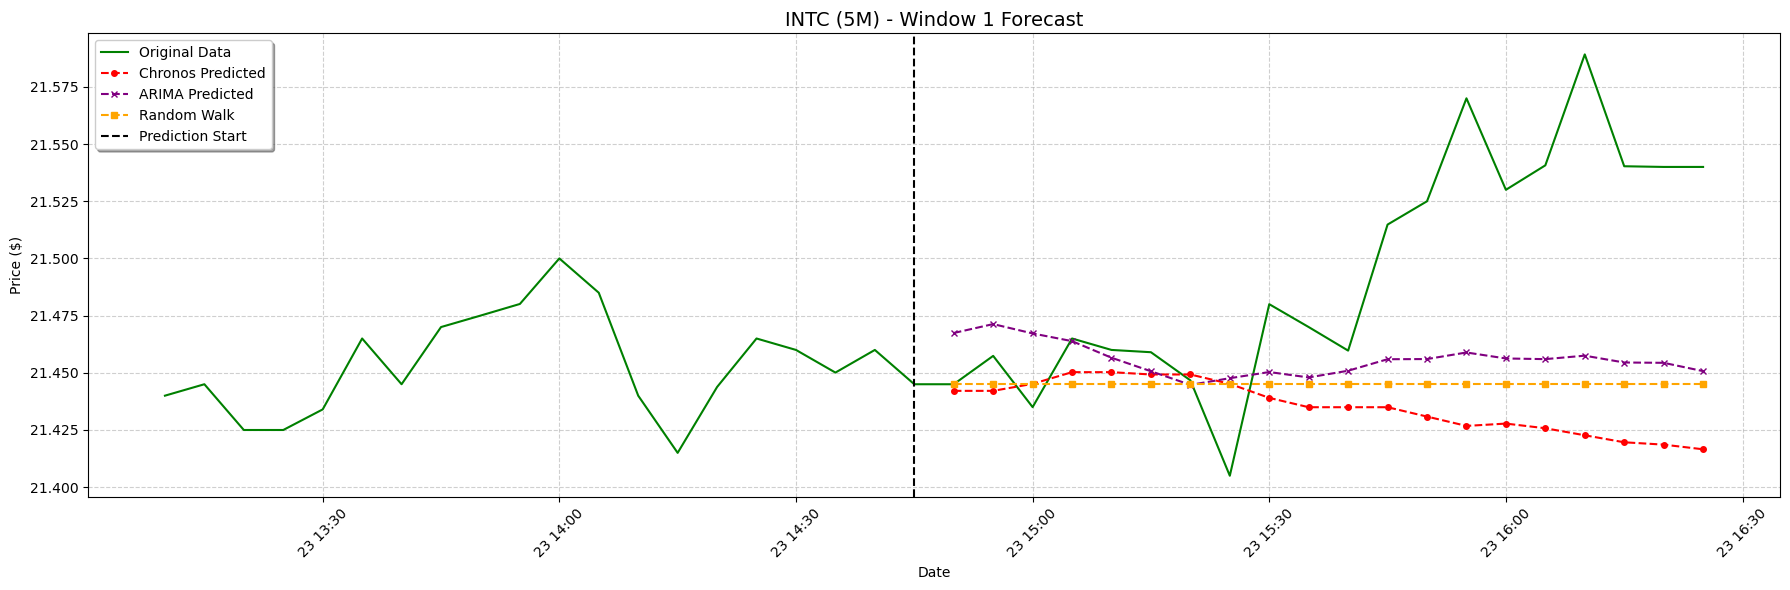

  Chronos - MAE: 0.0636, RMSE: 0.0829
  ARIMA   - MAE: 0.0488, RMSE: 0.0626
  Rand.W. - MAE: 0.0536, RMSE: 0.0693
Processing window 2/50...


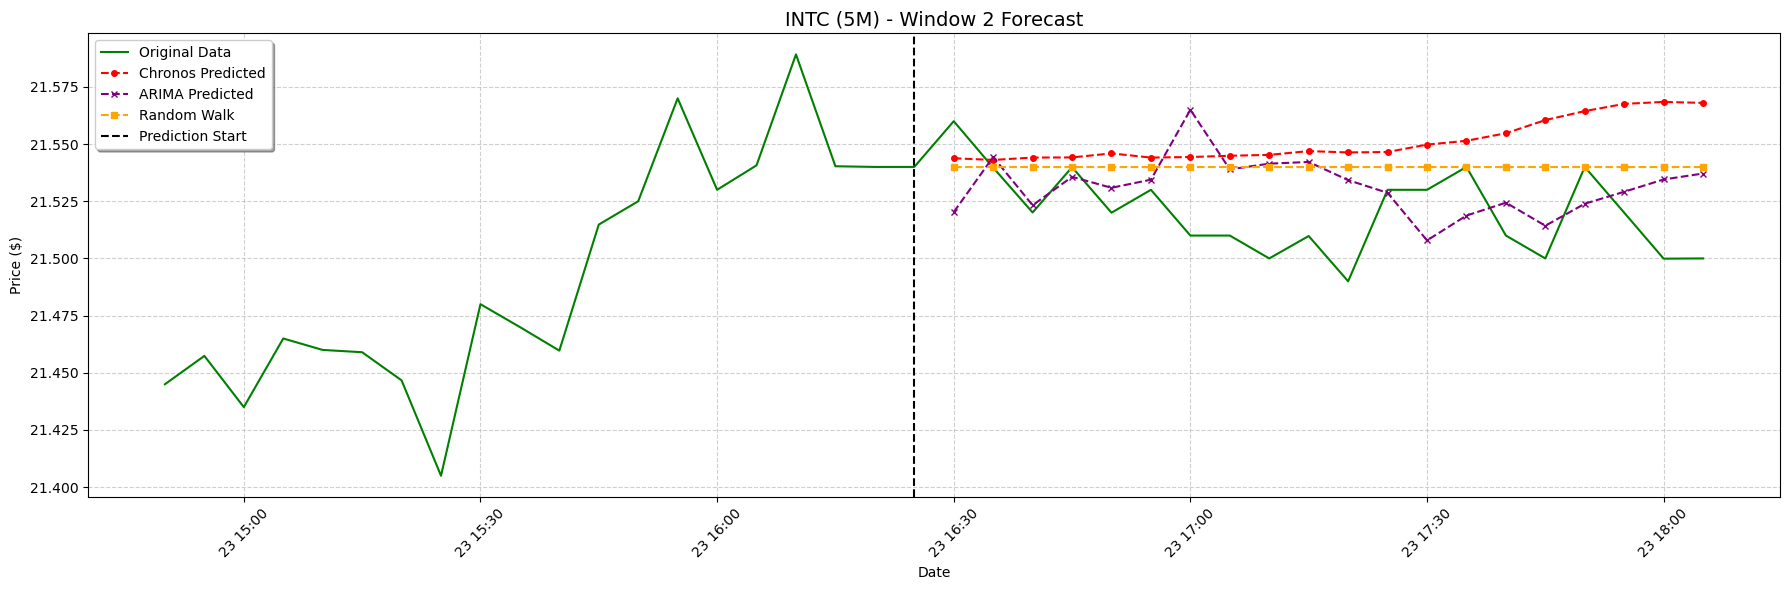

  Chronos - MAE: 0.0329, RMSE: 0.0383
  ARIMA   - MAE: 0.0220, RMSE: 0.0270
  Rand.W. - MAE: 0.0220, RMSE: 0.0268
Processing window 3/50...


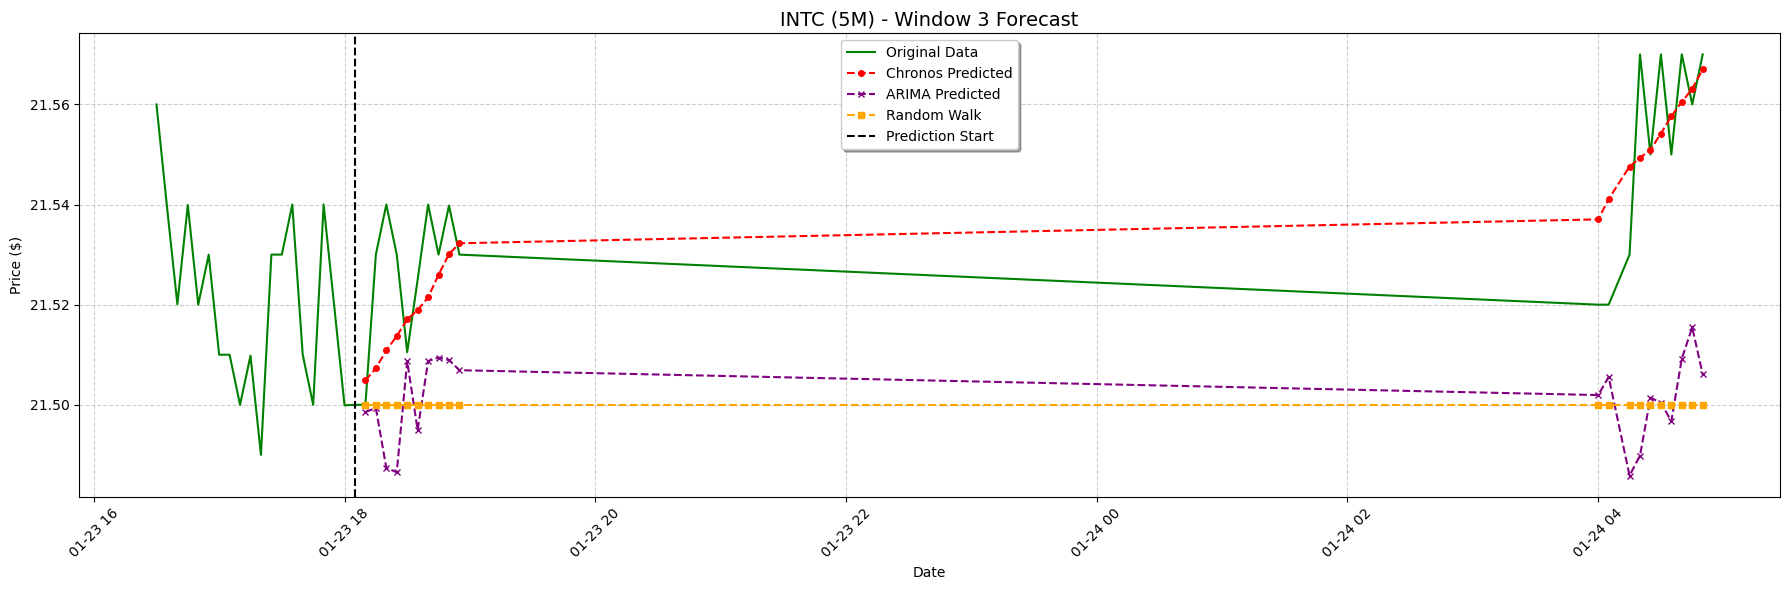

  Chronos - MAE: 0.0118, RMSE: 0.0143
  ARIMA   - MAE: 0.0382, RMSE: 0.0437
  Rand.W. - MAE: 0.0393, RMSE: 0.0442
Processing window 4/50...


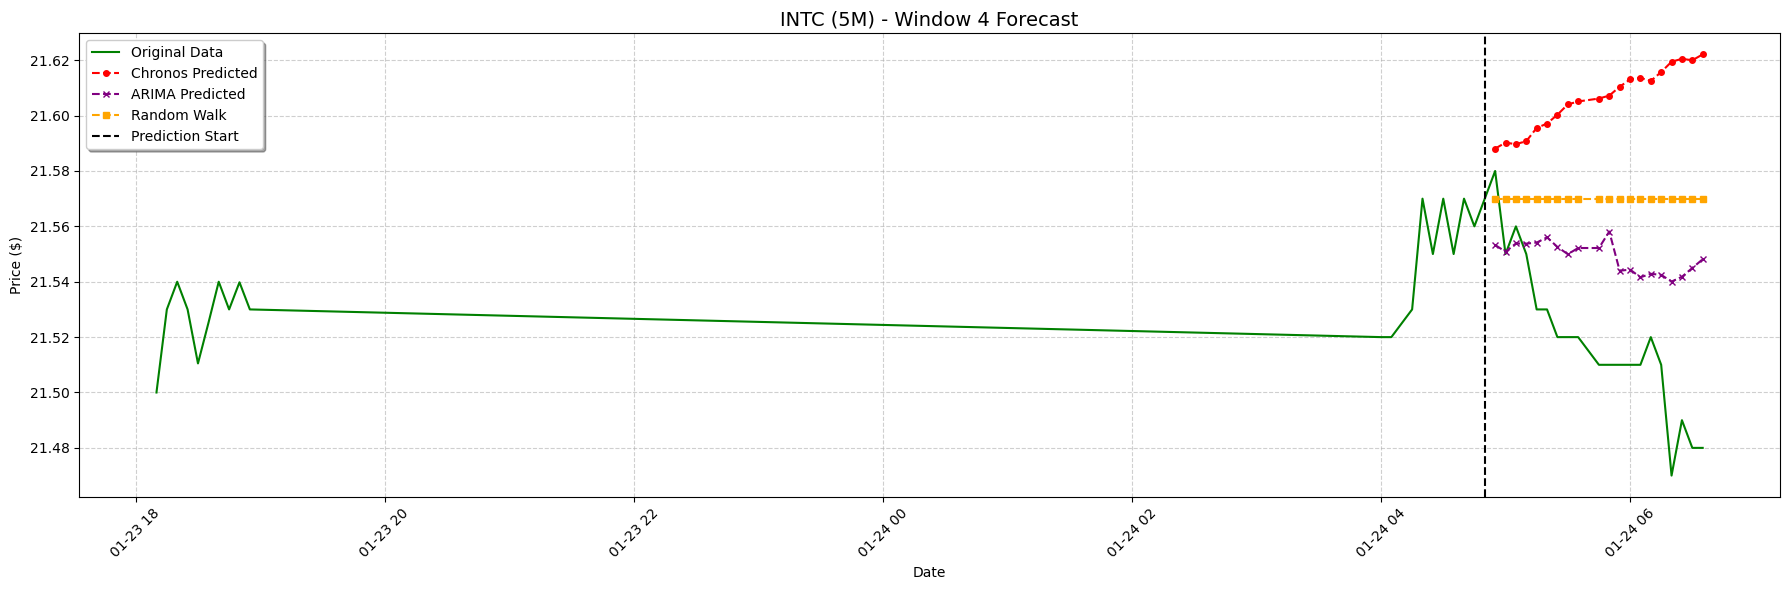

  Chronos - MAE: 0.0881, RMSE: 0.0956
  ARIMA   - MAE: 0.0341, RMSE: 0.0390
  Rand.W. - MAE: 0.0530, RMSE: 0.0585
Processing window 5/50...


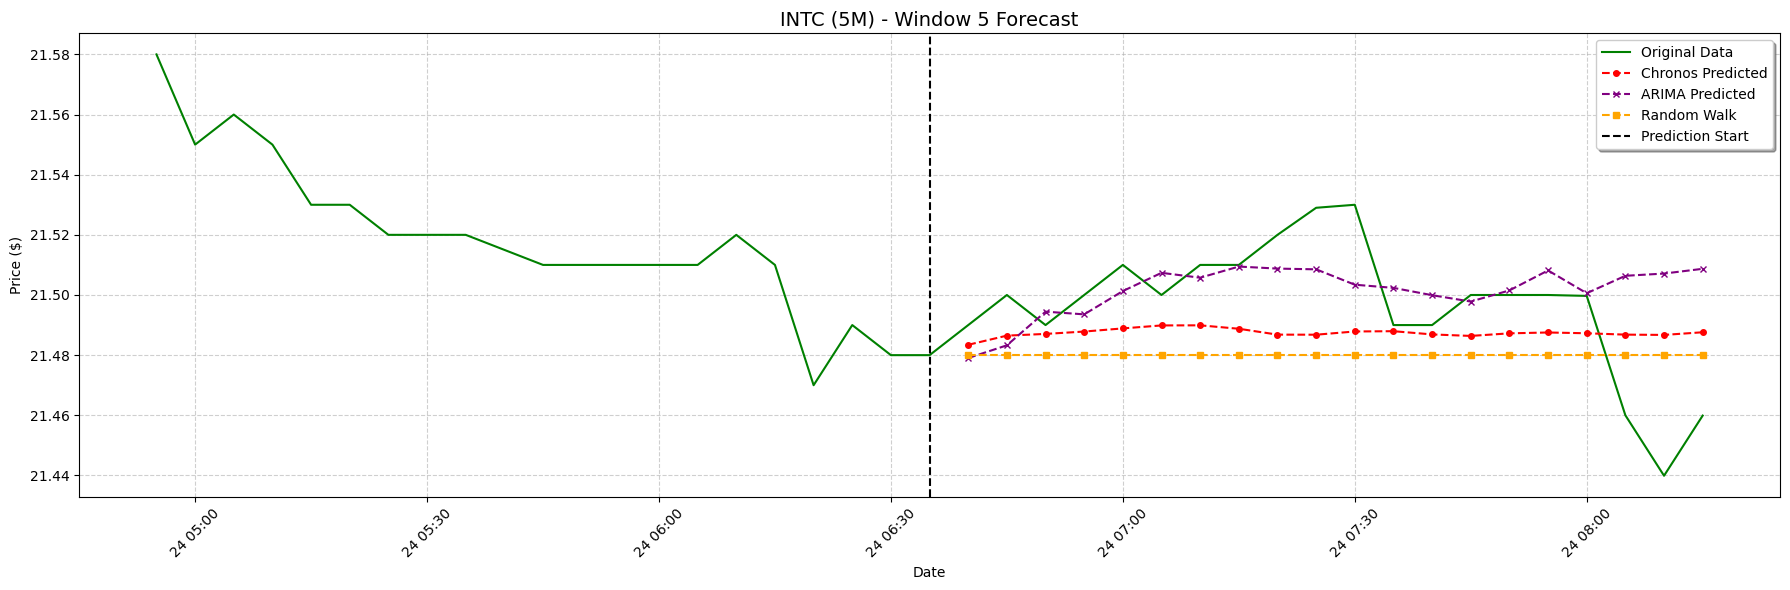

  Chronos - MAE: 0.0191, RMSE: 0.0232
  ARIMA   - MAE: 0.0158, RMSE: 0.0237
  Rand.W. - MAE: 0.0244, RMSE: 0.0272
Processing window 6/50...


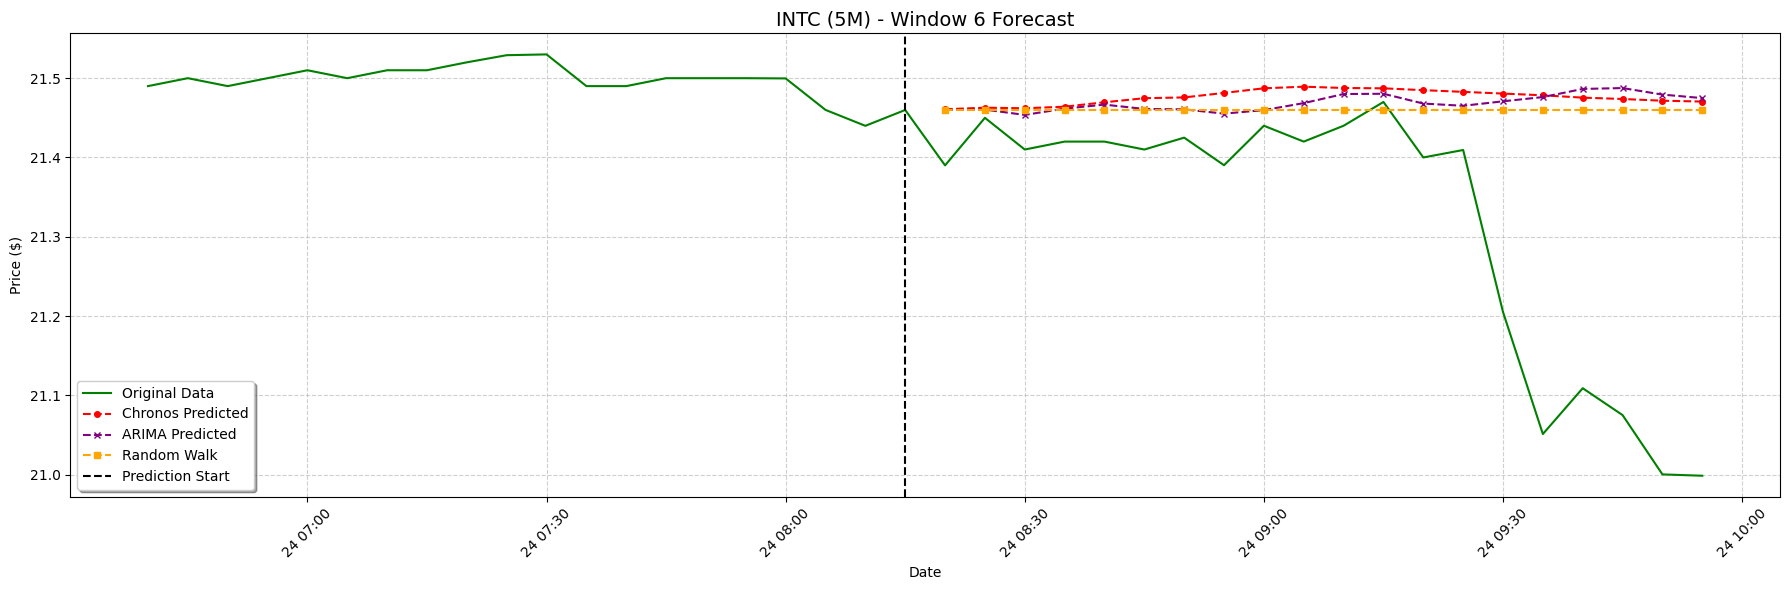

  Chronos - MAE: 0.1594, RMSE: 0.2287
  ARIMA   - MAE: 0.1521, RMSE: 0.2293
  Rand.W. - MAE: 0.1442, RMSE: 0.2186
Processing window 7/50...


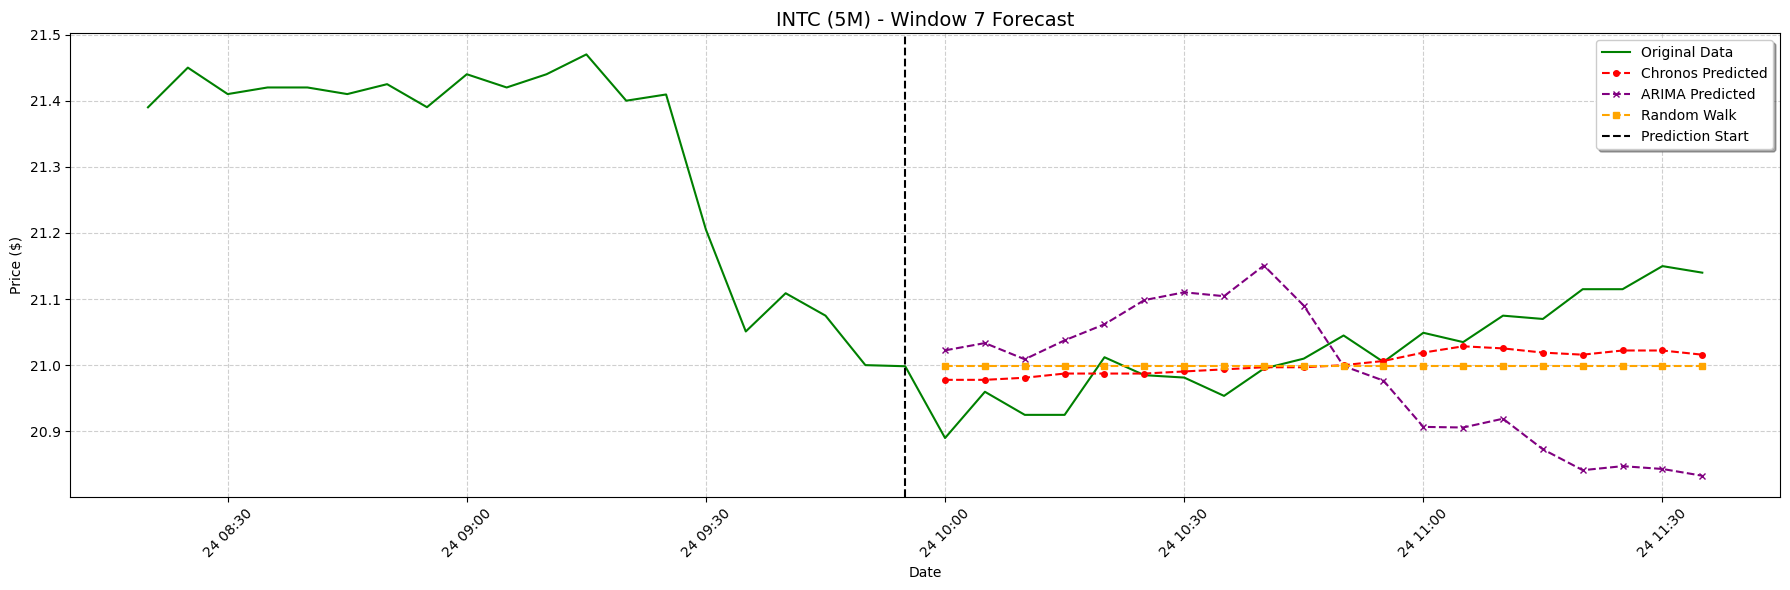

  Chronos - MAE: 0.0471, RMSE: 0.0615
  ARIMA   - MAE: 0.1468, RMSE: 0.1682
  Rand.W. - MAE: 0.0606, RMSE: 0.0755
Processing window 8/50...


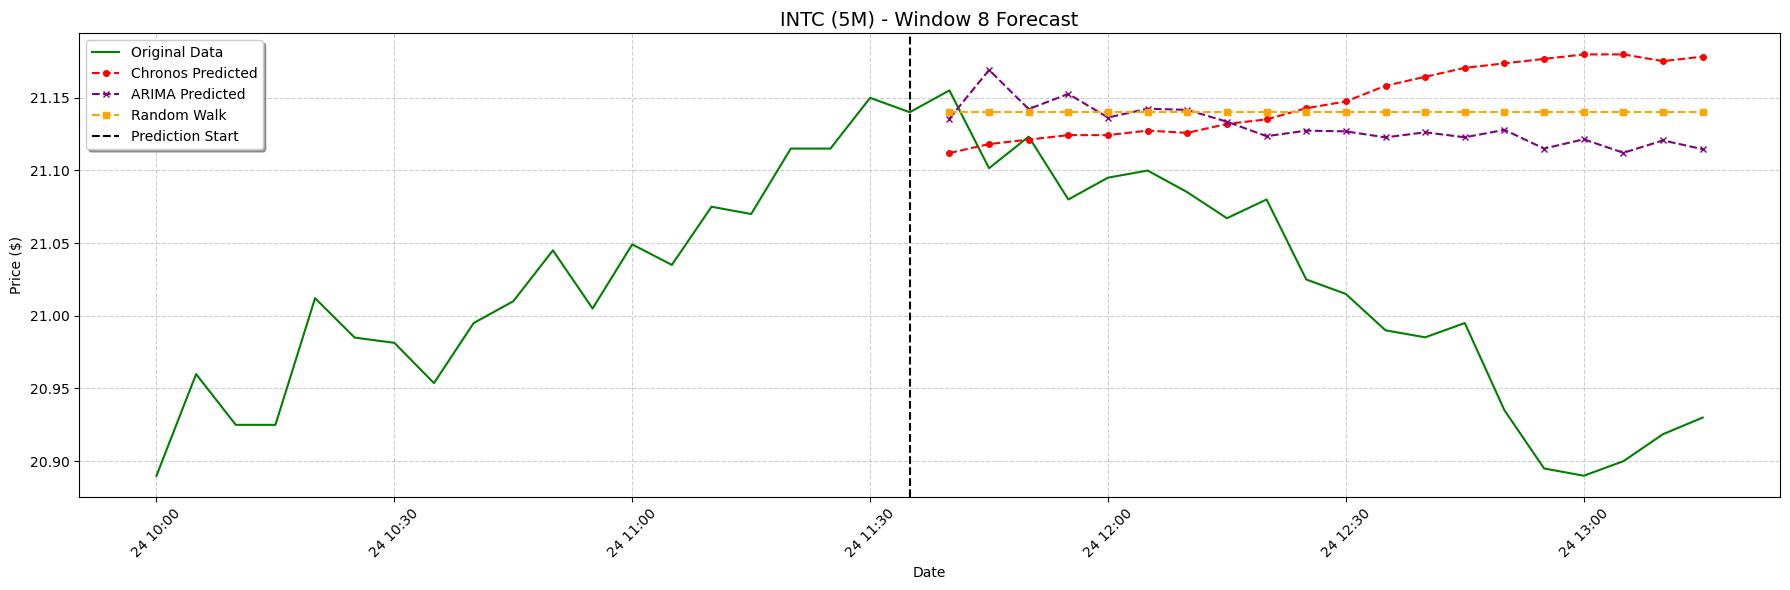

  Chronos - MAE: 0.1346, RMSE: 0.1678
  ARIMA   - MAE: 0.1144, RMSE: 0.1341
  Rand.W. - MAE: 0.1232, RMSE: 0.1471
Processing window 9/50...


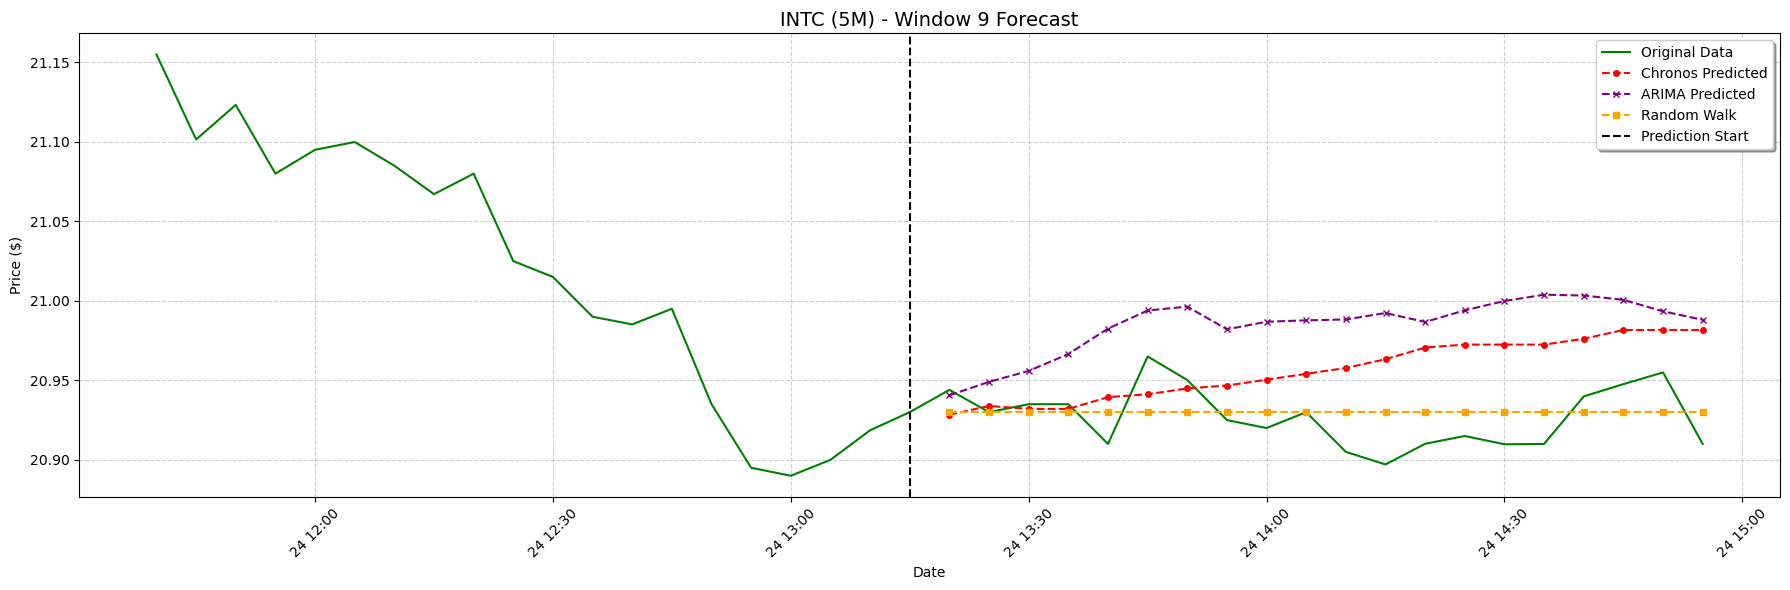

  Chronos - MAE: 0.0345, RMSE: 0.0412
  ARIMA   - MAE: 0.0578, RMSE: 0.0635
  Rand.W. - MAE: 0.0160, RMSE: 0.0187
Processing window 10/50...


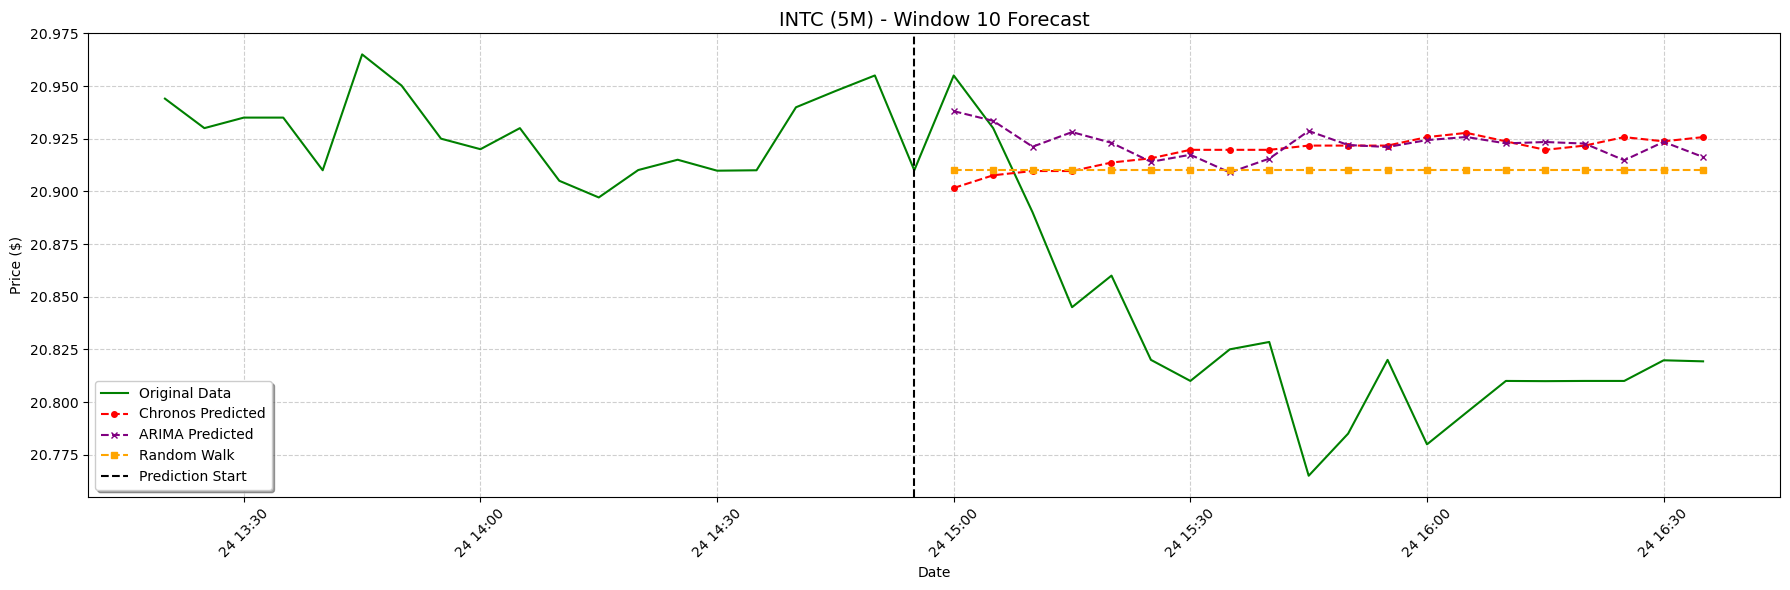

  Chronos - MAE: 0.0970, RMSE: 0.1036
  ARIMA   - MAE: 0.0946, RMSE: 0.1025
  Rand.W. - MAE: 0.0871, RMSE: 0.0930
Processing window 11/50...


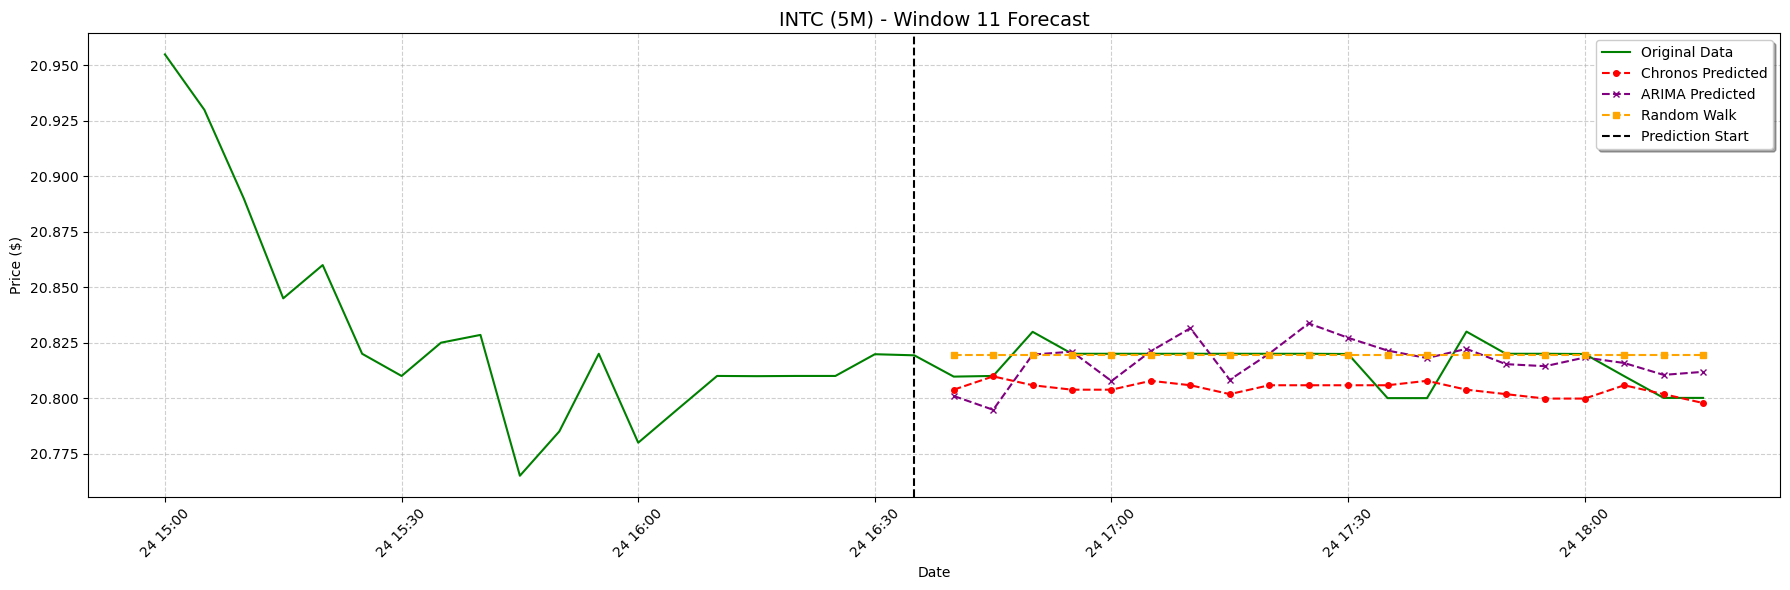

  Chronos - MAE: 0.0128, RMSE: 0.0148
  ARIMA   - MAE: 0.0090, RMSE: 0.0106
  Rand.W. - MAE: 0.0067, RMSE: 0.0100
Processing window 12/50...


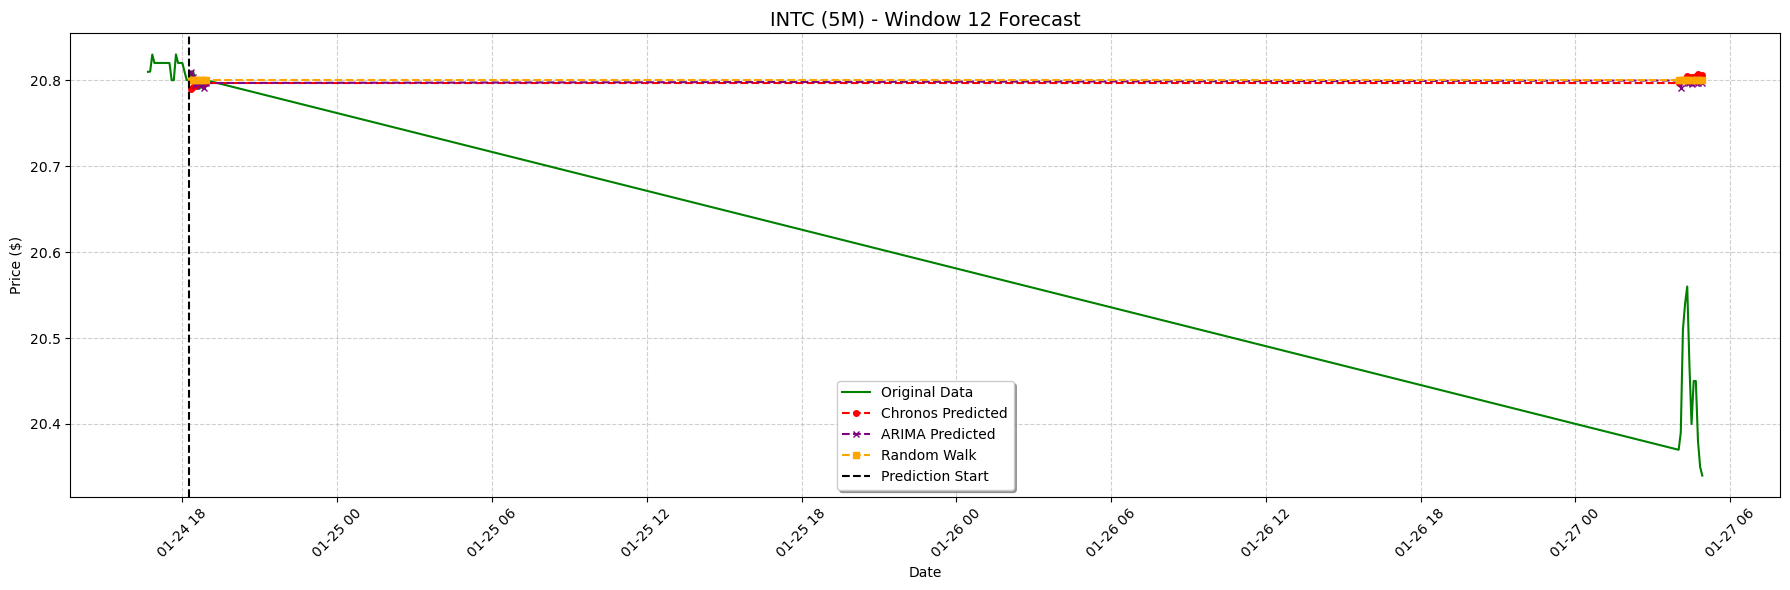

  Chronos - MAE: 0.2244, RMSE: 0.2911
  ARIMA   - MAE: 0.2200, RMSE: 0.2869
  Rand.W. - MAE: 0.2218, RMSE: 0.2888
Processing window 13/50...


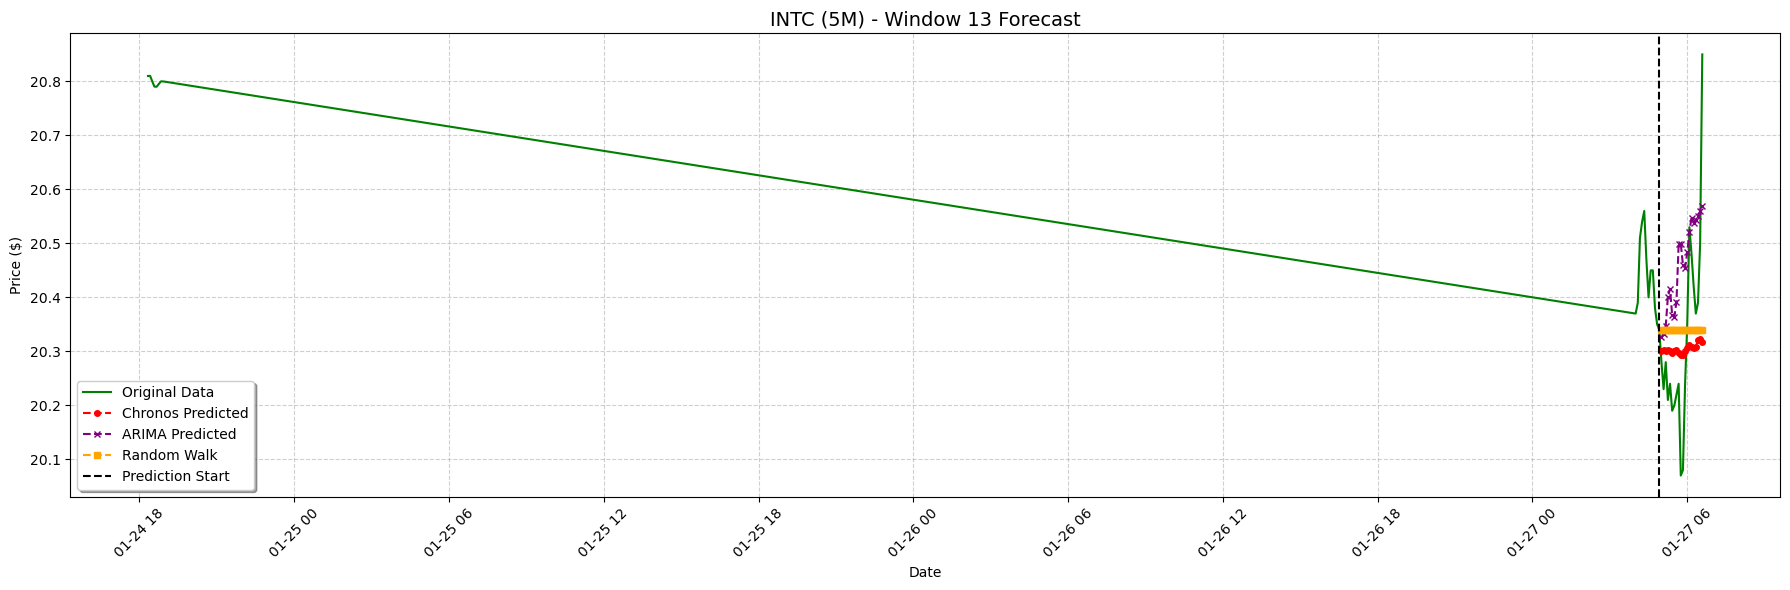

  Chronos - MAE: 0.1249, RMSE: 0.1680
  ARIMA   - MAE: 0.1690, RMSE: 0.1986
  Rand.W. - MAE: 0.1385, RMSE: 0.1753
Processing window 14/50...


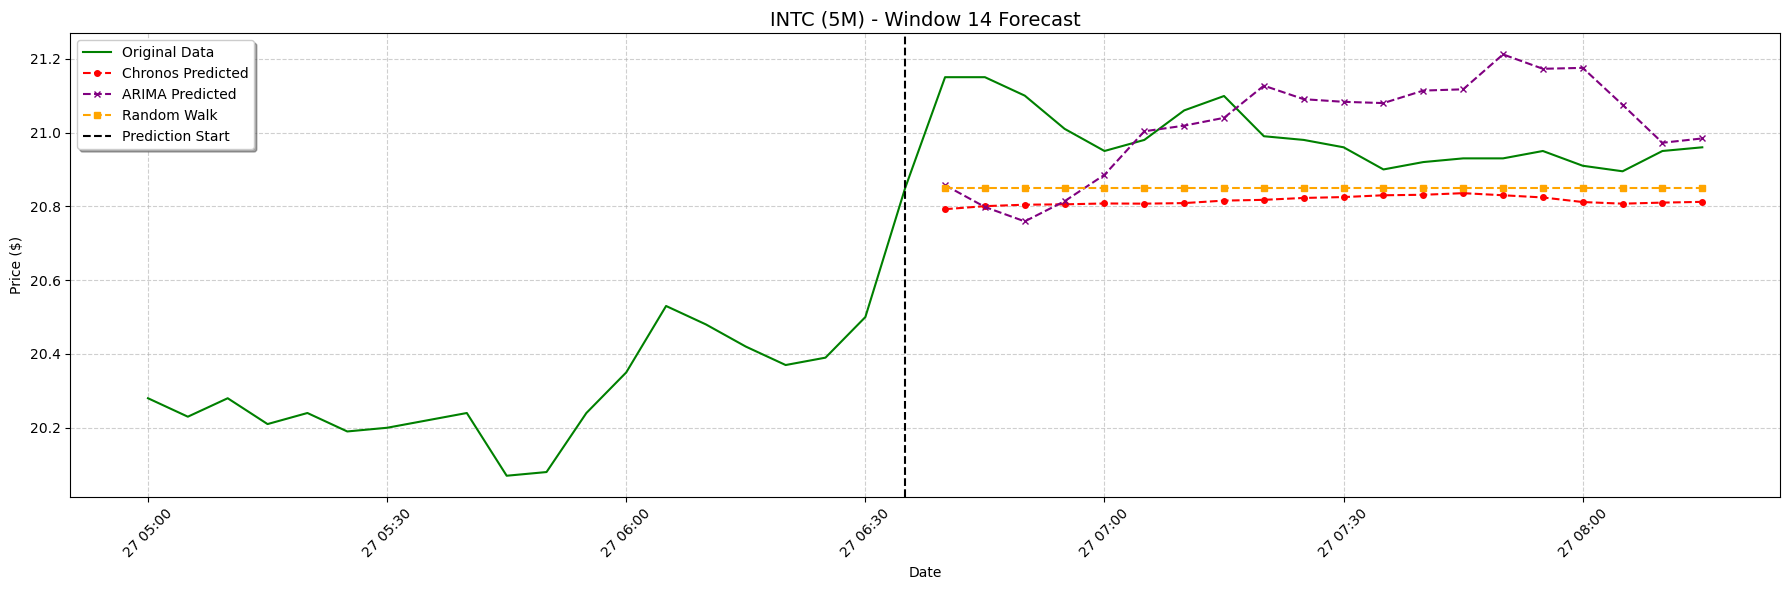

  Chronos - MAE: 0.1737, RMSE: 0.1939
  ARIMA   - MAE: 0.1648, RMSE: 0.1946
  Rand.W. - MAE: 0.1387, RMSE: 0.1593
Processing window 15/50...


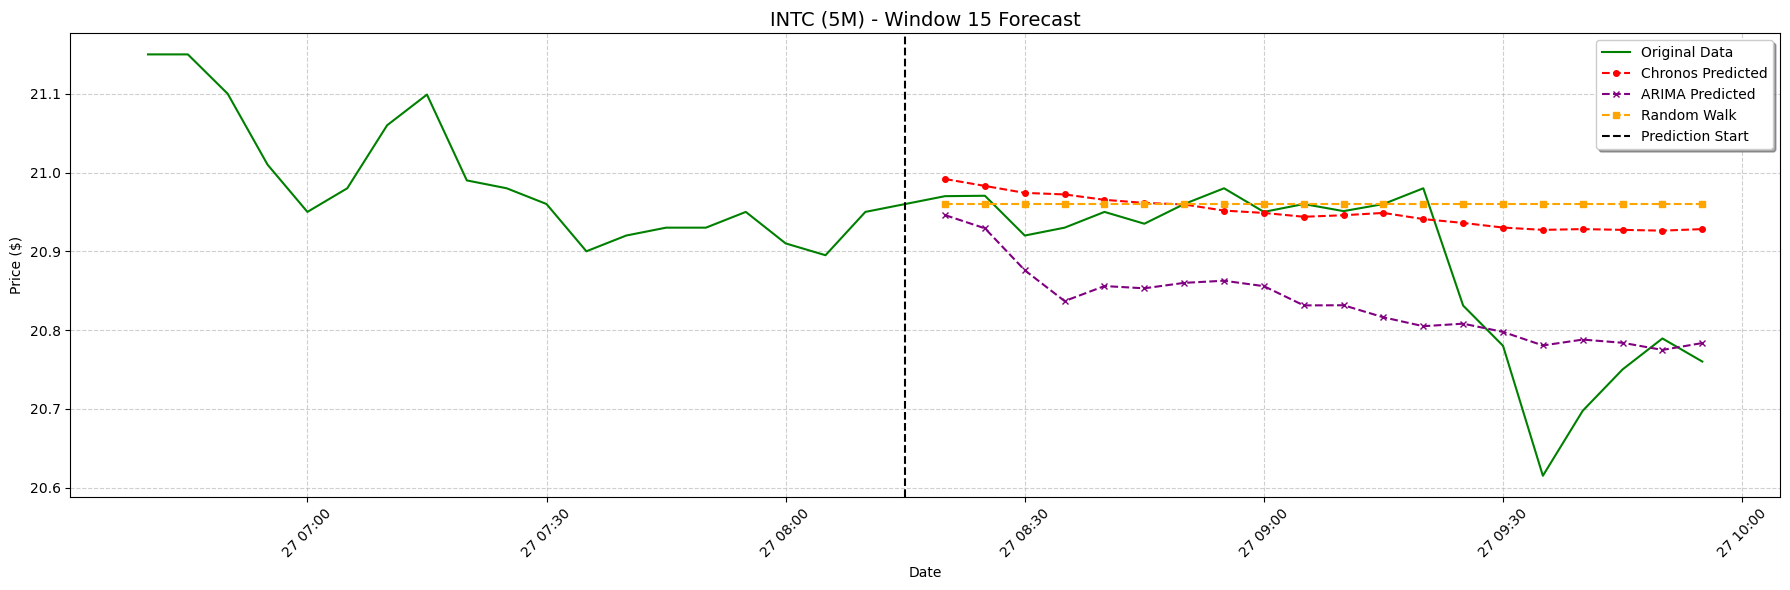

  Chronos - MAE: 0.0777, RMSE: 0.1166
  ARIMA   - MAE: 0.0813, RMSE: 0.0953
  Rand.W. - MAE: 0.0841, RMSE: 0.1332
Processing window 16/50...


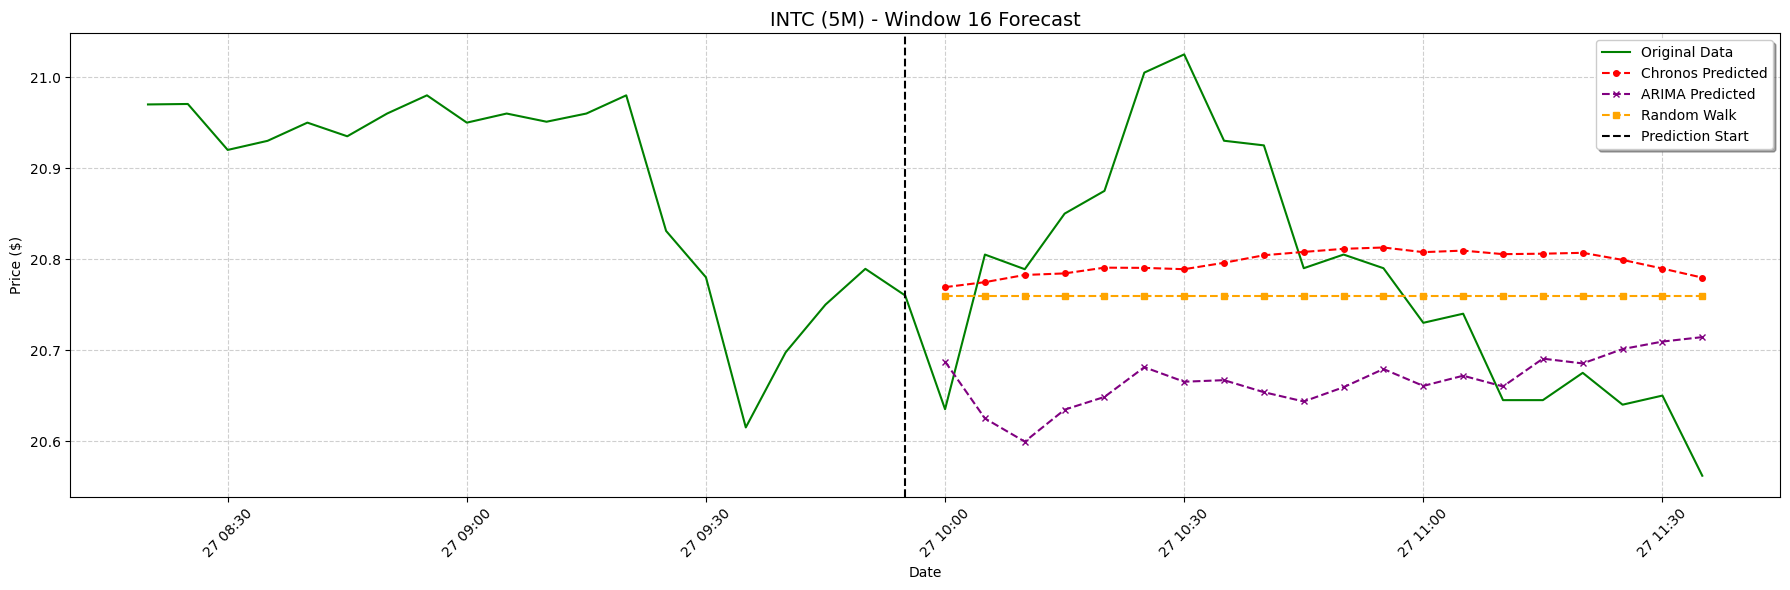

  Chronos - MAE: 0.1095, RMSE: 0.1300
  ARIMA   - MAE: 0.1483, RMSE: 0.1793
  Rand.W. - MAE: 0.1074, RMSE: 0.1286
Processing window 17/50...


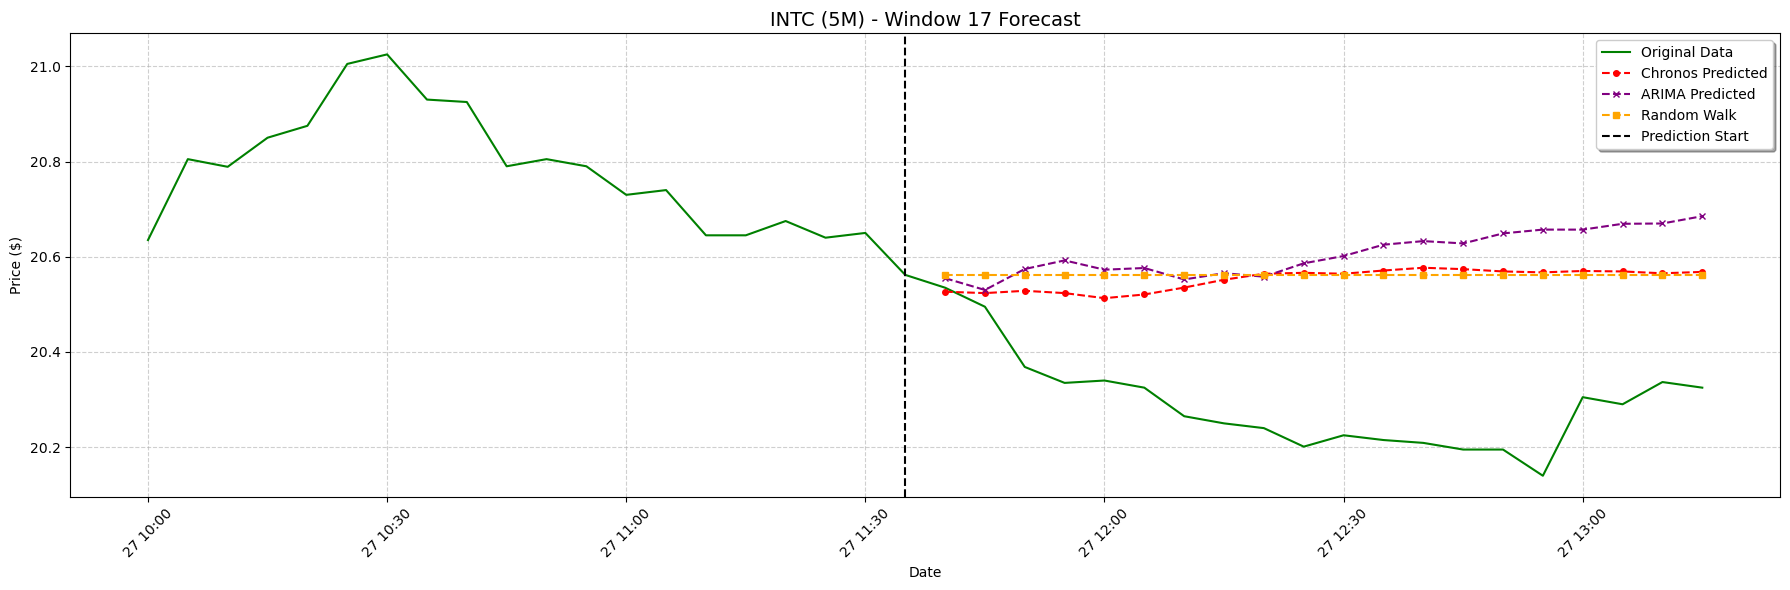

  Chronos - MAE: 0.2637, RMSE: 0.2860
  ARIMA   - MAE: 0.3173, RMSE: 0.3404
  Rand.W. - MAE: 0.2724, RMSE: 0.2890
Processing window 18/50...


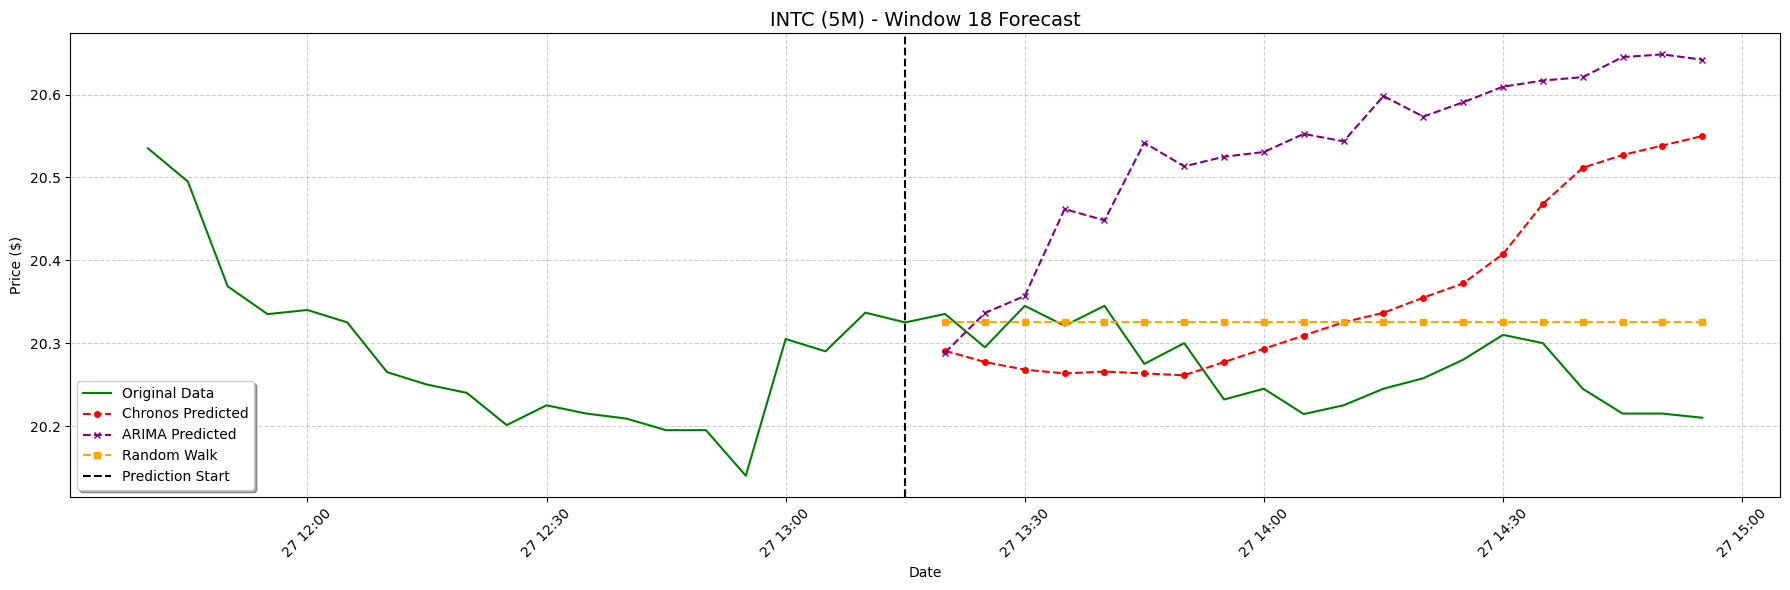

  Chronos - MAE: 0.1202, RMSE: 0.1574
  ARIMA   - MAE: 0.2663, RMSE: 0.2955
  Rand.W. - MAE: 0.0595, RMSE: 0.0707
Processing window 19/50...


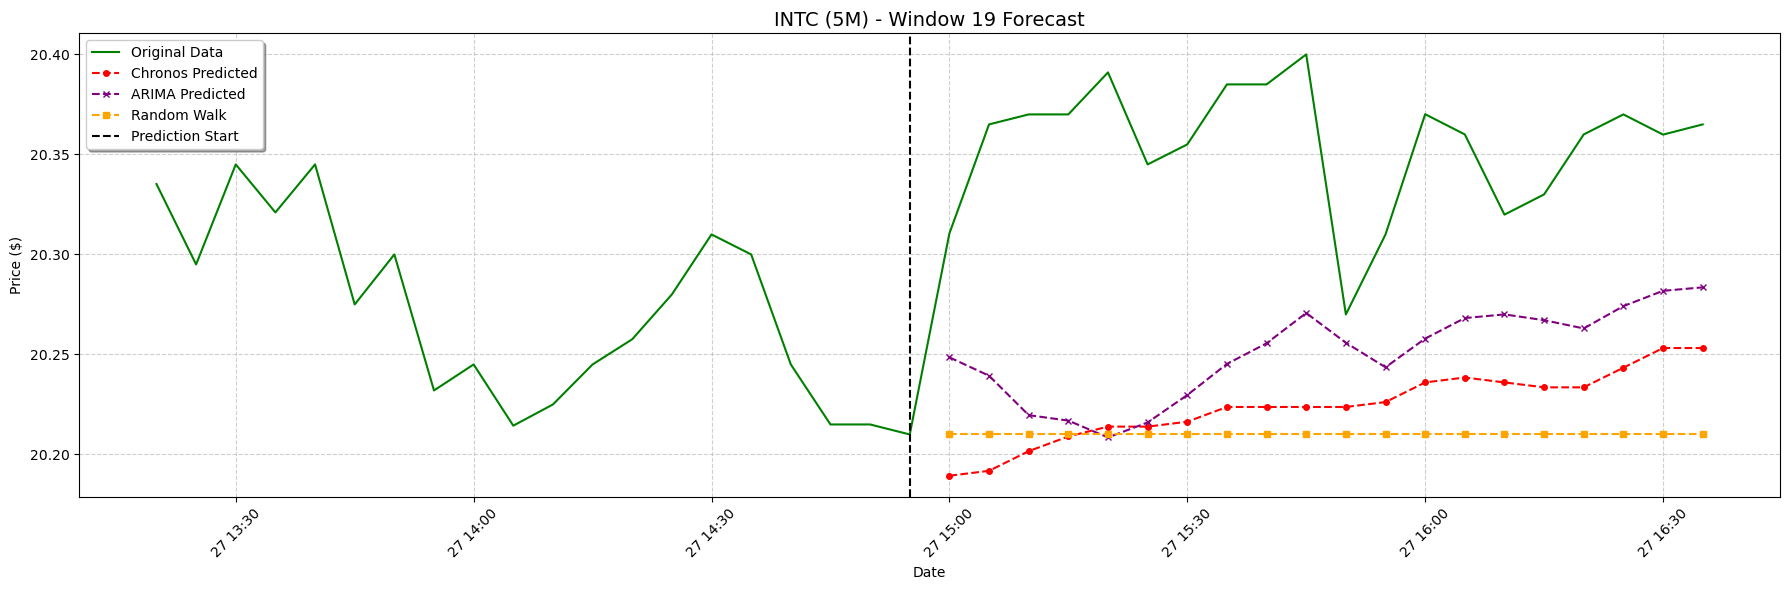

  Chronos - MAE: 0.1303, RMSE: 0.1349
  ARIMA   - MAE: 0.1038, RMSE: 0.1113
  Rand.W. - MAE: 0.1446, RMSE: 0.1479
Processing window 20/50...


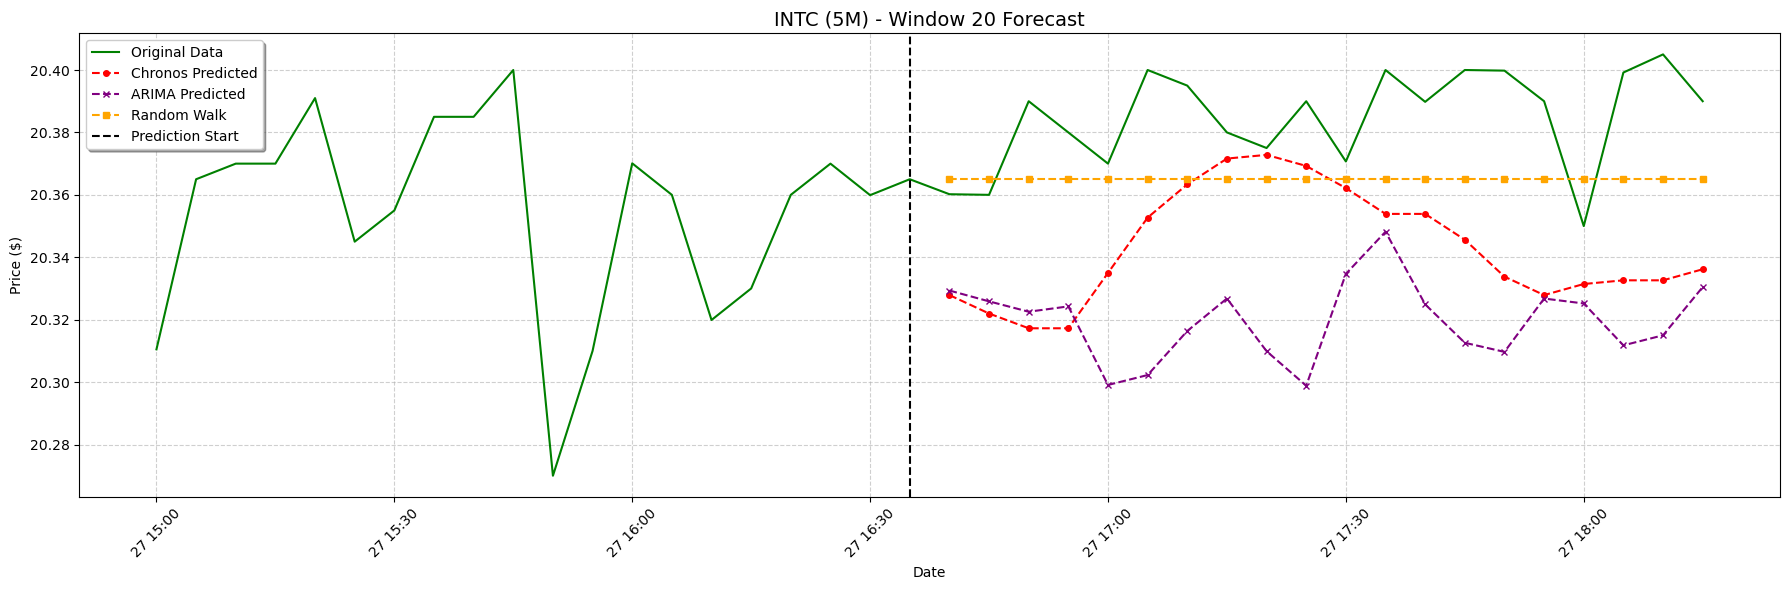

  Chronos - MAE: 0.0418, RMSE: 0.0470
  ARIMA   - MAE: 0.0650, RMSE: 0.0685
  Rand.W. - MAE: 0.0222, RMSE: 0.0251
Processing window 21/50...


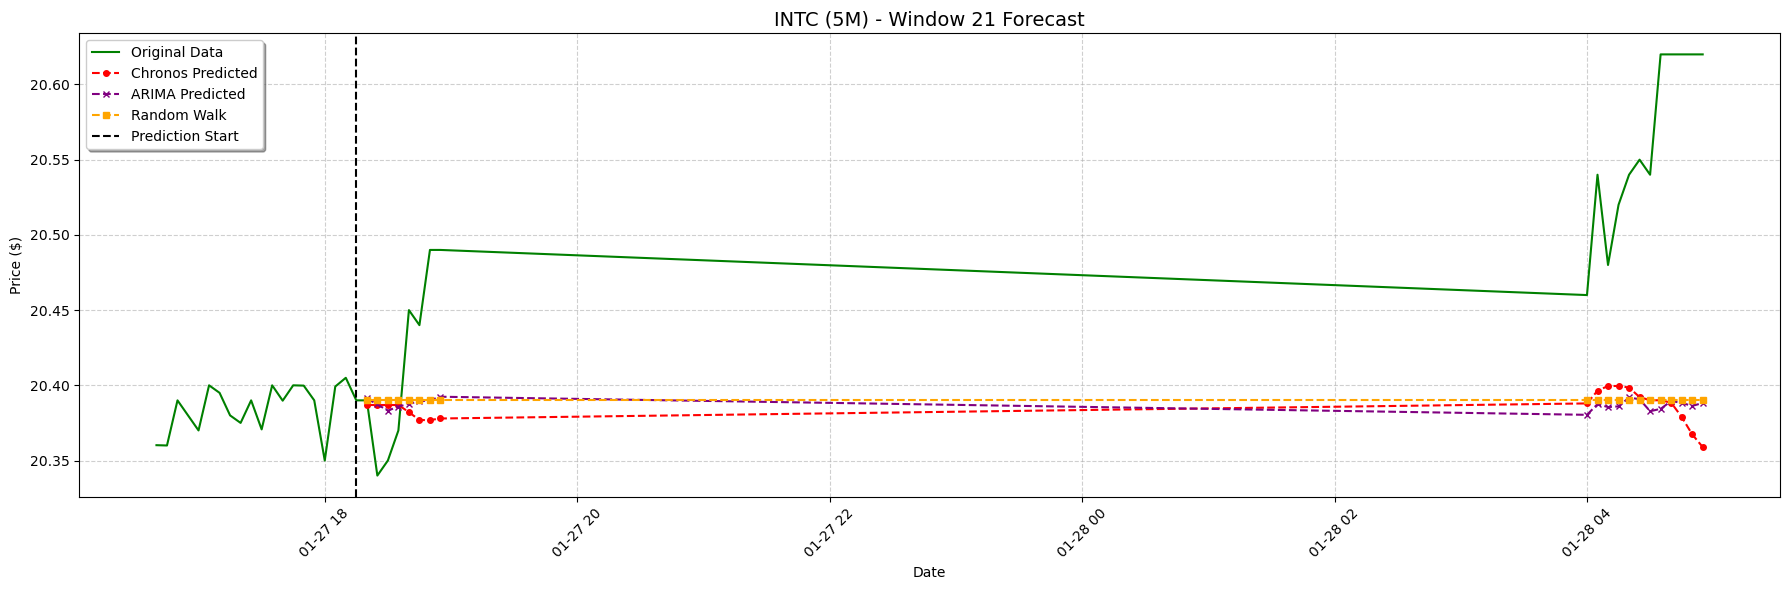

  Chronos - MAE: 0.1271, RMSE: 0.1497
  ARIMA   - MAE: 0.1248, RMSE: 0.1464
  Rand.W. - MAE: 0.1235, RMSE: 0.1446
Processing window 22/50...


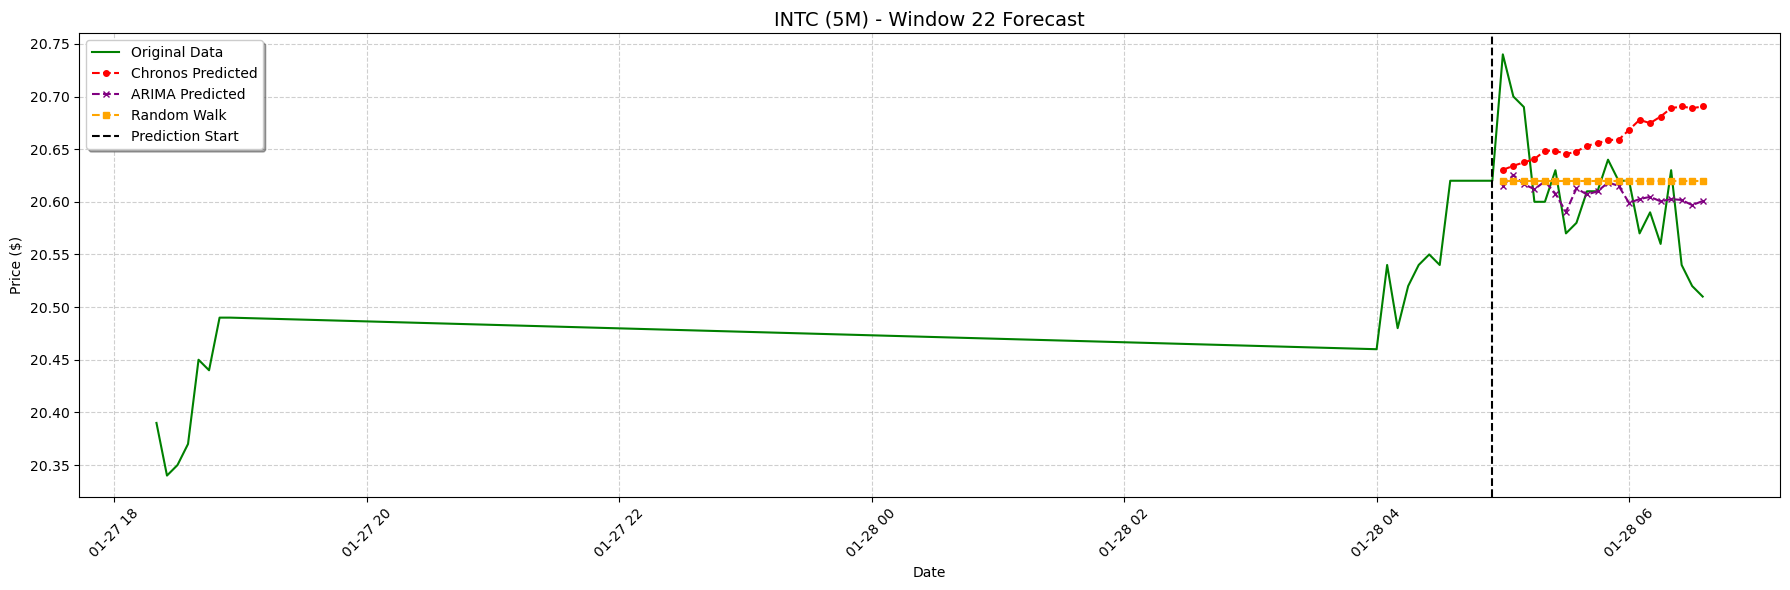

  Chronos - MAE: 0.0773, RMSE: 0.0902
  ARIMA   - MAE: 0.0387, RMSE: 0.0508
  Rand.W. - MAE: 0.0445, RMSE: 0.0578
Processing window 23/50...


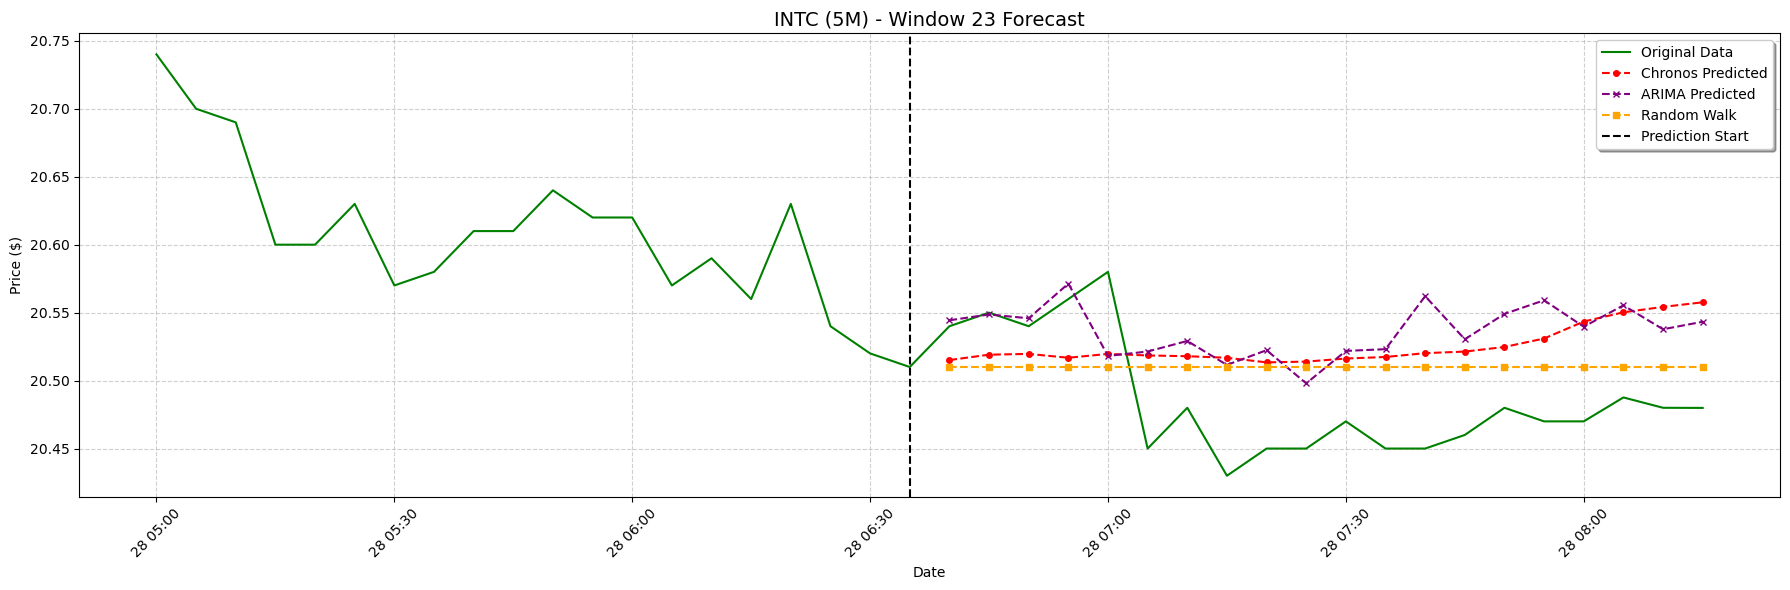

  Chronos - MAE: 0.0570, RMSE: 0.0597
  ARIMA   - MAE: 0.0566, RMSE: 0.0635
  Rand.W. - MAE: 0.0456, RMSE: 0.0483
Processing window 24/50...


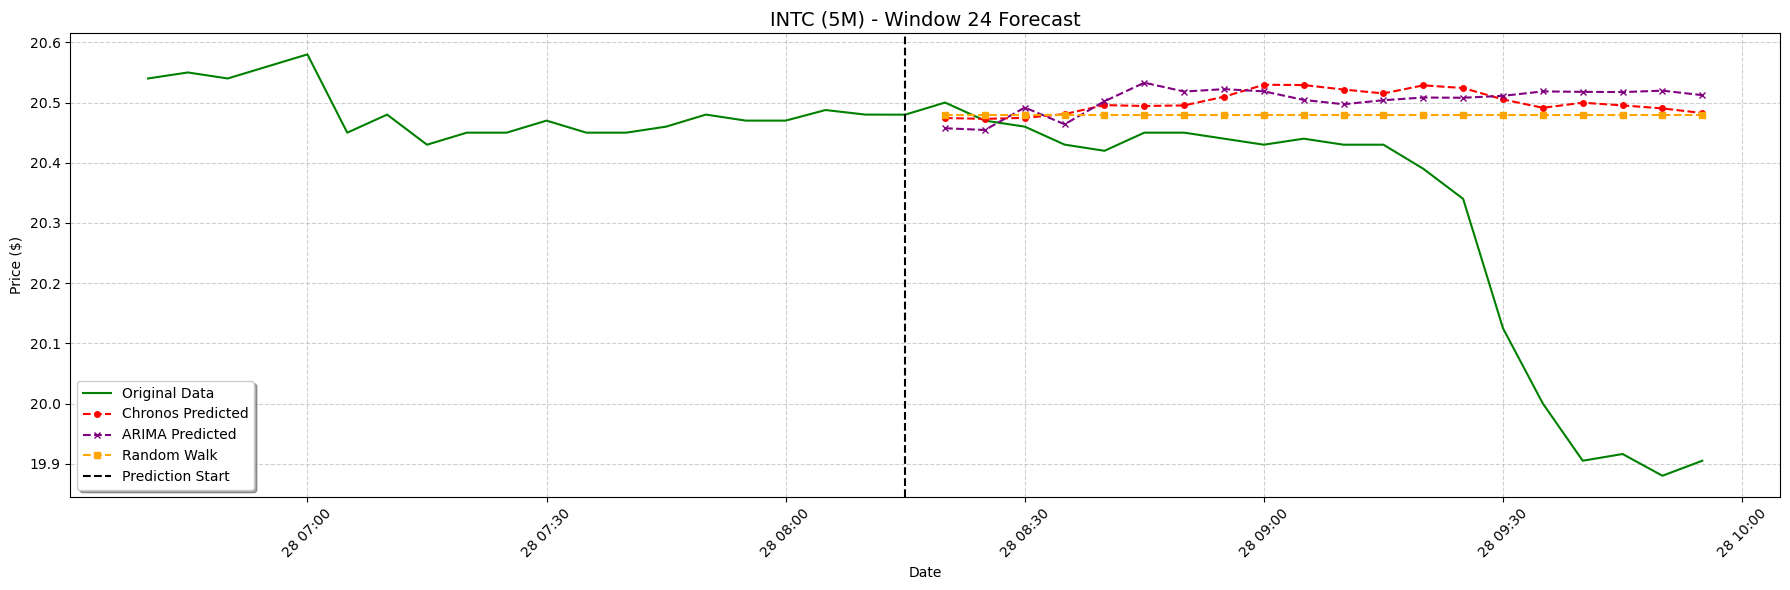

  Chronos - MAE: 0.2125, RMSE: 0.3070
  ARIMA   - MAE: 0.2193, RMSE: 0.3183
  Rand.W. - MAE: 0.1913, RMSE: 0.2951
Processing window 25/50...


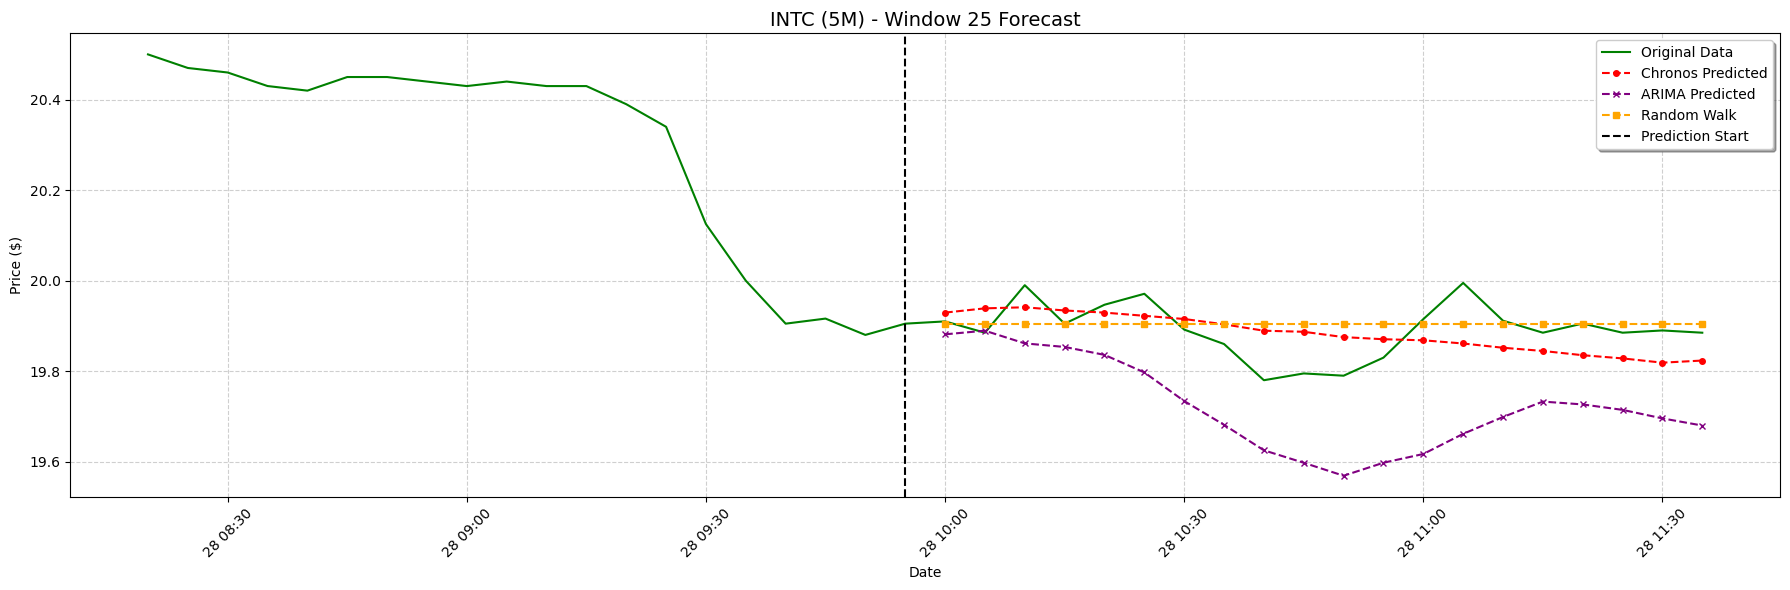

  Chronos - MAE: 0.0576, RMSE: 0.0645
  ARIMA   - MAE: 0.1692, RMSE: 0.1863
  Rand.W. - MAE: 0.0441, RMSE: 0.0601
Processing window 26/50...


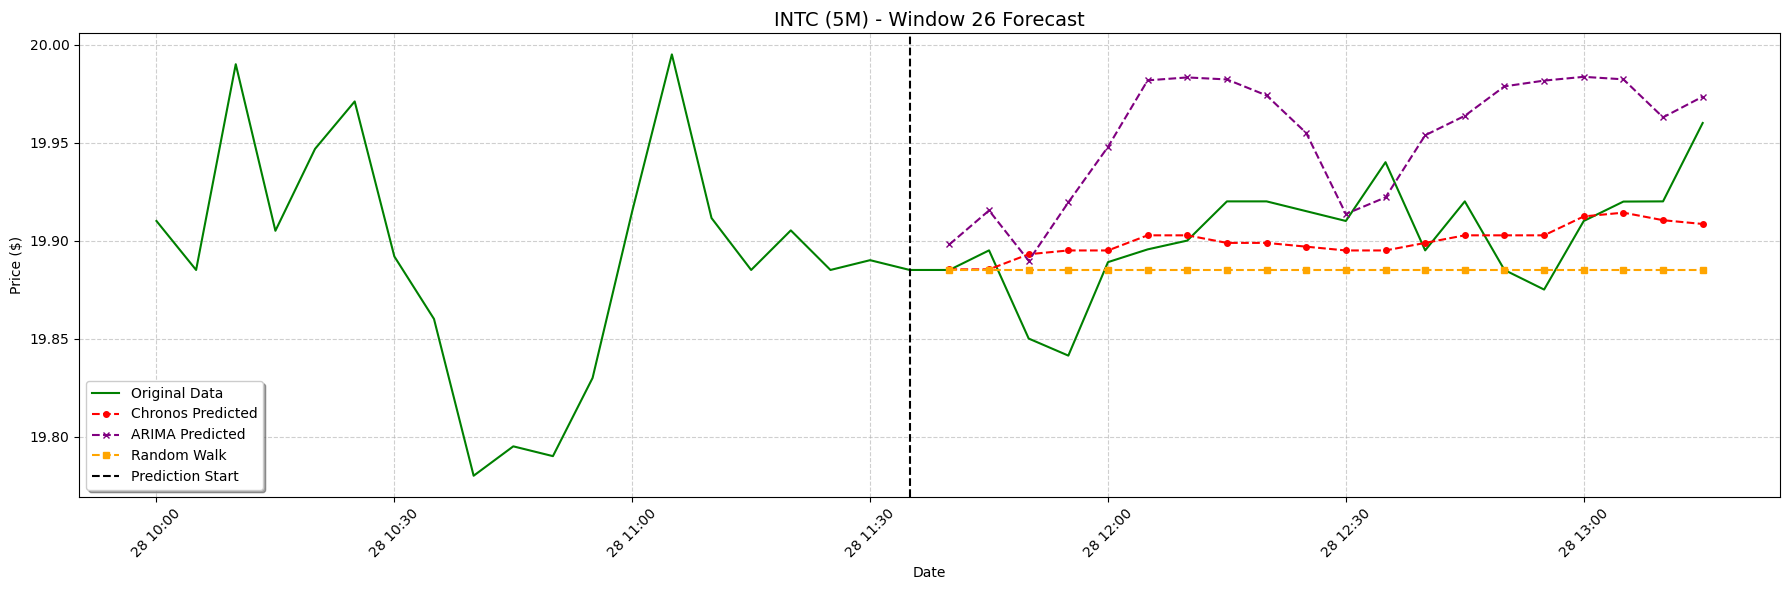

  Chronos - MAE: 0.0189, RMSE: 0.0251
  ARIMA   - MAE: 0.0526, RMSE: 0.0599
  Rand.W. - MAE: 0.0262, RMSE: 0.0322
Processing window 27/50...


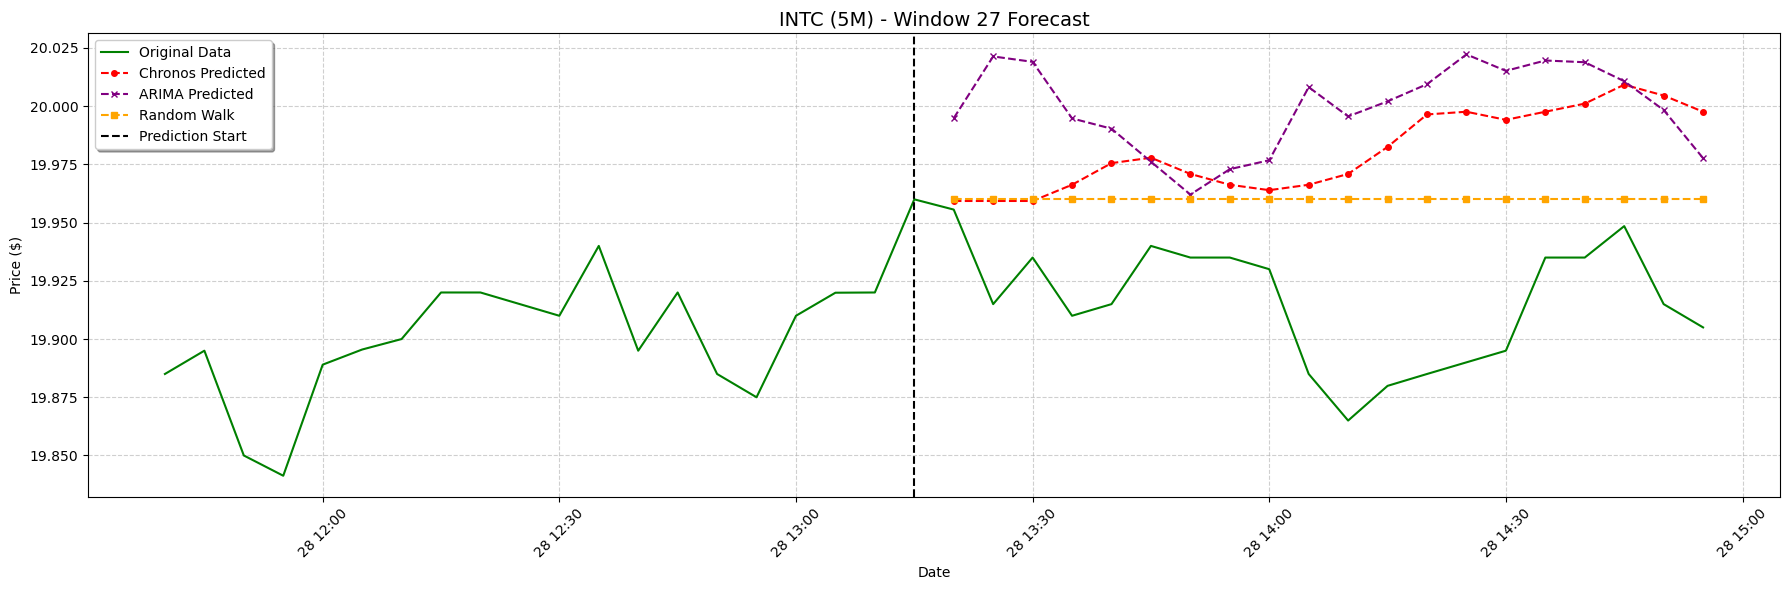

  Chronos - MAE: 0.0654, RMSE: 0.0725
  ARIMA   - MAE: 0.0839, RMSE: 0.0904
  Rand.W. - MAE: 0.0445, RMSE: 0.0510
Processing window 28/50...


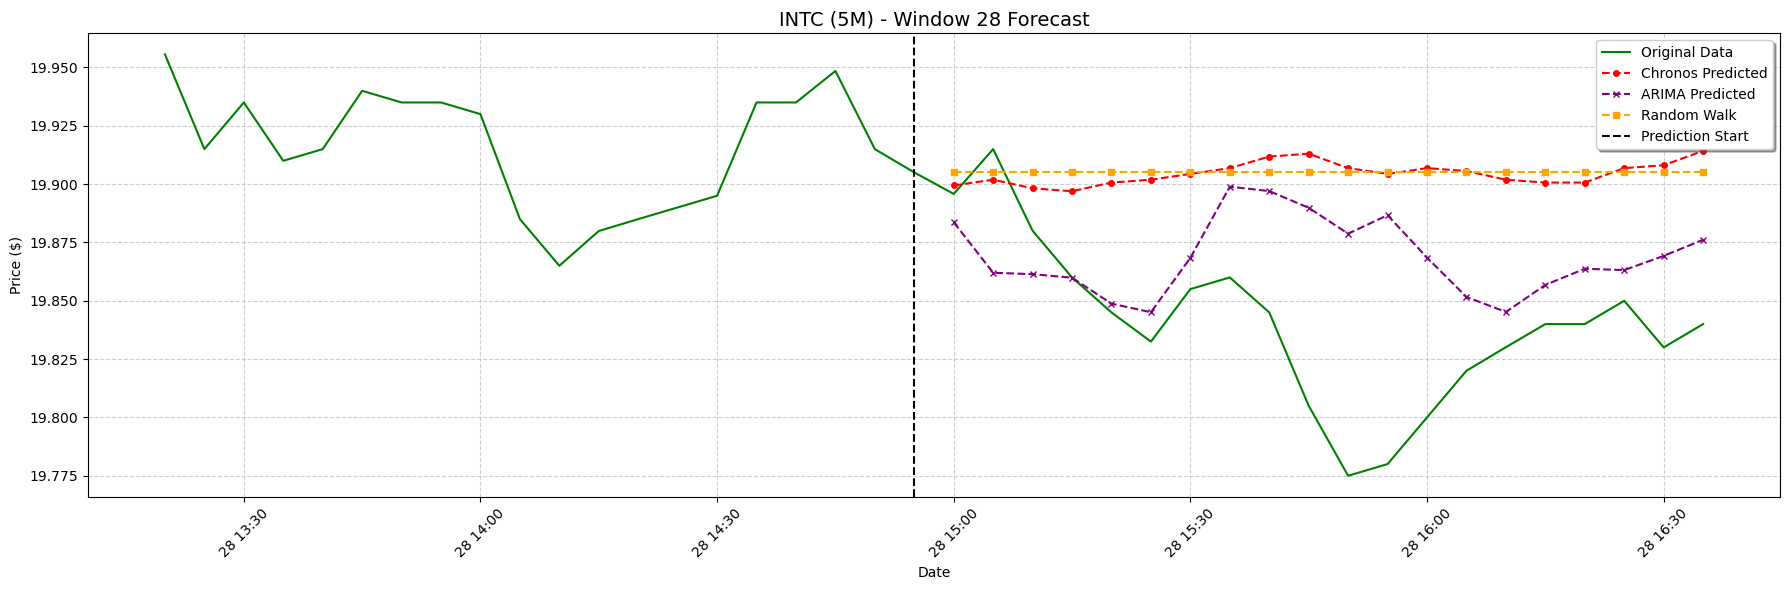

  Chronos - MAE: 0.0660, RMSE: 0.0740
  ARIMA   - MAE: 0.0372, RMSE: 0.0485
  Rand.W. - MAE: 0.0661, RMSE: 0.0733
Processing window 29/50...


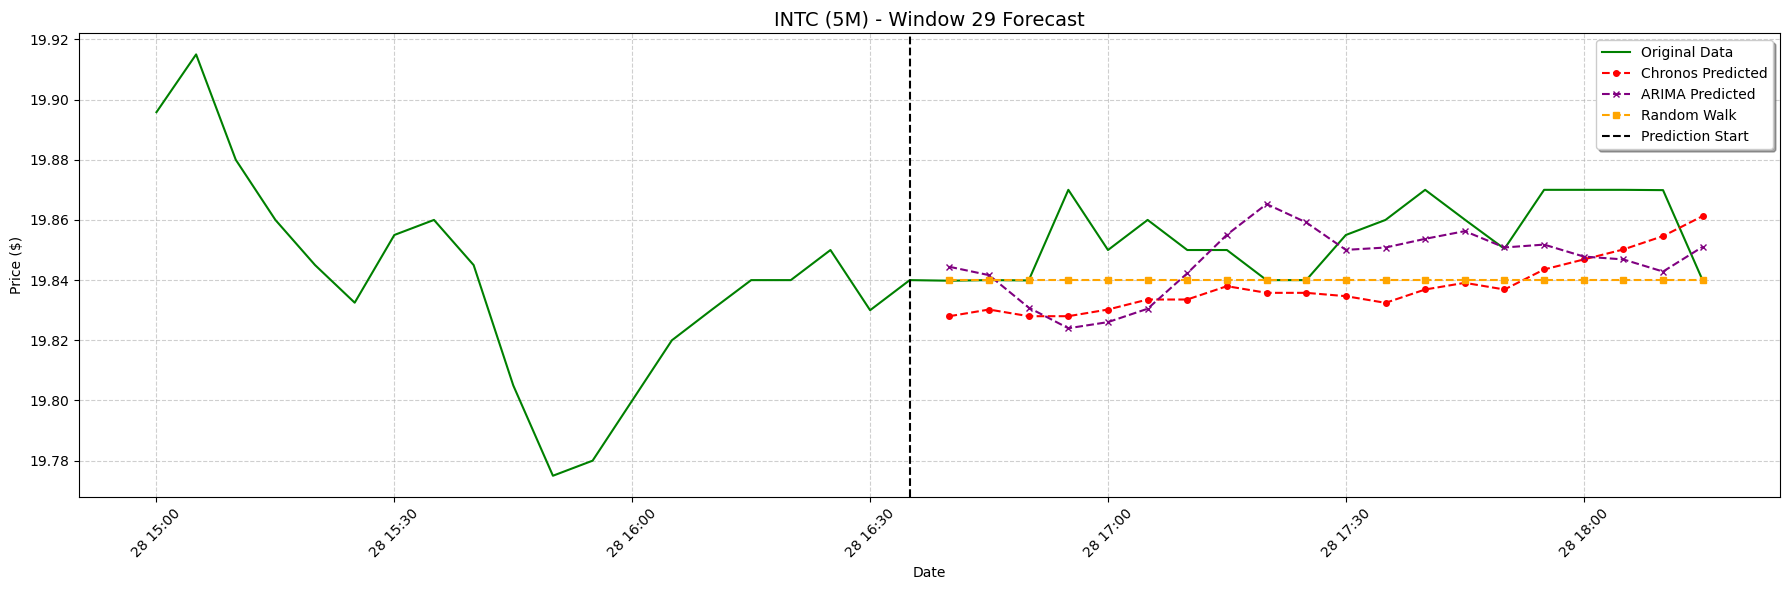

  Chronos - MAE: 0.0190, RMSE: 0.0211
  ARIMA   - MAE: 0.0154, RMSE: 0.0192
  Rand.W. - MAE: 0.0148, RMSE: 0.0190
Processing window 30/50...


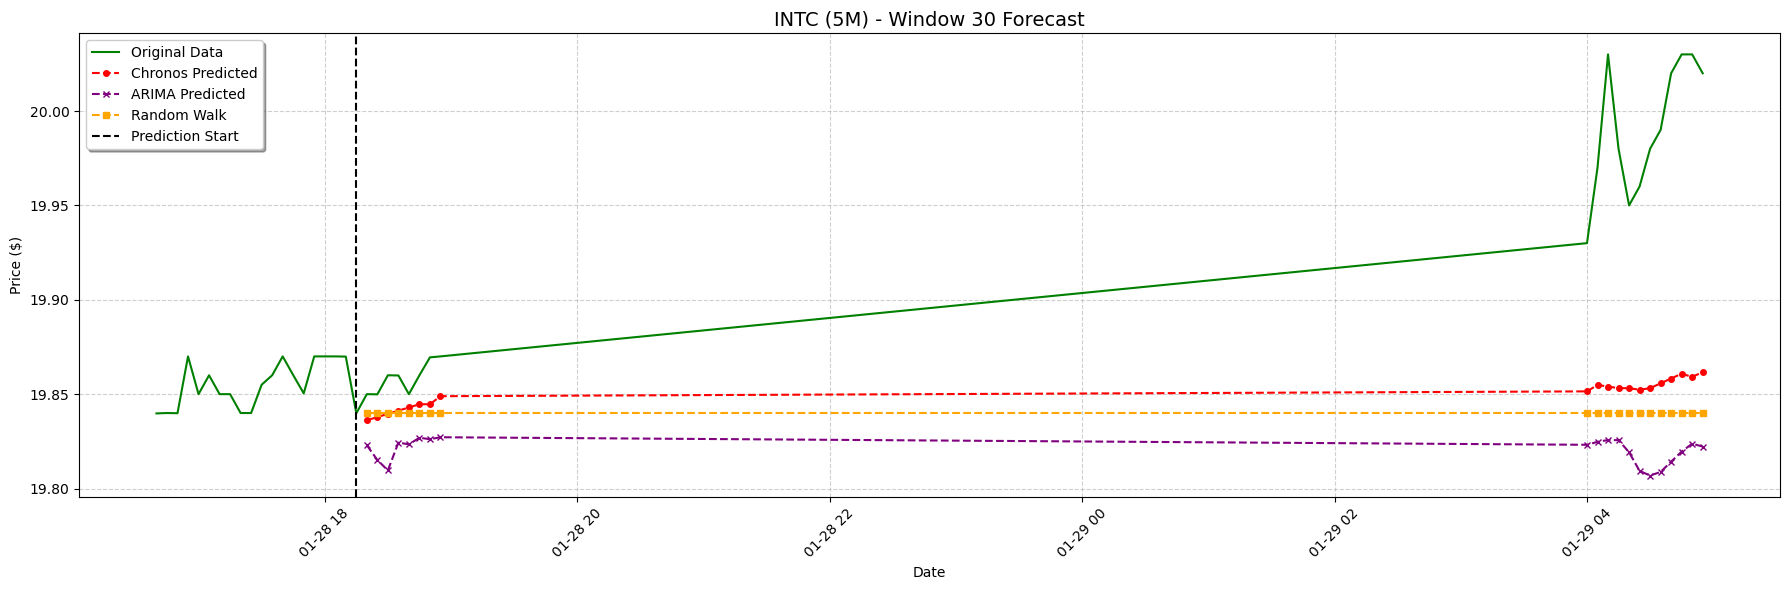

  Chronos - MAE: 0.0878, RMSE: 0.1079
  ARIMA   - MAE: 0.1180, RMSE: 0.1379
  Rand.W. - MAE: 0.0981, RMSE: 0.1204
Processing window 31/50...


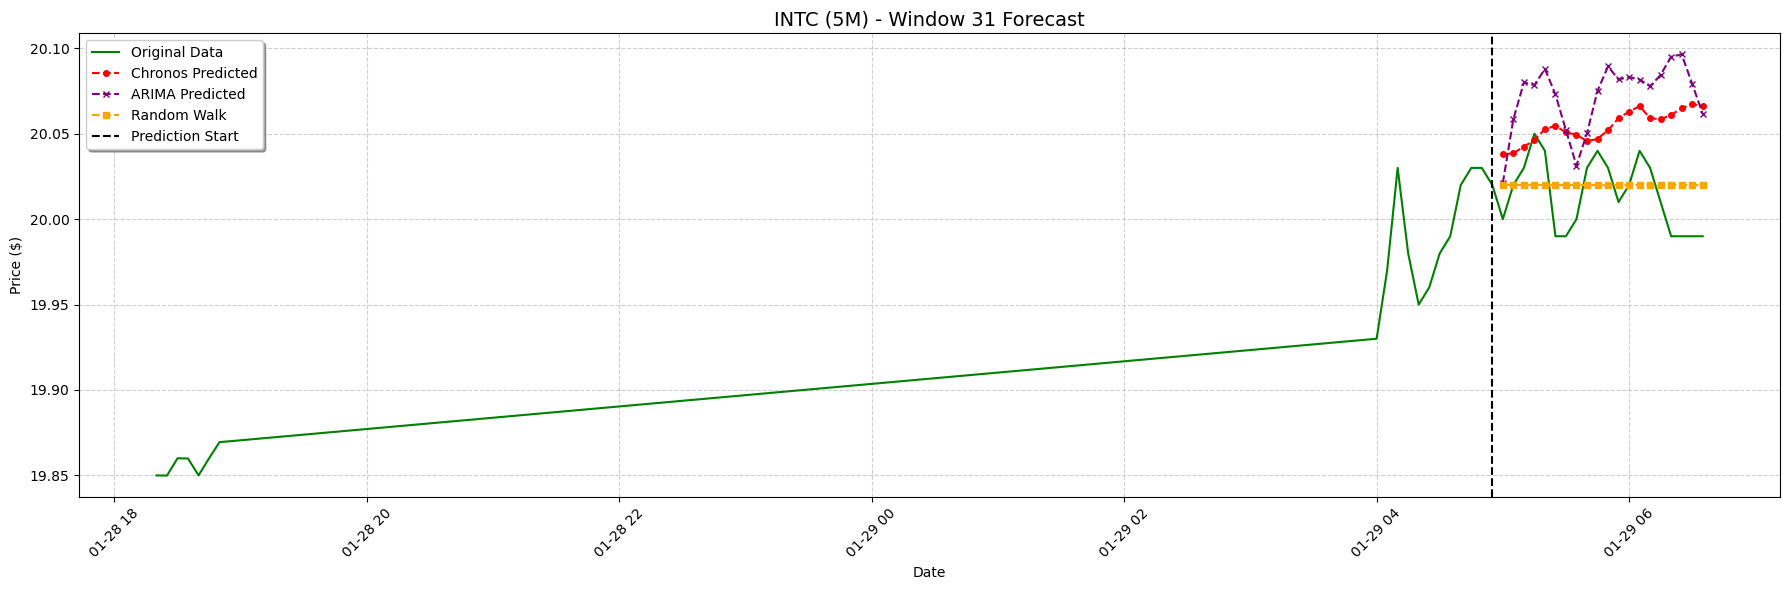

  Chronos - MAE: 0.0400, RMSE: 0.0468
  ARIMA   - MAE: 0.0574, RMSE: 0.0627
  Rand.W. - MAE: 0.0185, RMSE: 0.0211
Processing window 32/50...


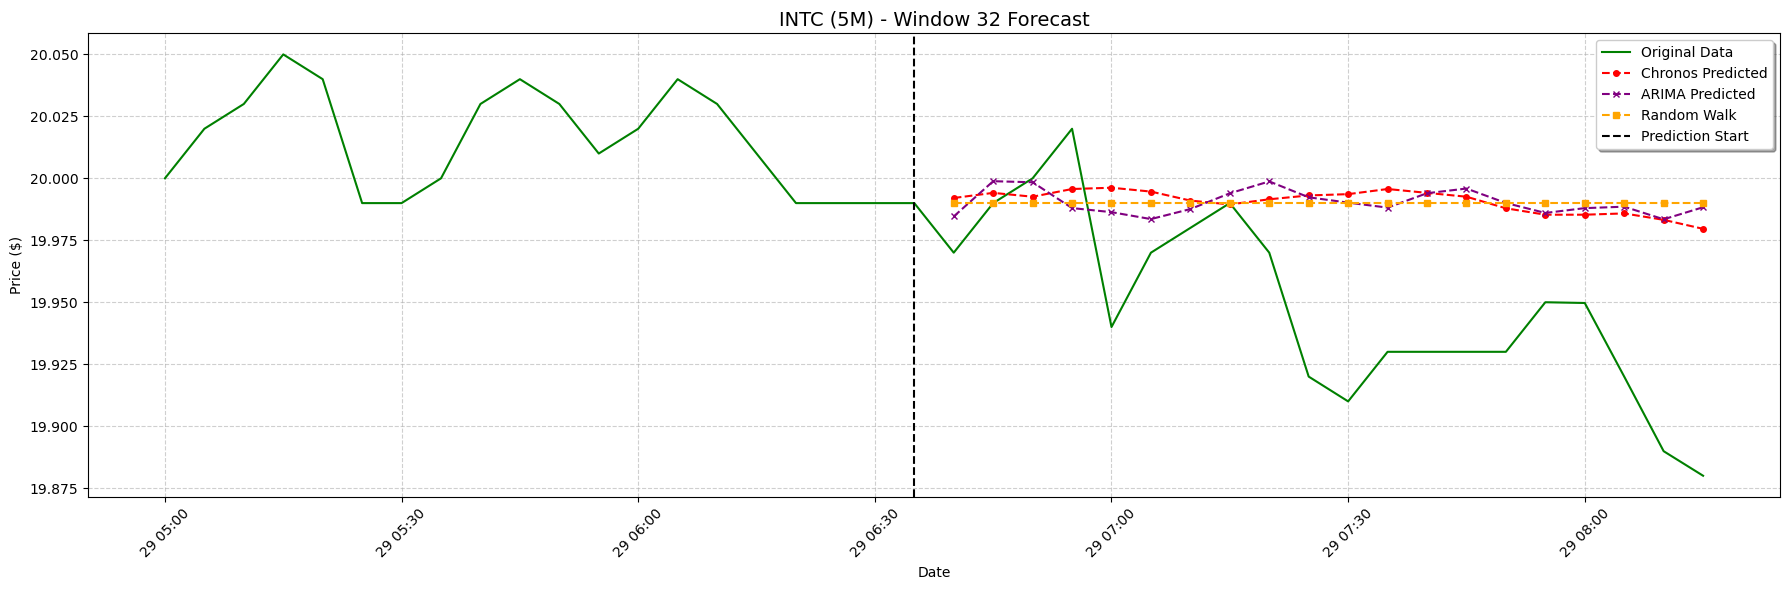

  Chronos - MAE: 0.0454, RMSE: 0.0543
  ARIMA   - MAE: 0.0451, RMSE: 0.0546
  Rand.W. - MAE: 0.0455, RMSE: 0.0551
Processing window 33/50...


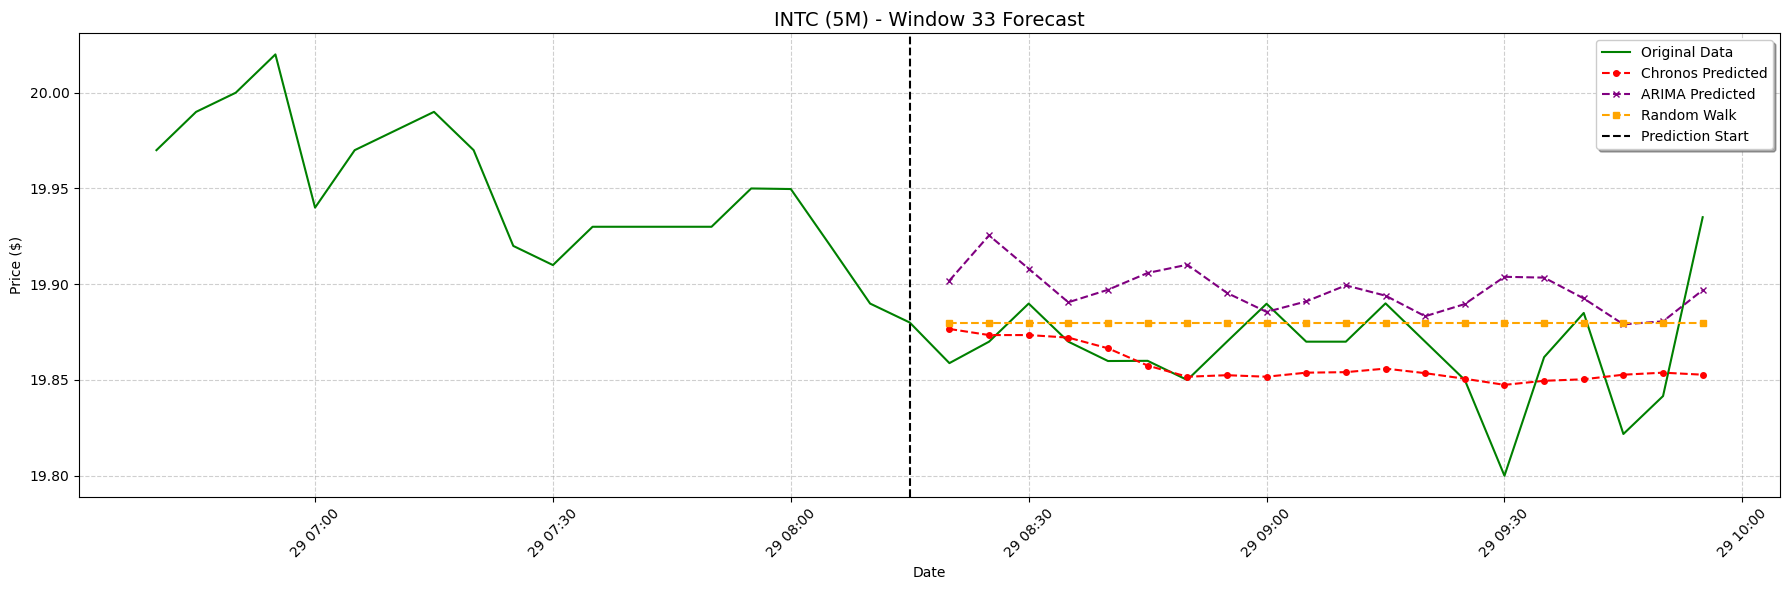

  Chronos - MAE: 0.0205, RMSE: 0.0281
  ARIMA   - MAE: 0.0353, RMSE: 0.0420
  Rand.W. - MAE: 0.0233, RMSE: 0.0305
Processing window 34/50...


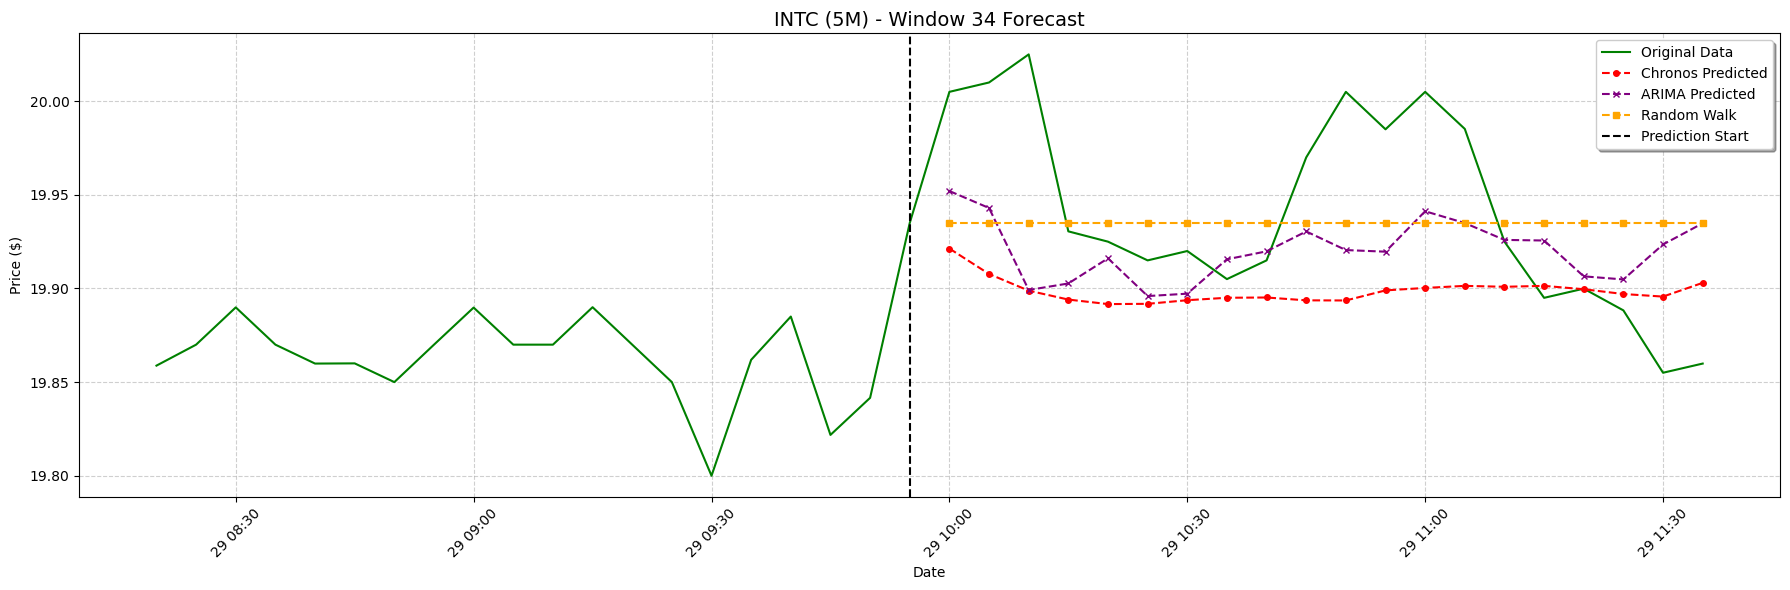

  Chronos - MAE: 0.0523, RMSE: 0.0653
  ARIMA   - MAE: 0.0421, RMSE: 0.0530
  Rand.W. - MAE: 0.0448, RMSE: 0.0519
Processing window 35/50...


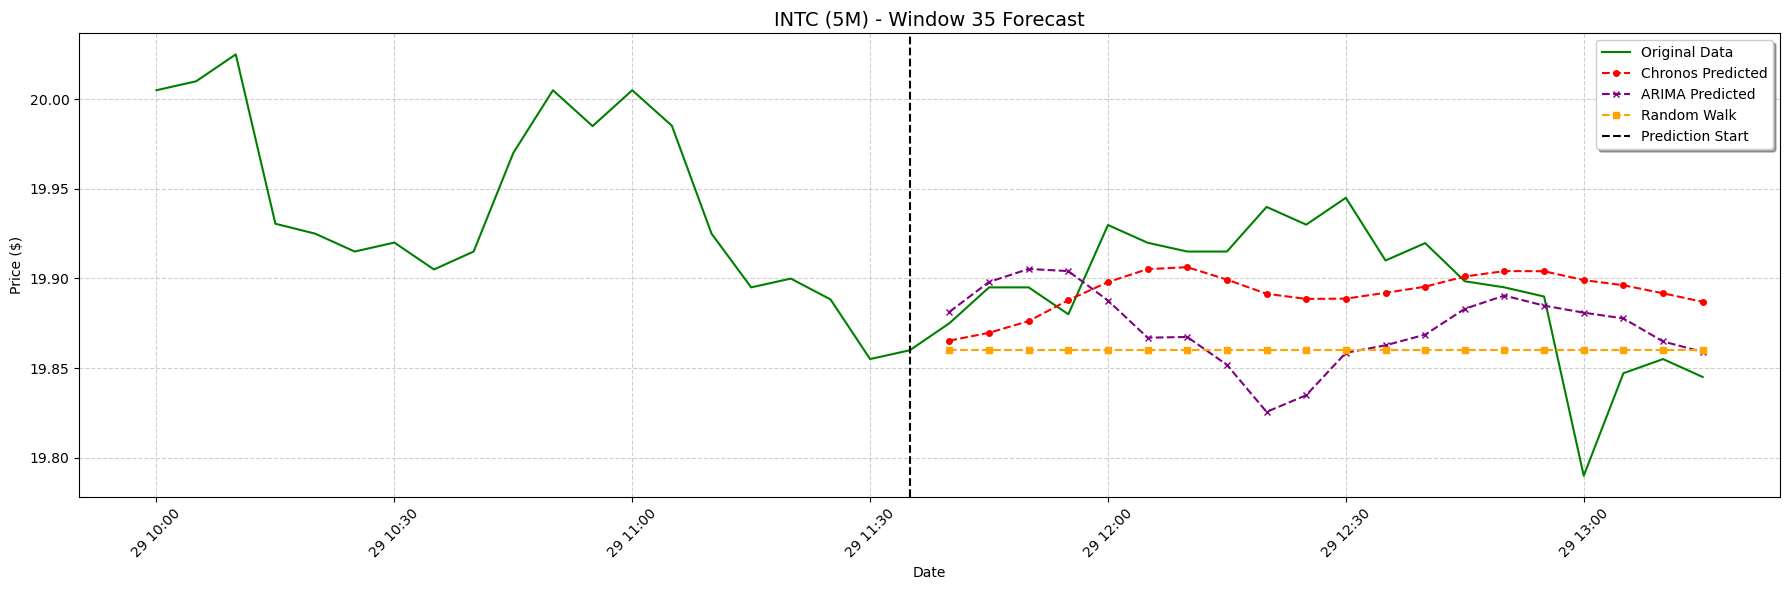

  Chronos - MAE: 0.0292, RMSE: 0.0378
  ARIMA   - MAE: 0.0407, RMSE: 0.0528
  Rand.W. - MAE: 0.0448, RMSE: 0.0506
Processing window 36/50...


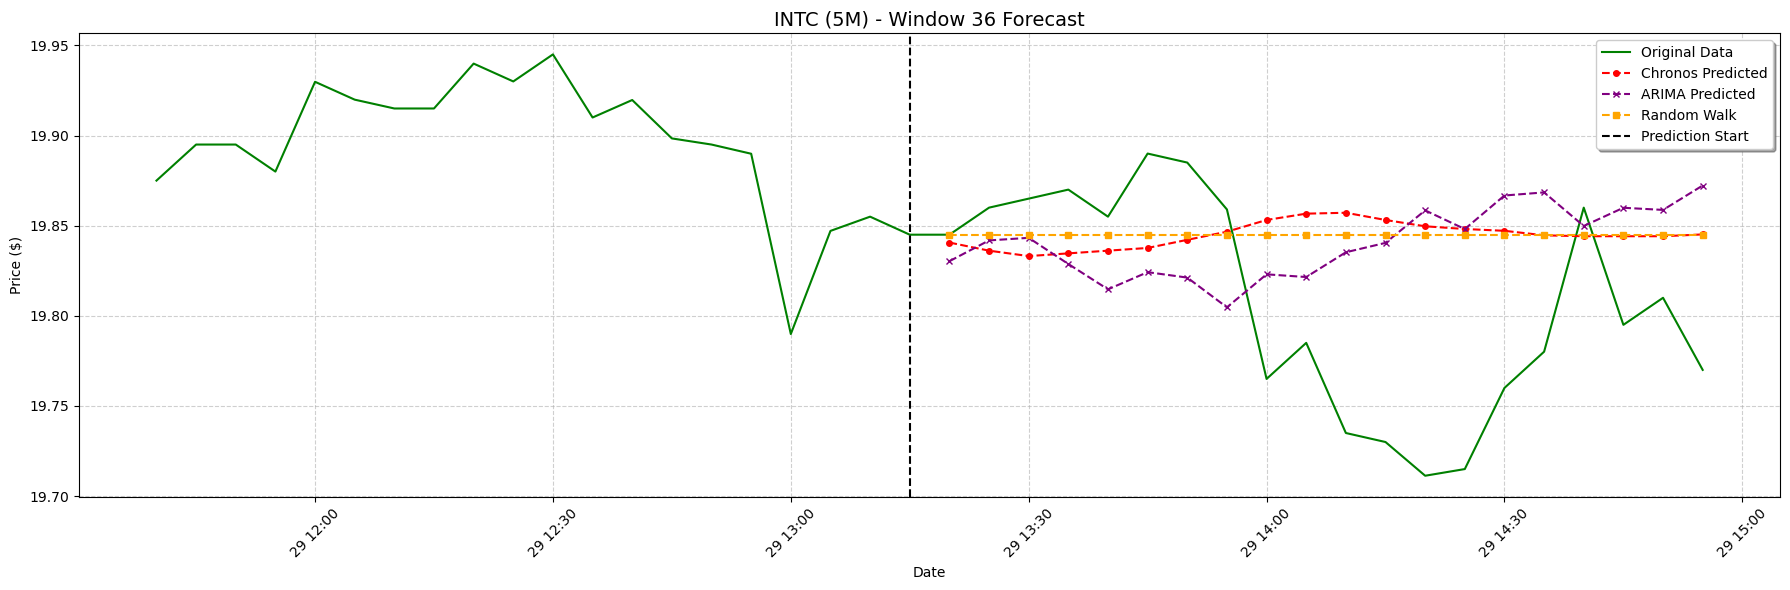

  Chronos - MAE: 0.0612, RMSE: 0.0738
  ARIMA   - MAE: 0.0663, RMSE: 0.0769
  Rand.W. - MAE: 0.0561, RMSE: 0.0694
Processing window 37/50...


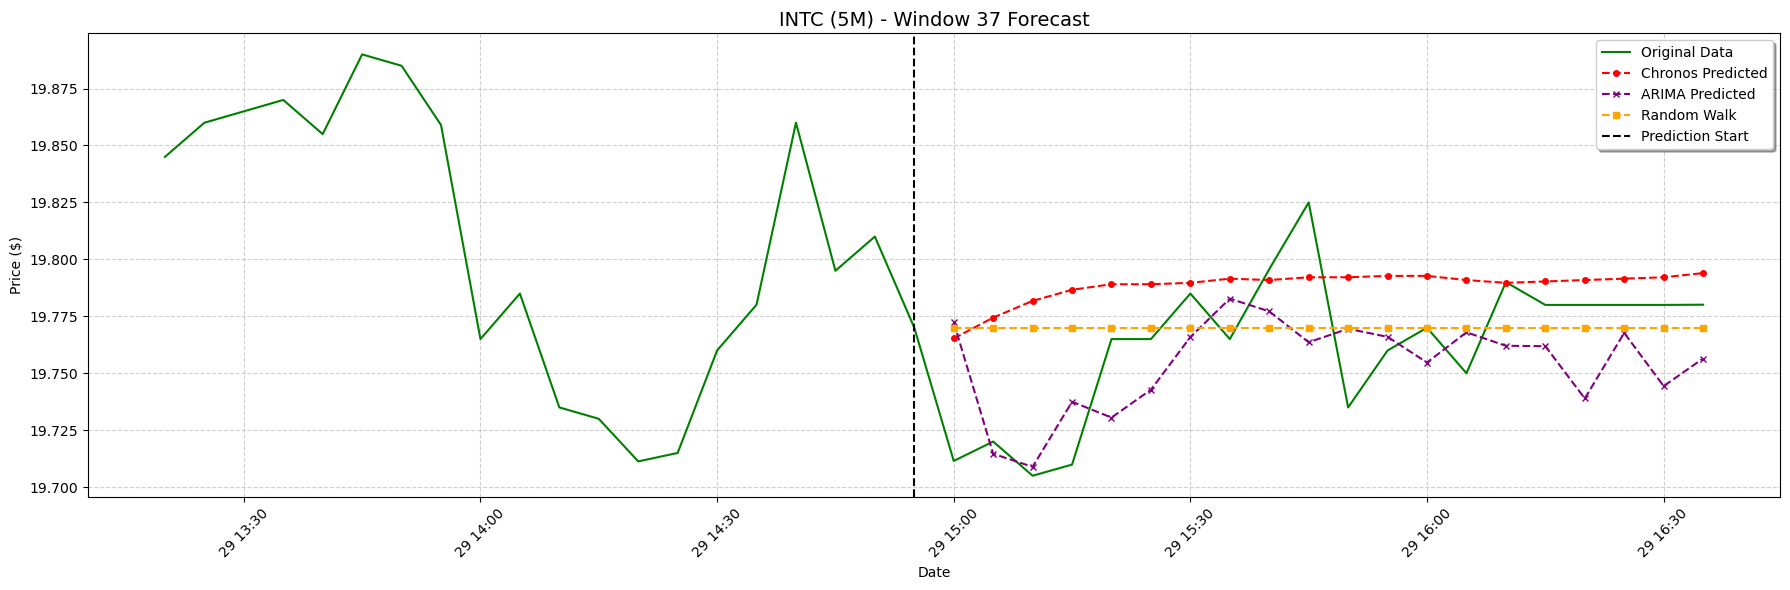

  Chronos - MAE: 0.0296, RMSE: 0.0373
  ARIMA   - MAE: 0.0252, RMSE: 0.0296
  Rand.W. - MAE: 0.0240, RMSE: 0.0319
Processing window 38/50...


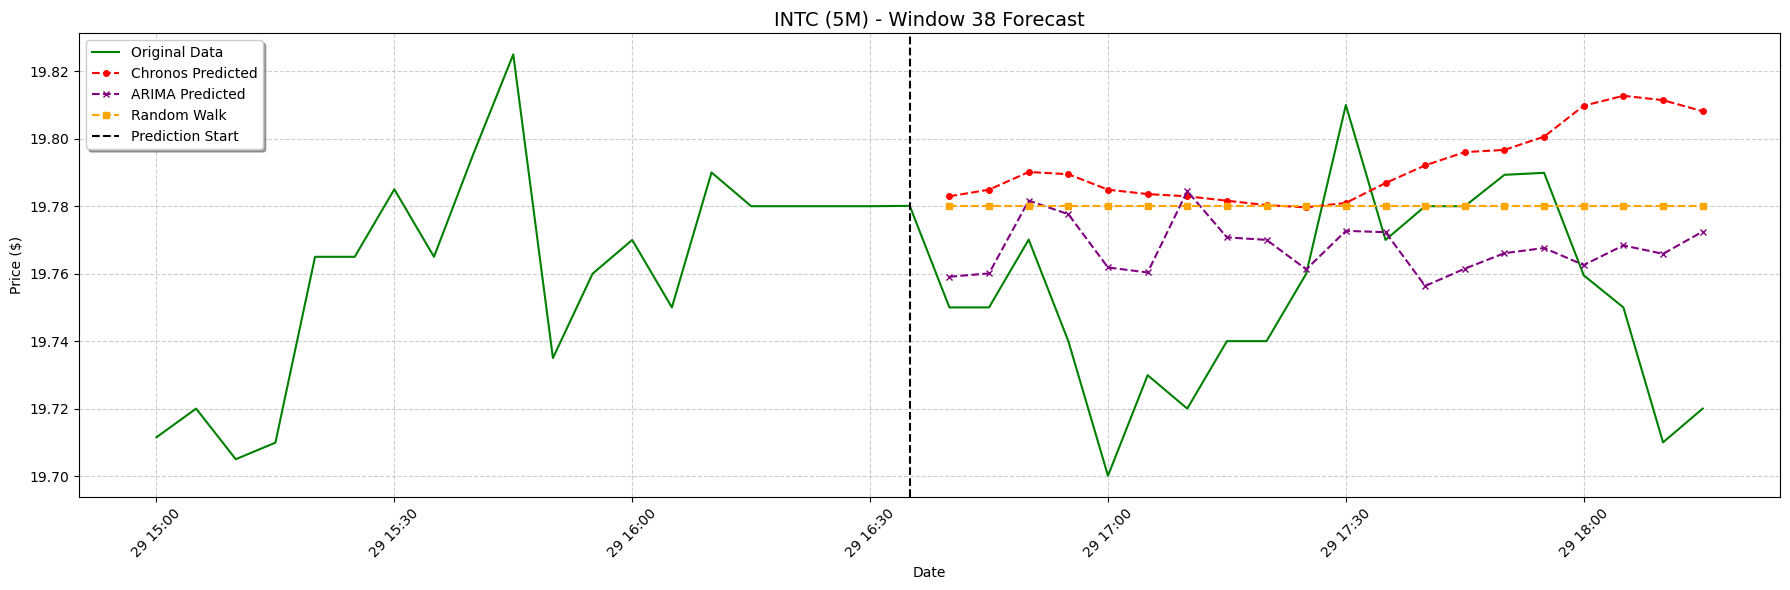

  Chronos - MAE: 0.0418, RMSE: 0.0496
  ARIMA   - MAE: 0.0272, RMSE: 0.0332
  Rand.W. - MAE: 0.0320, RMSE: 0.0392
Processing window 39/50...


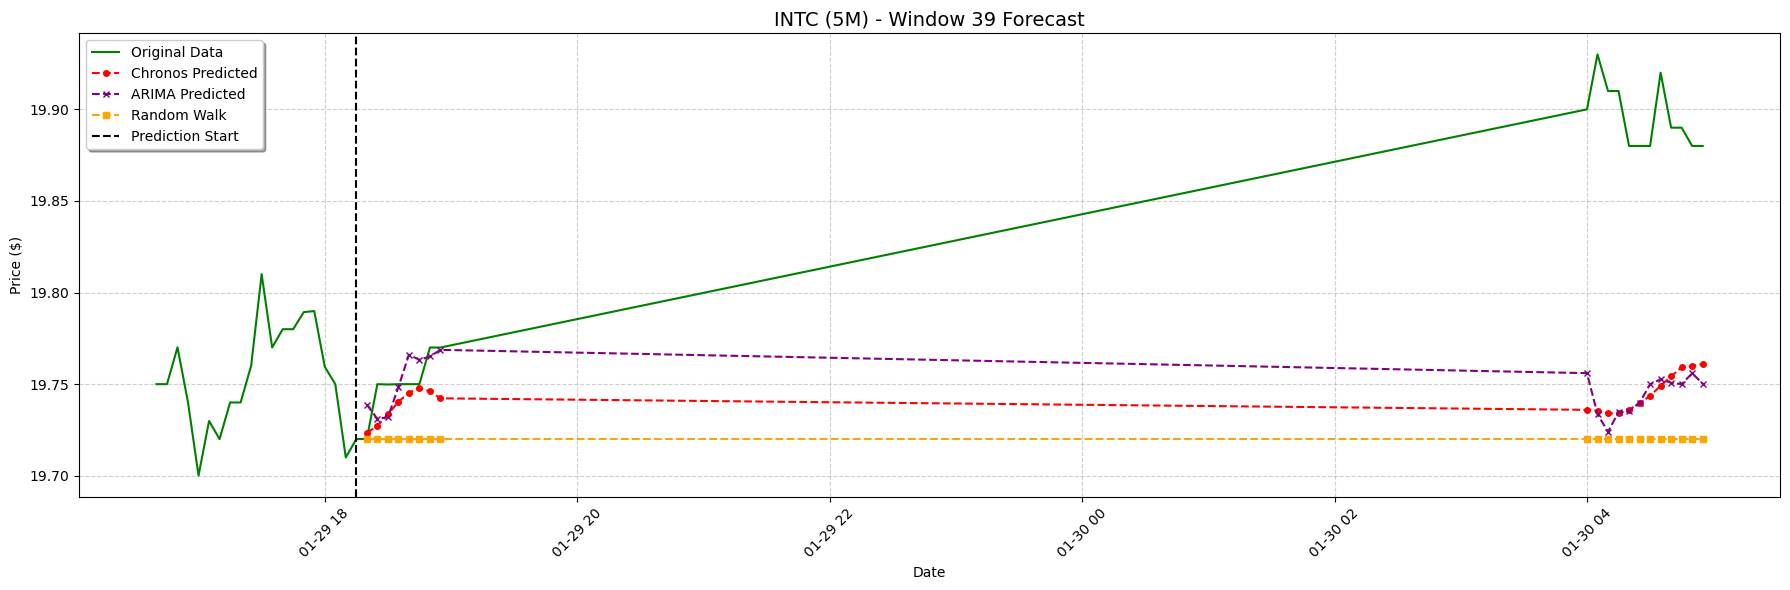

  Chronos - MAE: 0.0959, RMSE: 0.1186
  ARIMA   - MAE: 0.0955, RMSE: 0.1189
  Rand.W. - MAE: 0.1180, RMSE: 0.1386
Processing window 40/50...


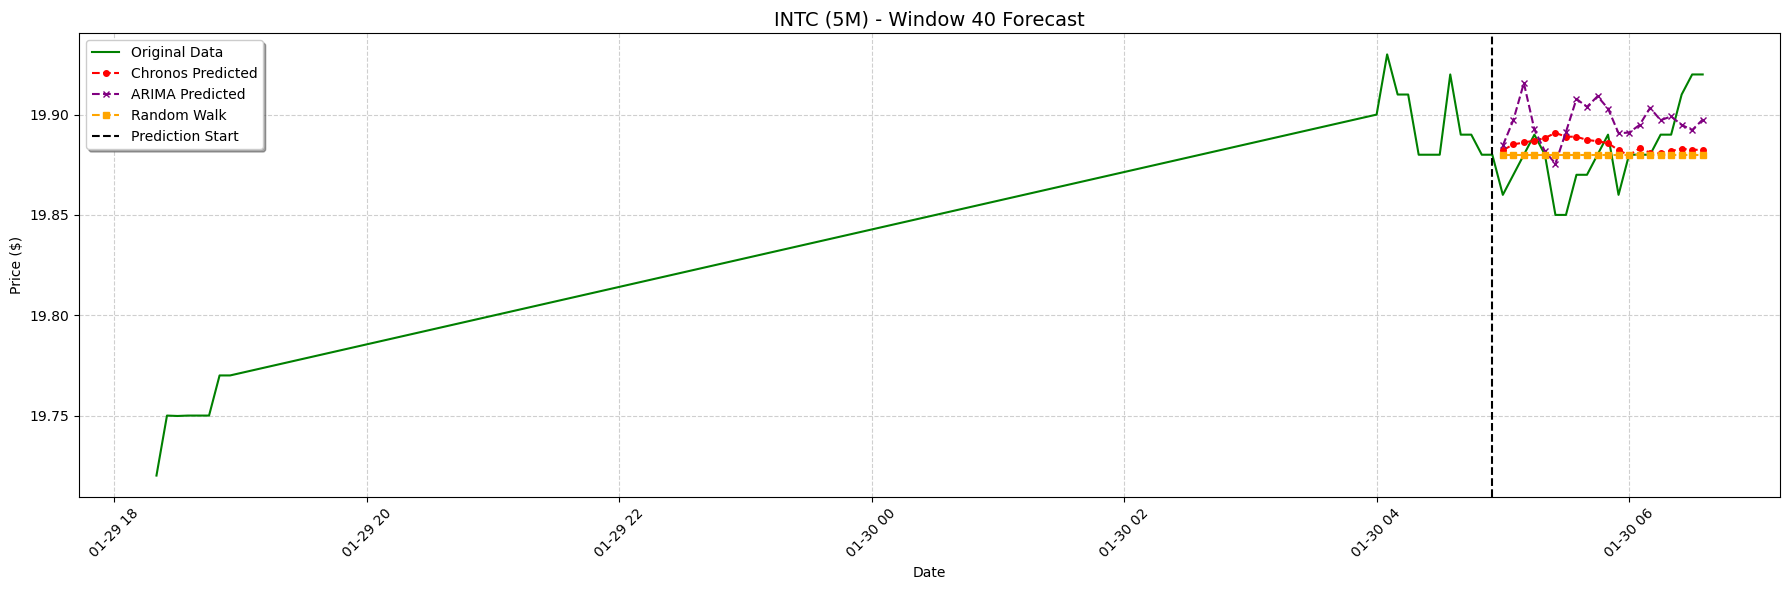

  Chronos - MAE: 0.0164, RMSE: 0.0212
  ARIMA   - MAE: 0.0217, RMSE: 0.0246
  Rand.W. - MAE: 0.0140, RMSE: 0.0192
Processing window 41/50...


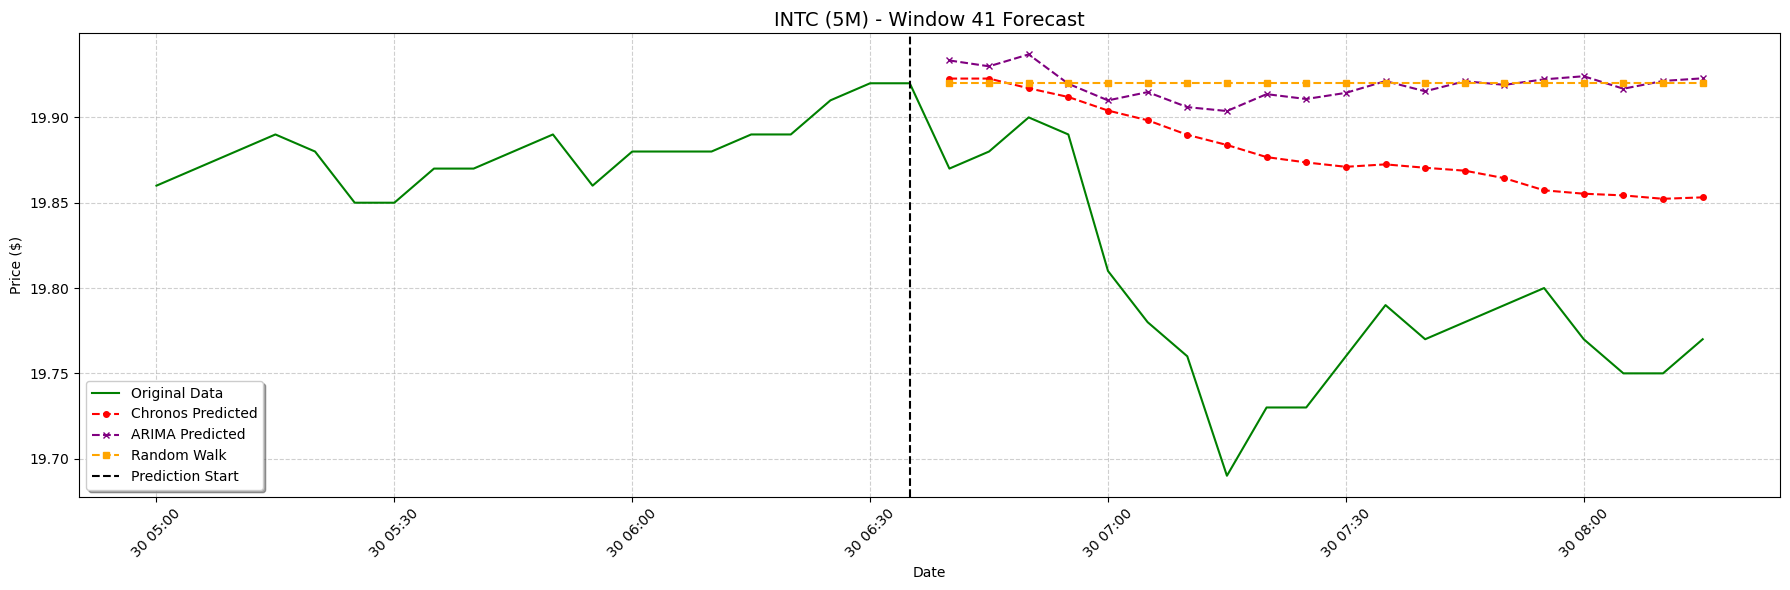

  Chronos - MAE: 0.0925, RMSE: 0.1015
  ARIMA   - MAE: 0.1304, RMSE: 0.1394
  Rand.W. - MAE: 0.1315, RMSE: 0.1426
Processing window 42/50...


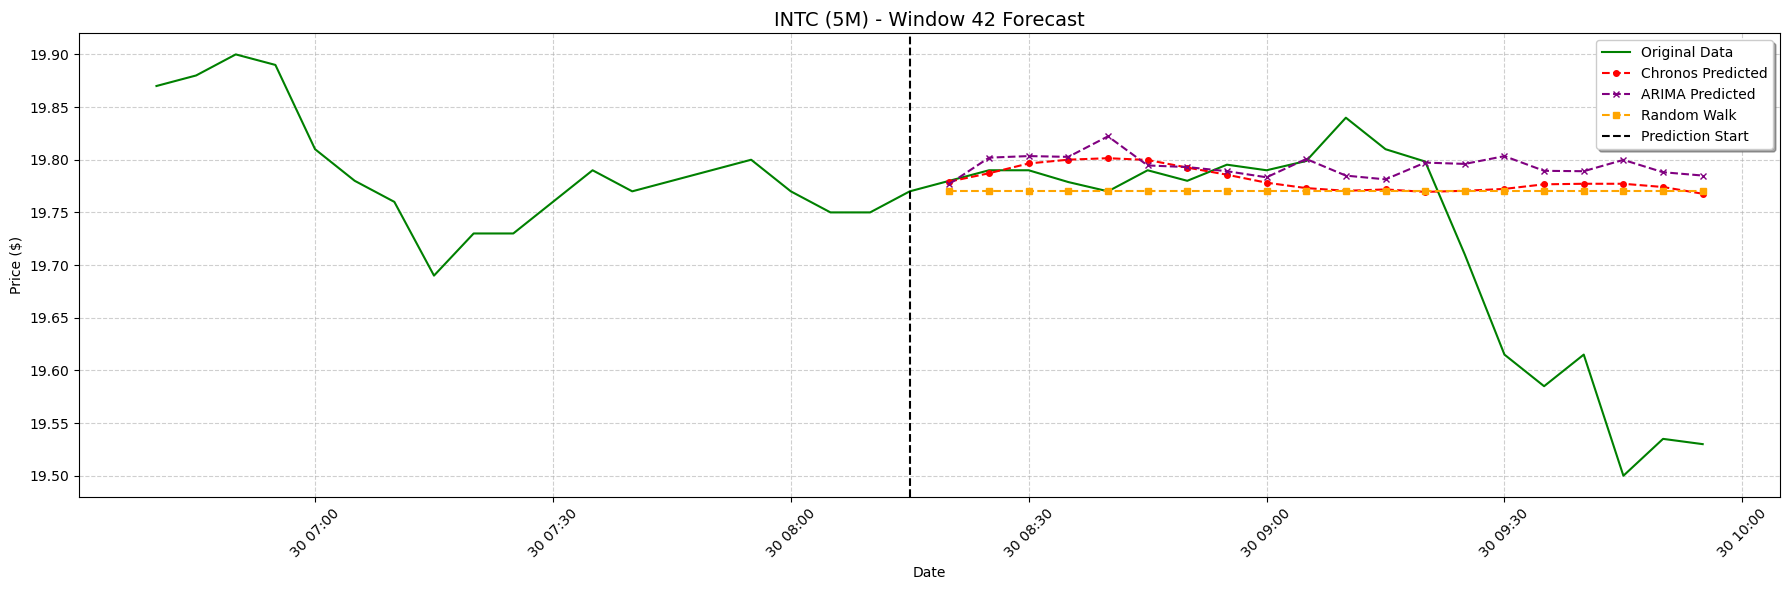

  Chronos - MAE: 0.0797, RMSE: 0.1208
  ARIMA   - MAE: 0.0841, RMSE: 0.1307
  Rand.W. - MAE: 0.0801, RMSE: 0.1188
Processing window 43/50...


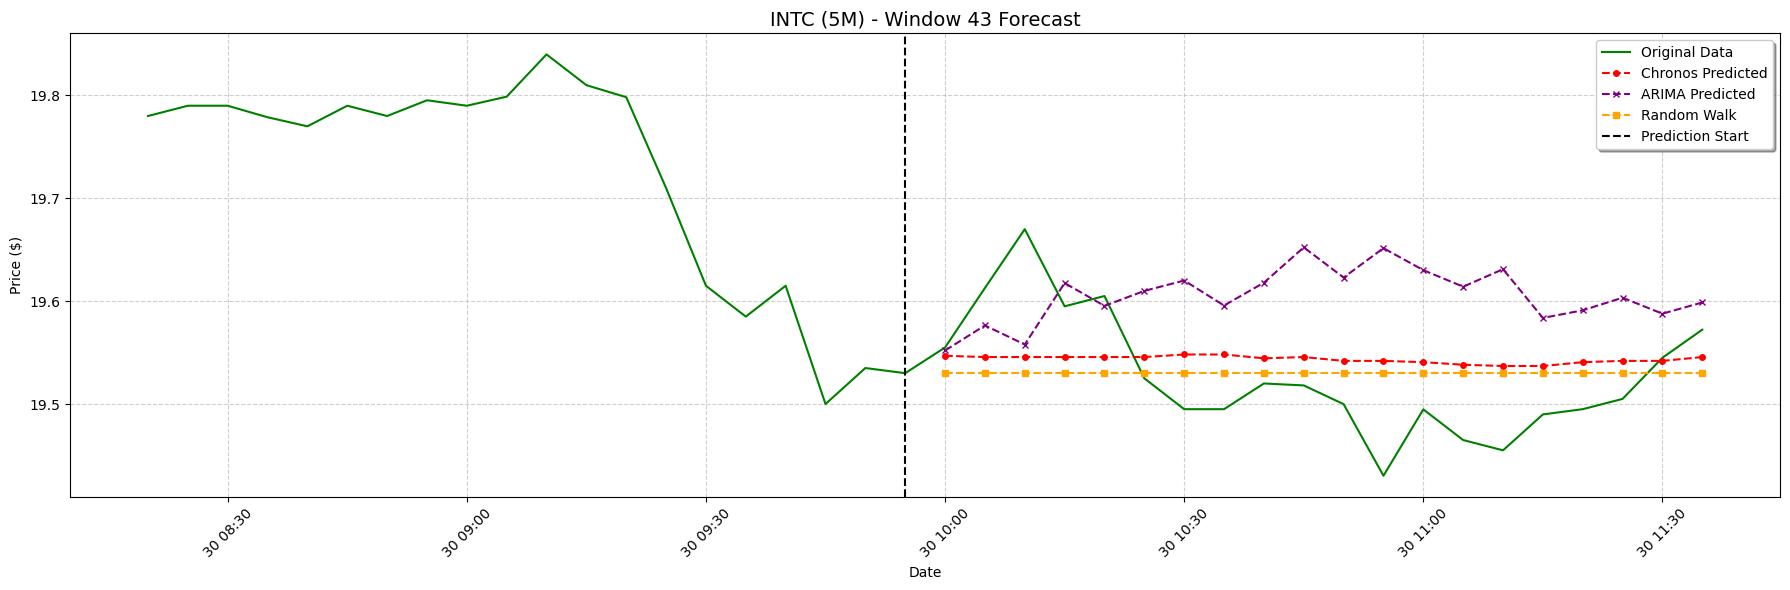

  Chronos - MAE: 0.0501, RMSE: 0.0584
  ARIMA   - MAE: 0.0945, RMSE: 0.1098
  Rand.W. - MAE: 0.0474, RMSE: 0.0579
Processing window 44/50...


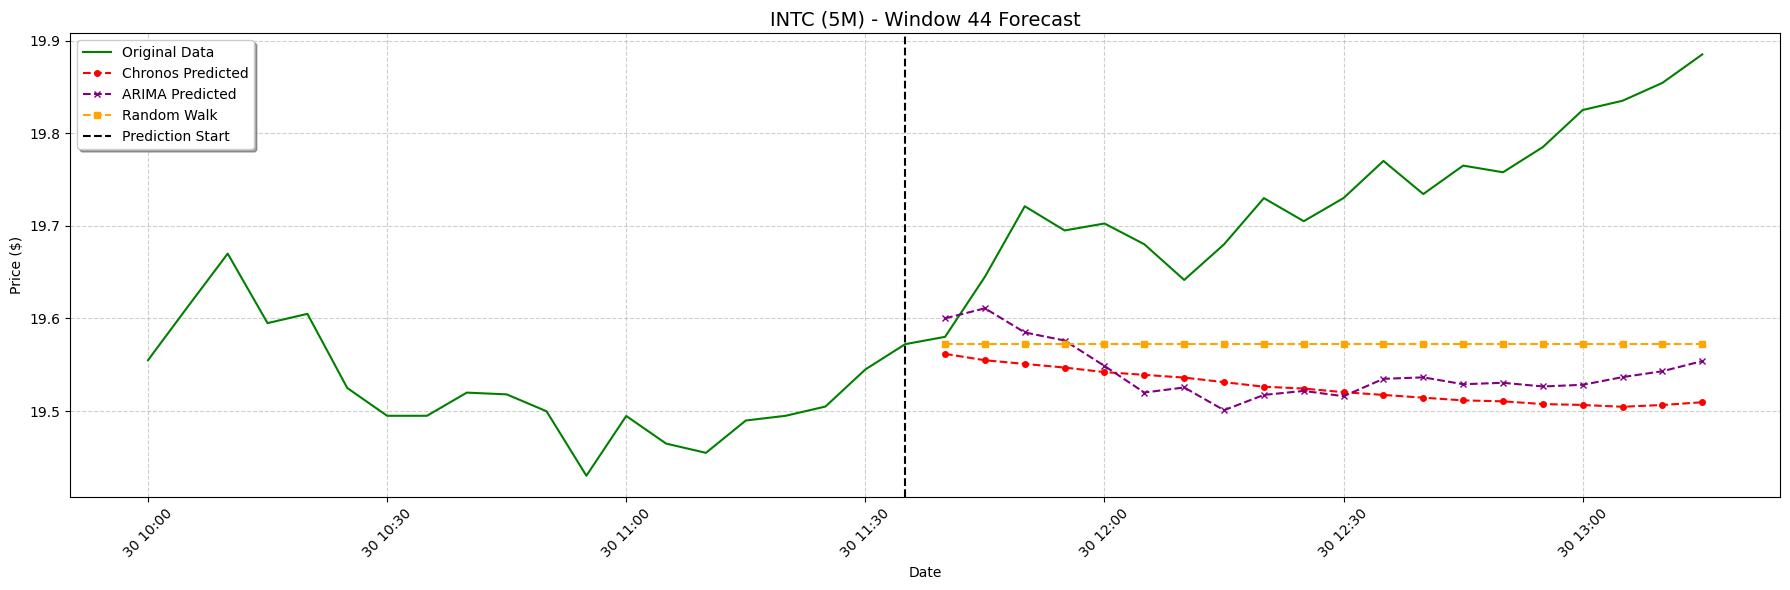

  Chronos - MAE: 0.2099, RMSE: 0.2283
  ARIMA   - MAE: 0.1959, RMSE: 0.2127
  Rand.W. - MAE: 0.1638, RMSE: 0.1799
Processing window 45/50...


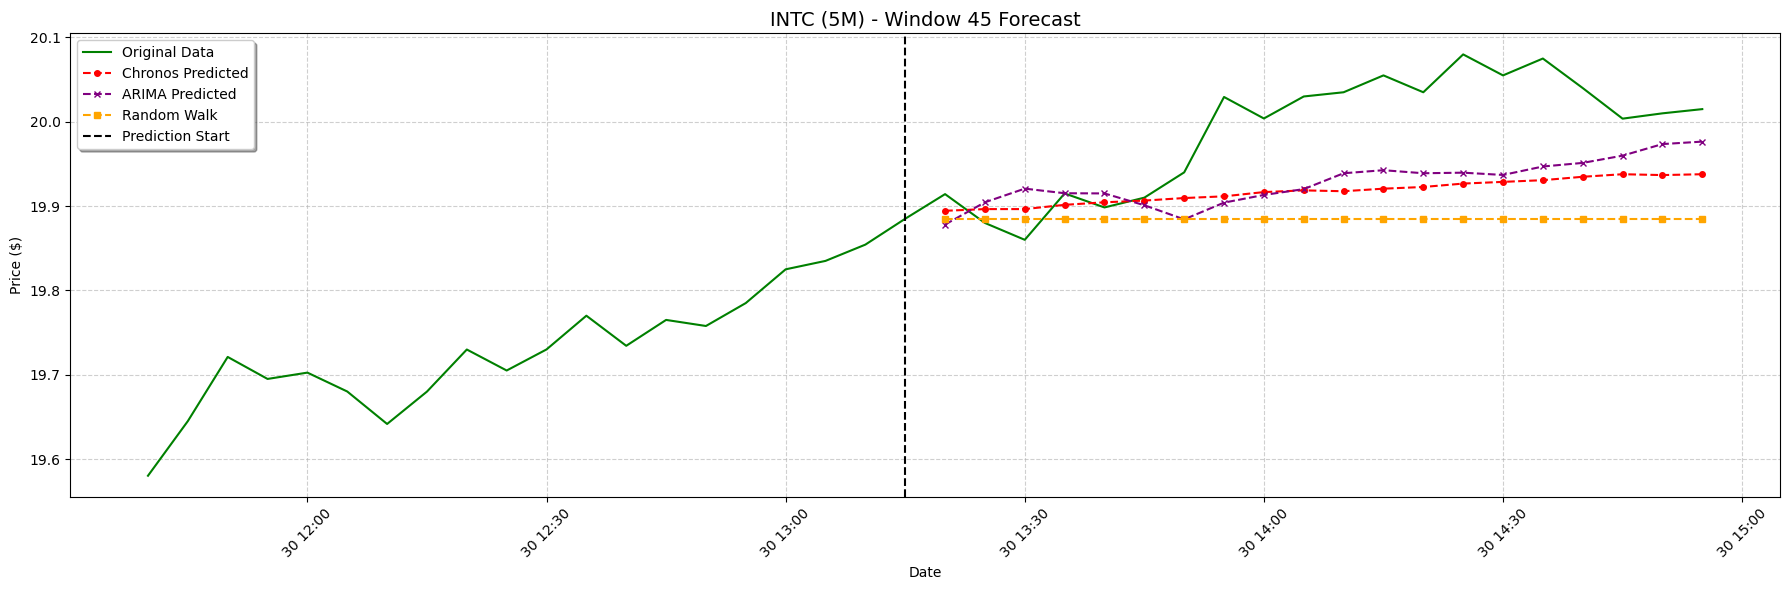

  Chronos - MAE: 0.0776, RMSE: 0.0918
  ARIMA   - MAE: 0.0714, RMSE: 0.0833
  Rand.W. - MAE: 0.1072, RMSE: 0.1245
Processing window 46/50...


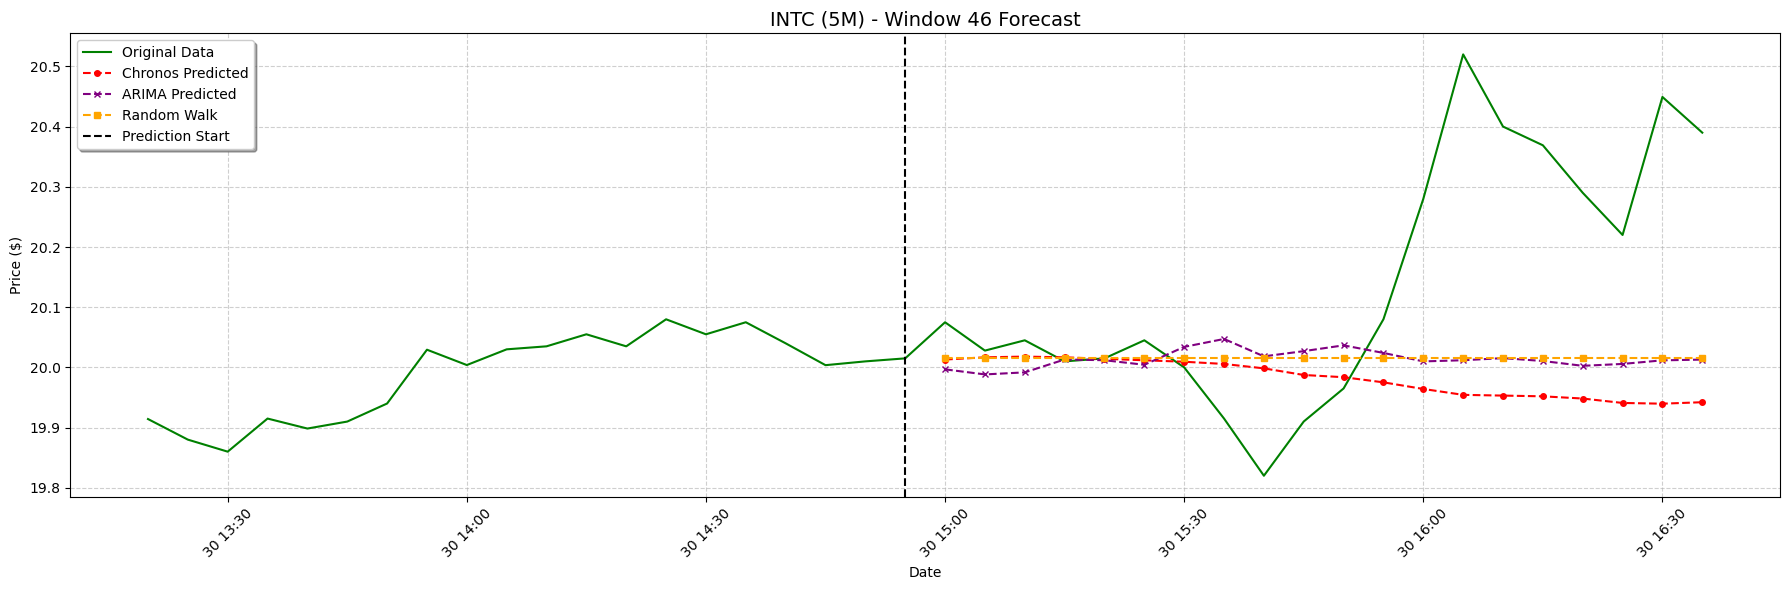

  Chronos - MAE: 0.1972, RMSE: 0.2749
  ARIMA   - MAE: 0.1832, RMSE: 0.2410
  Rand.W. - MAE: 0.1733, RMSE: 0.2364
Processing window 47/50...


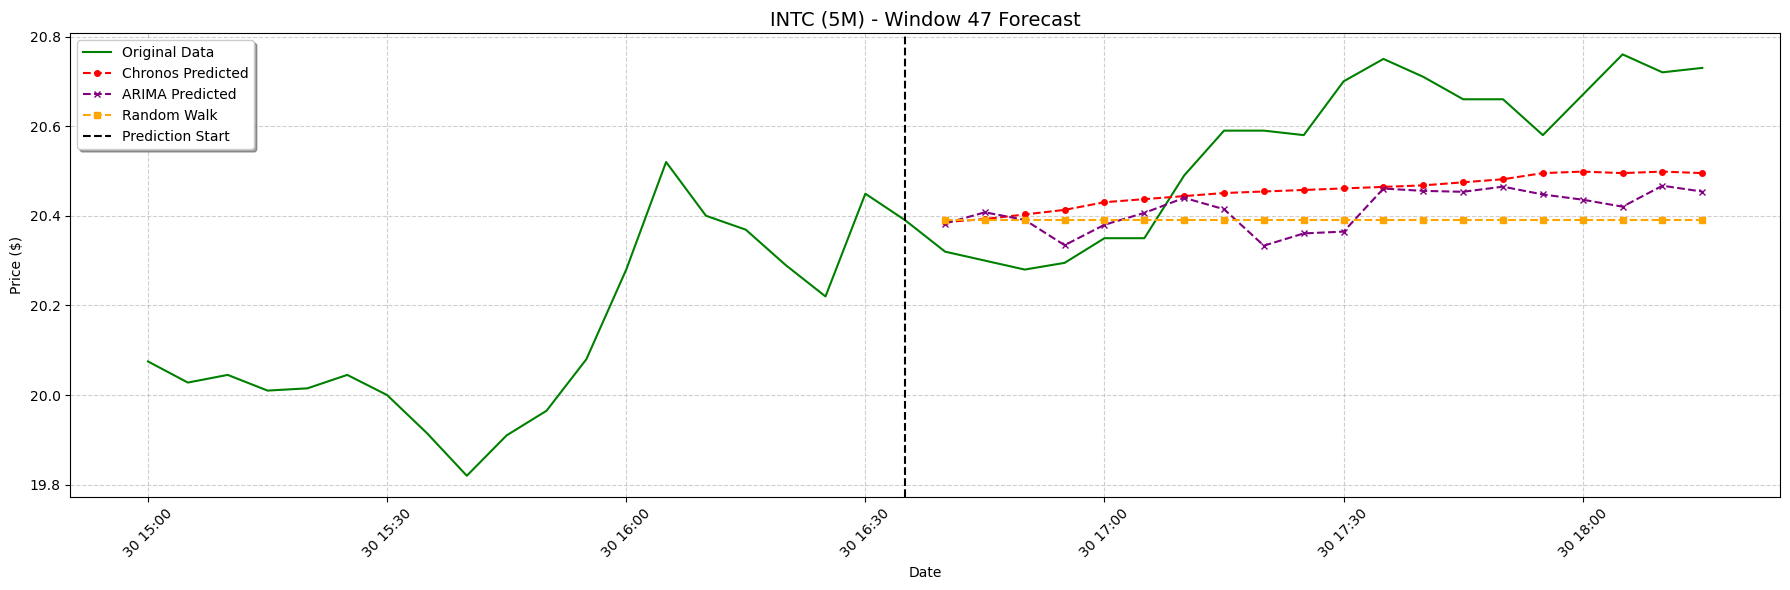

  Chronos - MAE: 0.1559, RMSE: 0.1711
  ARIMA   - MAE: 0.1812, RMSE: 0.2062
  Rand.W. - MAE: 0.2088, RMSE: 0.2359
Processing window 48/50...


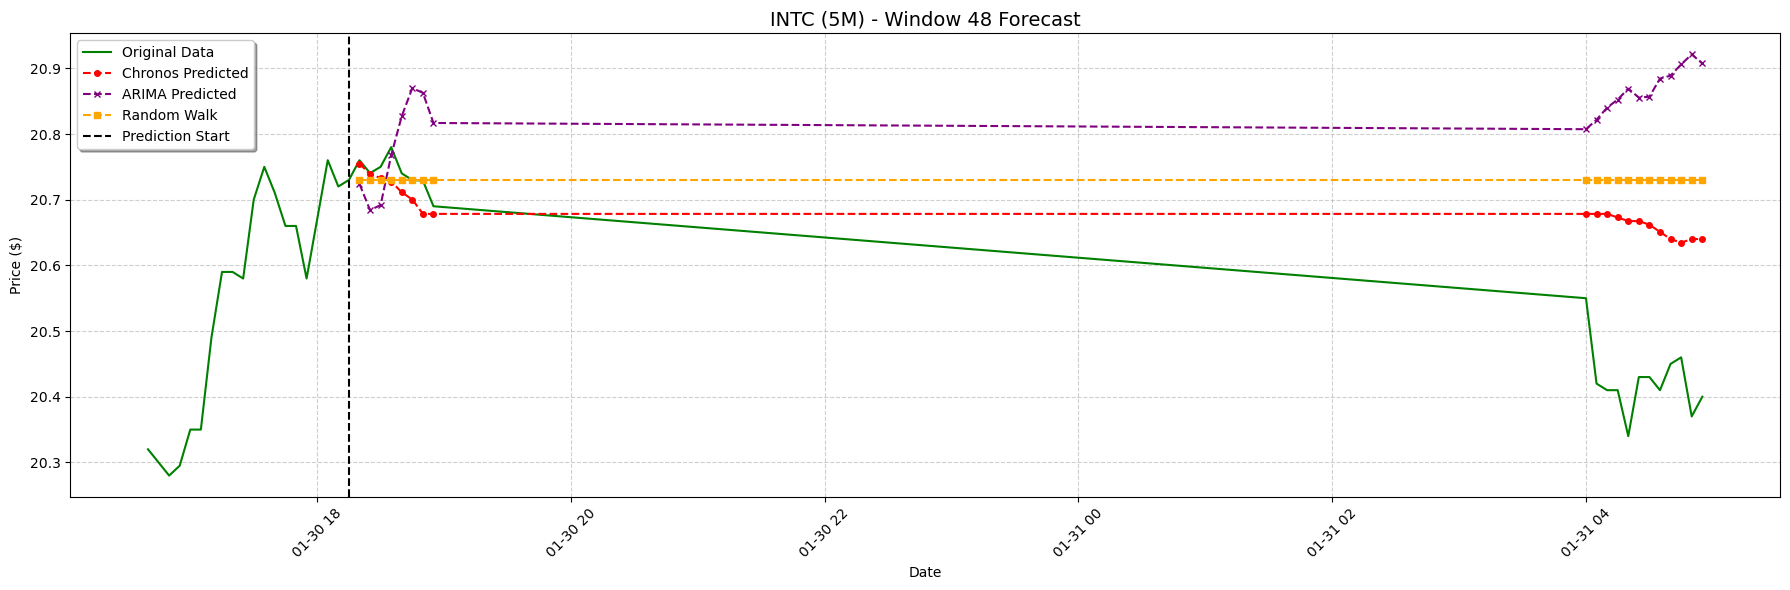

  Chronos - MAE: 0.1514, RMSE: 0.1877
  ARIMA   - MAE: 0.2991, RMSE: 0.3534
  Rand.W. - MAE: 0.1921, RMSE: 0.2412
Processing window 49/50...


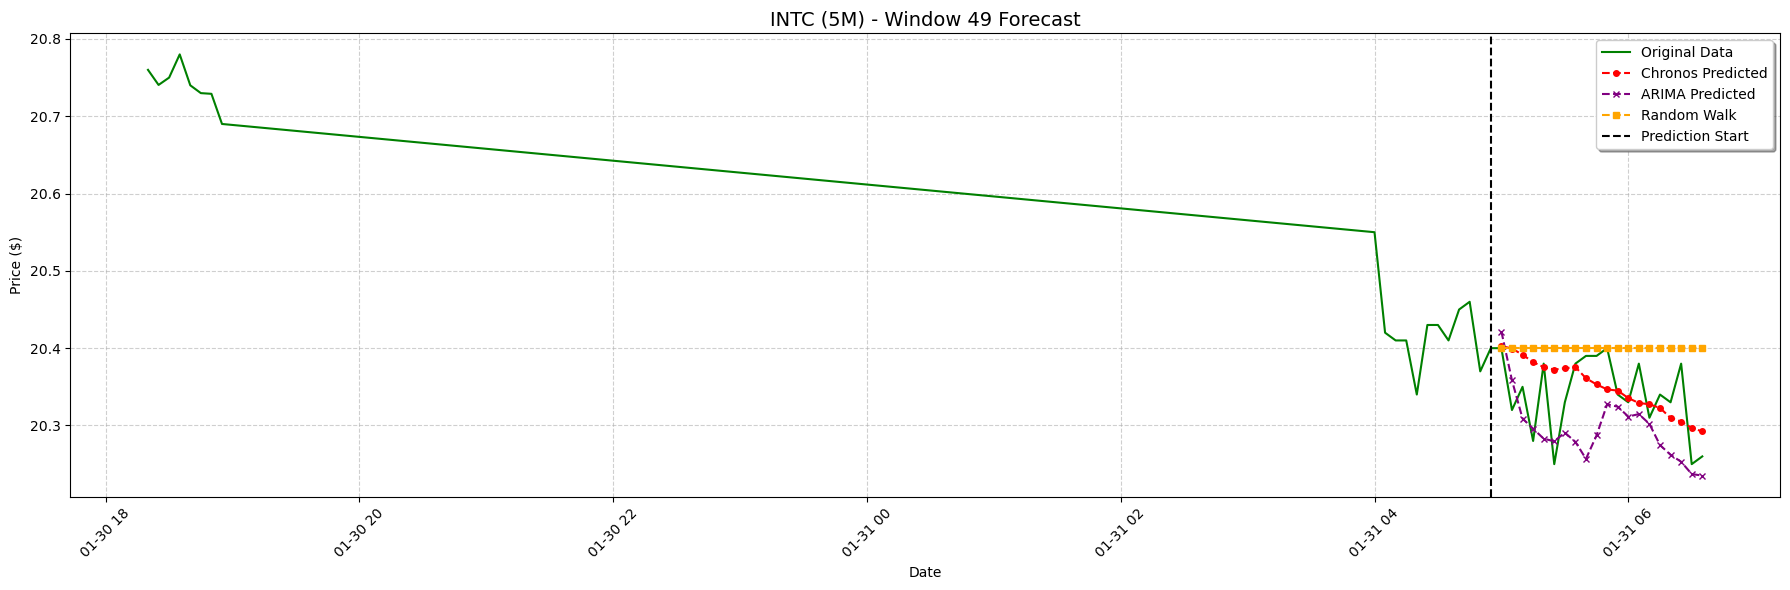

  Chronos - MAE: 0.0395, RMSE: 0.0515
  ARIMA   - MAE: 0.0549, RMSE: 0.0672
  Rand.W. - MAE: 0.0605, RMSE: 0.0774
Processing window 50/50...


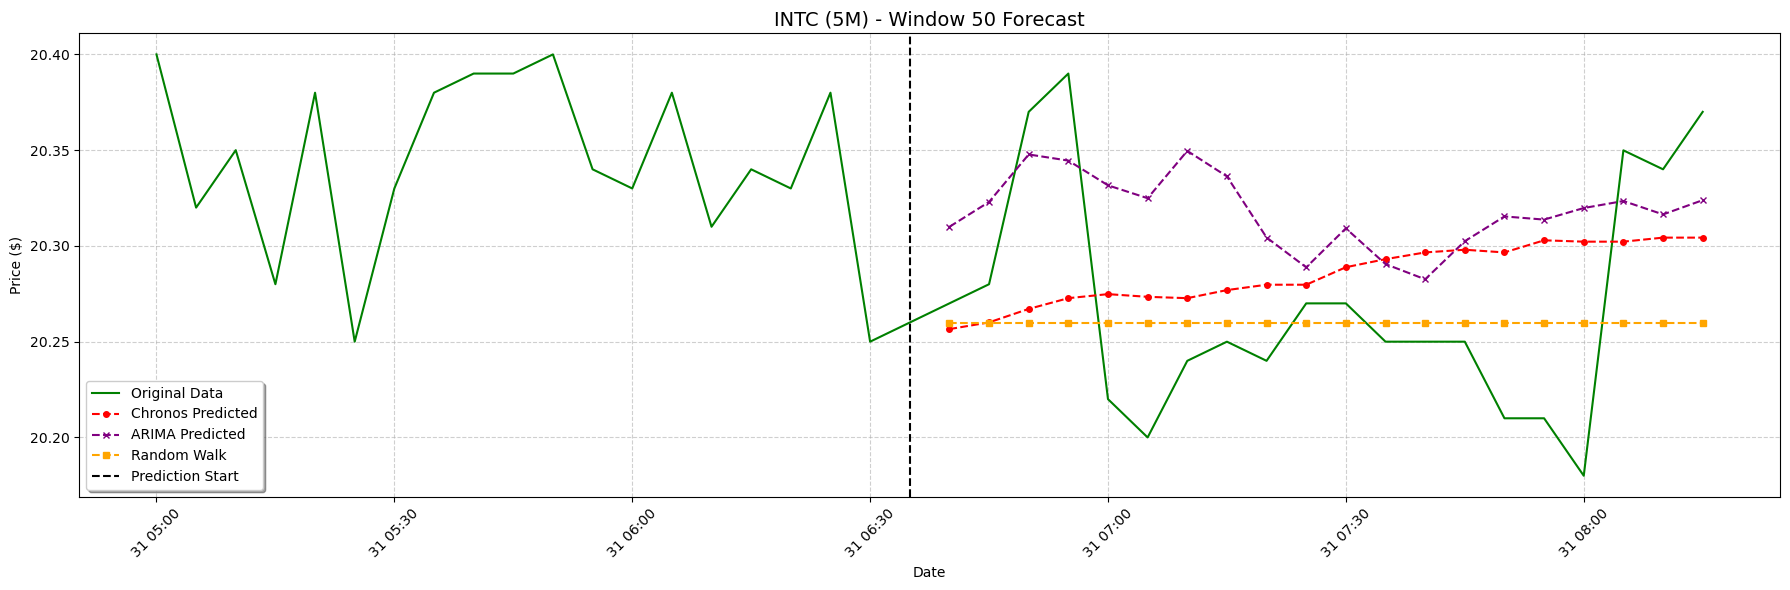

  Chronos - MAE: 0.0549, RMSE: 0.0642
  ARIMA   - MAE: 0.0638, RMSE: 0.0741
  Rand.W. - MAE: 0.0465, RMSE: 0.0609
Finished processing INTC dataset.

Processing IONQ_5M.csv...
Processing IONQ dataset with 5M interval...
Processing window 1/50...


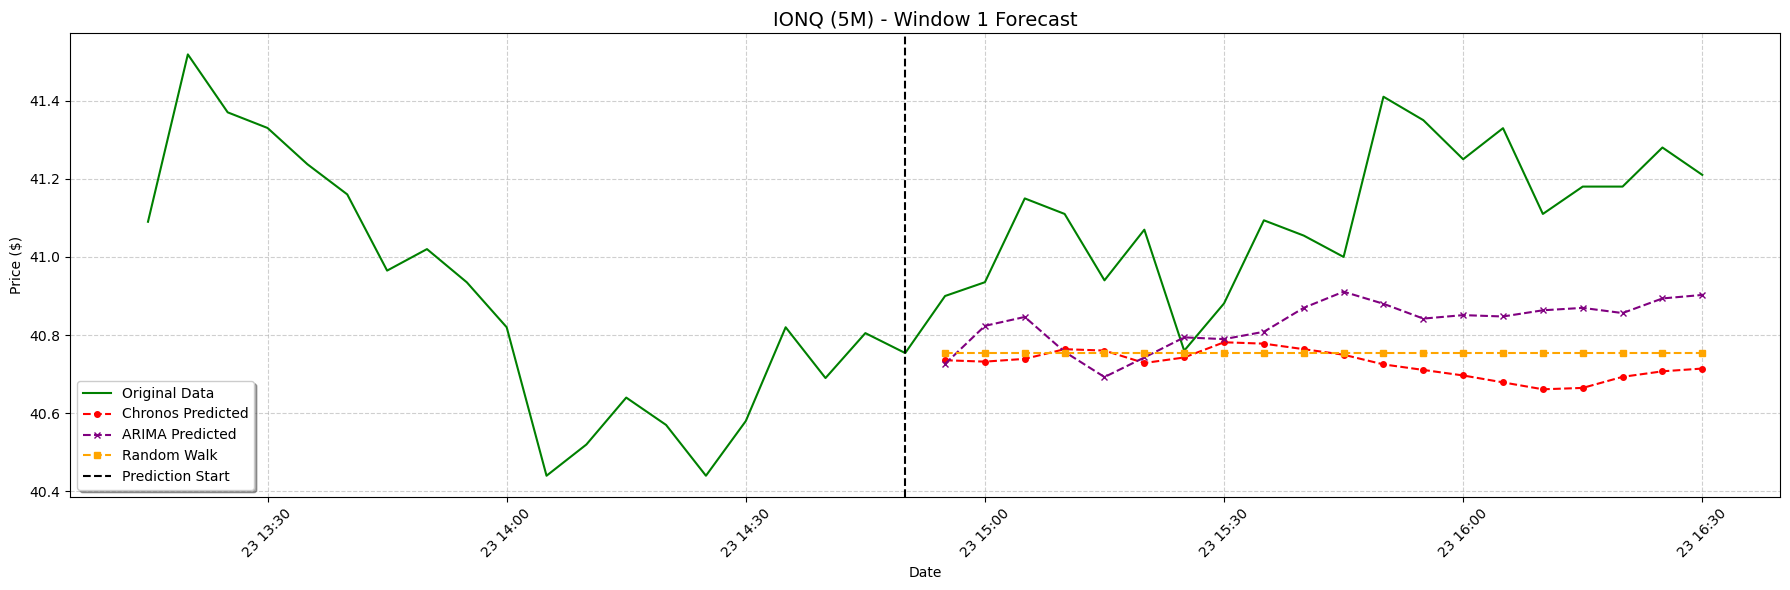

  Chronos - MAE: 0.3833, RMSE: 0.4271
  ARIMA   - MAE: 0.2847, RMSE: 0.3159
  Rand.W. - MAE: 0.3557, RMSE: 0.3931
Processing window 2/50...


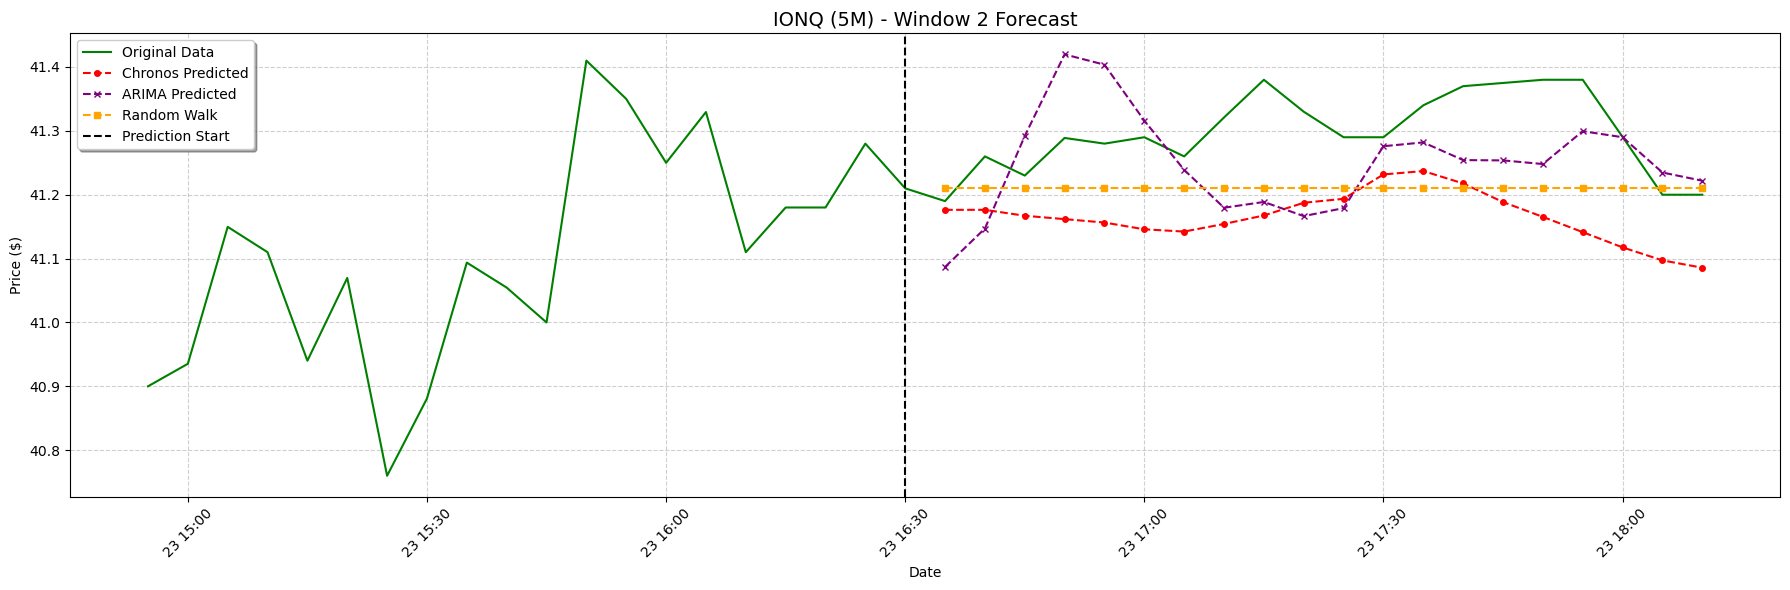

  Chronos - MAE: 0.1317, RMSE: 0.1429
  ARIMA   - MAE: 0.0883, RMSE: 0.1033
  Rand.W. - MAE: 0.0913, RMSE: 0.1063
Processing window 3/50...


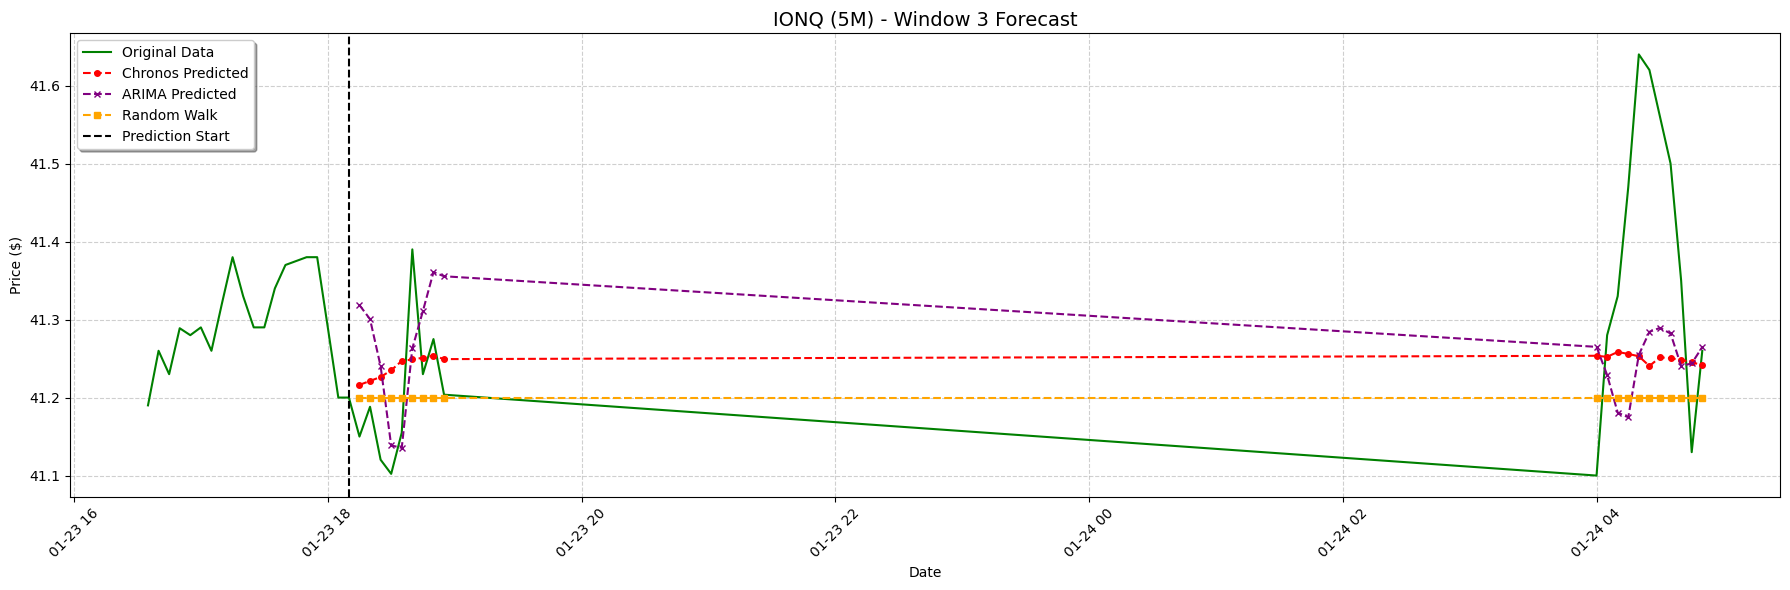

  Chronos - MAE: 0.1343, RMSE: 0.1755
  ARIMA   - MAE: 0.1500, RMSE: 0.1811
  Rand.W. - MAE: 0.1481, RMSE: 0.1987
Processing window 4/50...


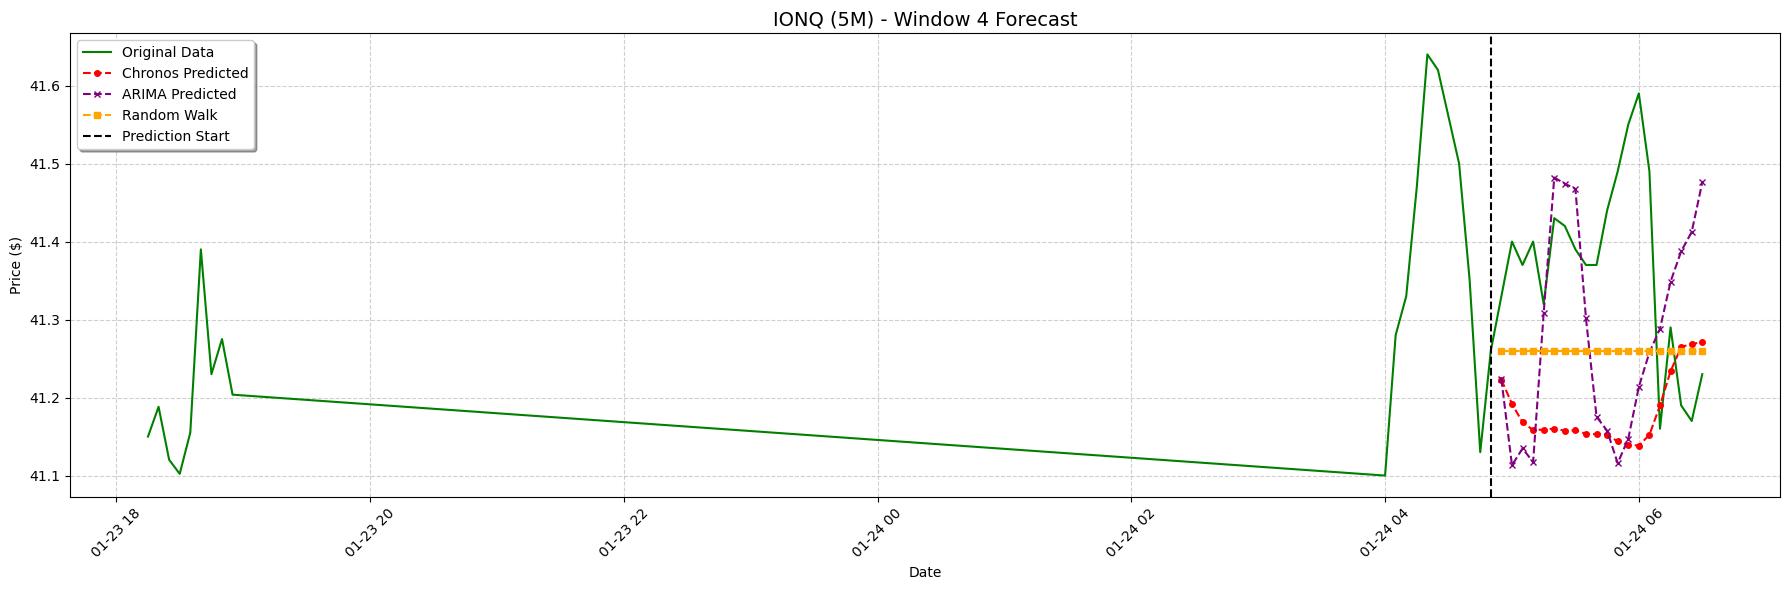

  Chronos - MAE: 0.2126, RMSE: 0.2429
  ARIMA   - MAE: 0.1955, RMSE: 0.2279
  Rand.W. - MAE: 0.1390, RMSE: 0.1599
Processing window 5/50...


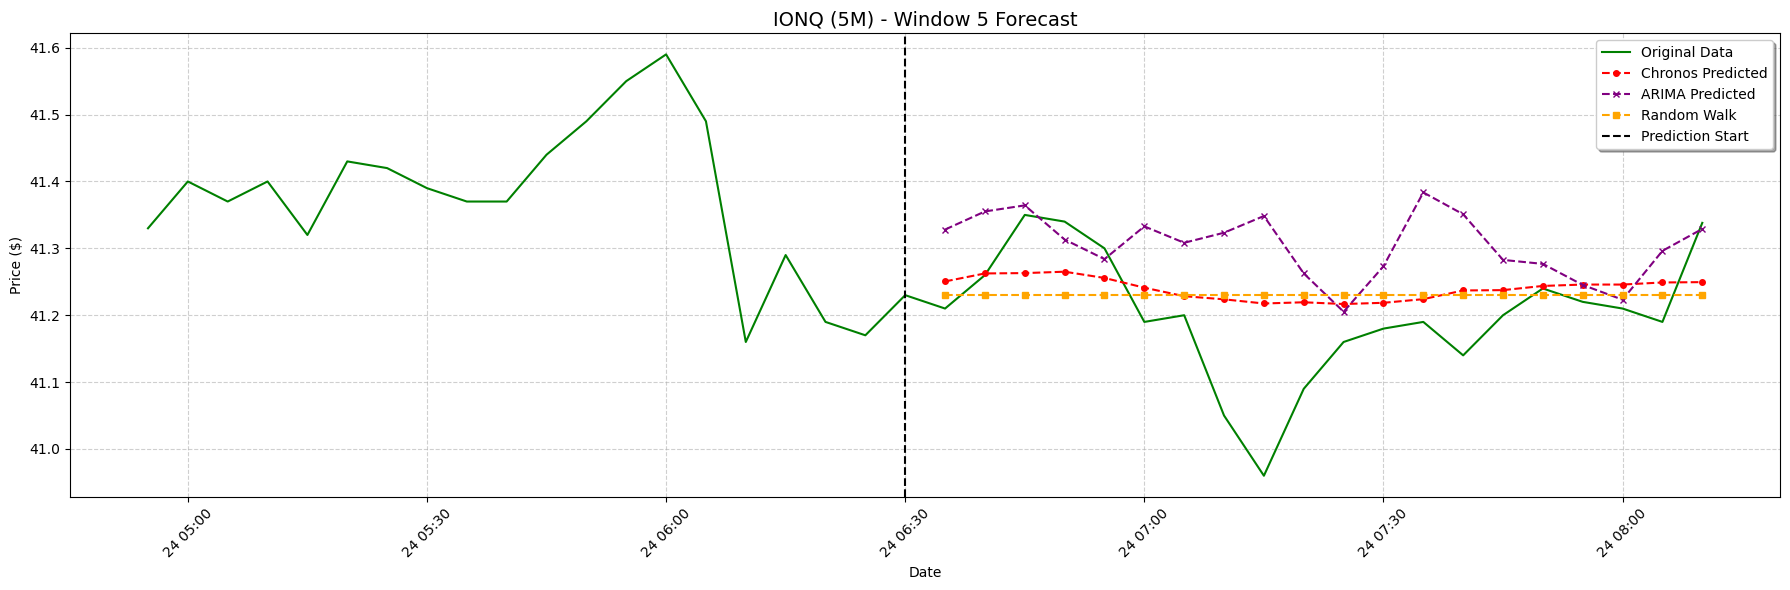

  Chronos - MAE: 0.0683, RMSE: 0.0904
  ARIMA   - MAE: 0.1086, RMSE: 0.1457
  Rand.W. - MAE: 0.0739, RMSE: 0.0980
Processing window 6/50...


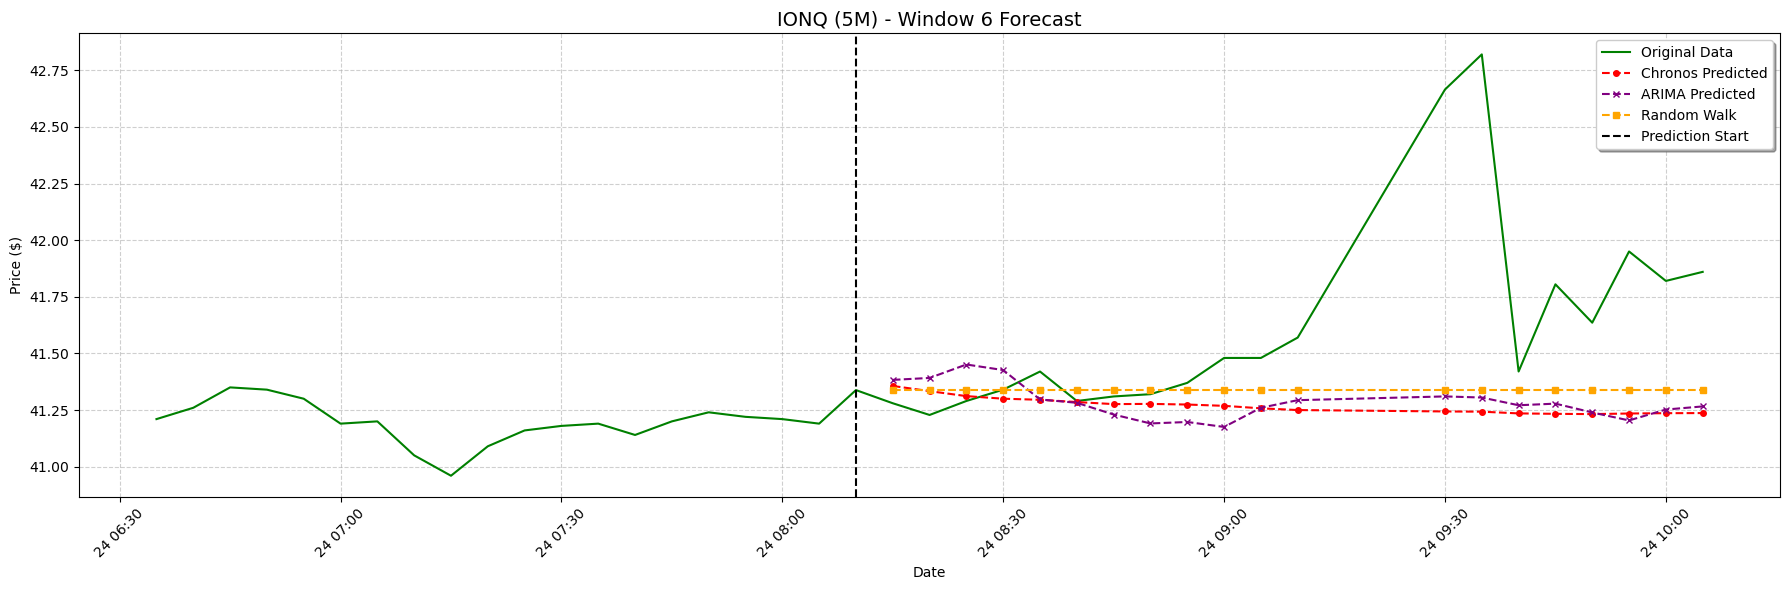

  Chronos - MAE: 0.3690, RMSE: 0.5708
  ARIMA   - MAE: 0.3839, RMSE: 0.5556
  Rand.W. - MAE: 0.3106, RMSE: 0.5134
Processing window 7/50...


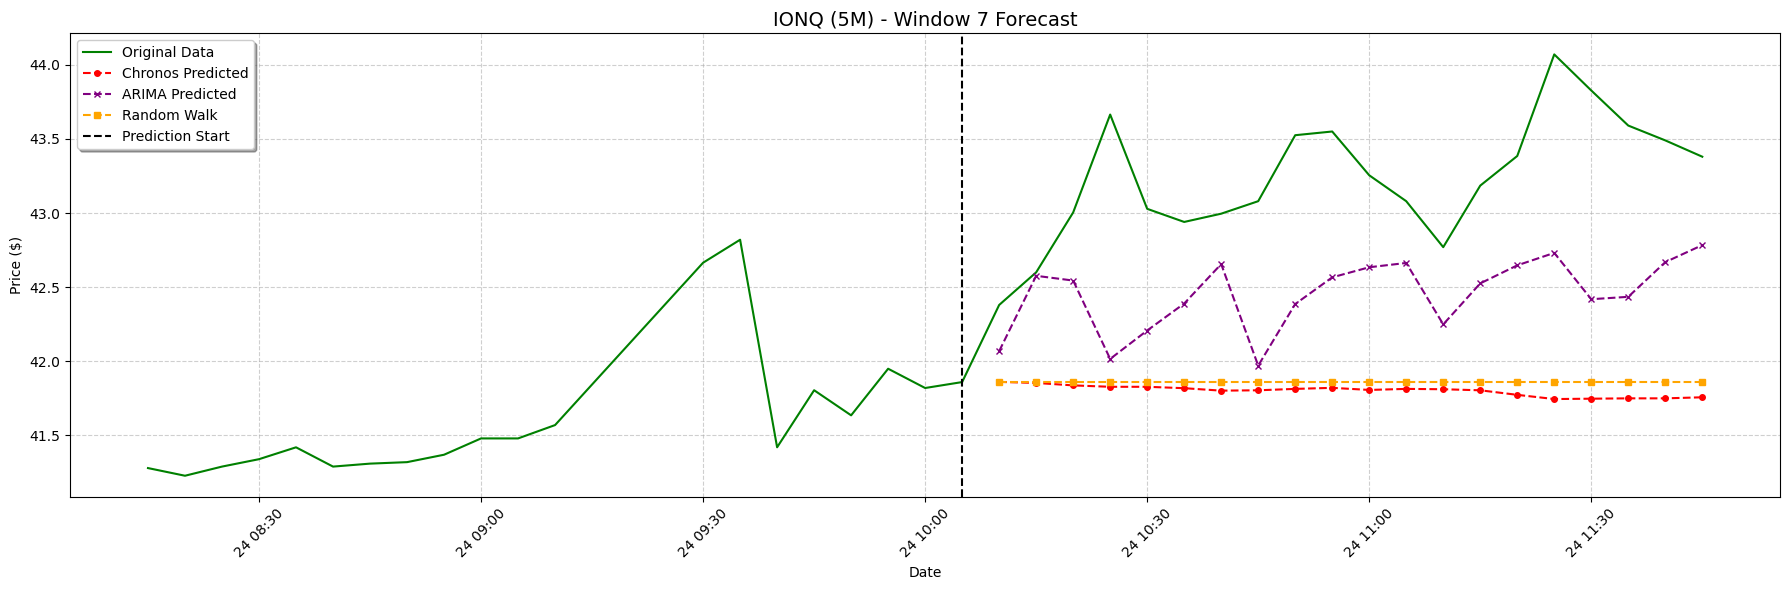

  Chronos - MAE: 1.4383, RMSE: 1.5018
  ARIMA   - MAE: 0.7829, RMSE: 0.8820
  Rand.W. - MAE: 1.3799, RMSE: 1.4383
Processing window 8/50...


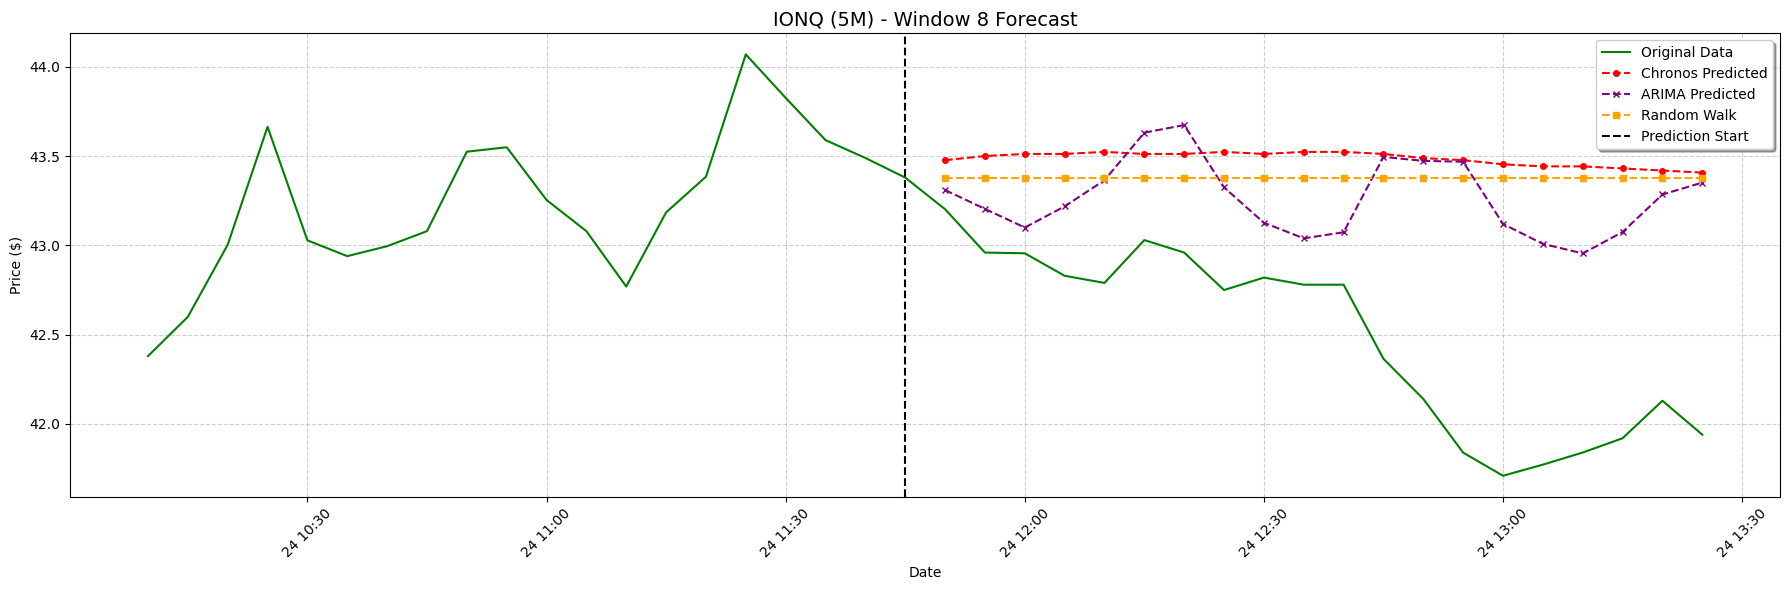

  Chronos - MAE: 1.0099, RMSE: 1.1120
  ARIMA   - MAE: 0.7895, RMSE: 0.9263
  Rand.W. - MAE: 0.9042, RMSE: 1.0301
Processing window 9/50...


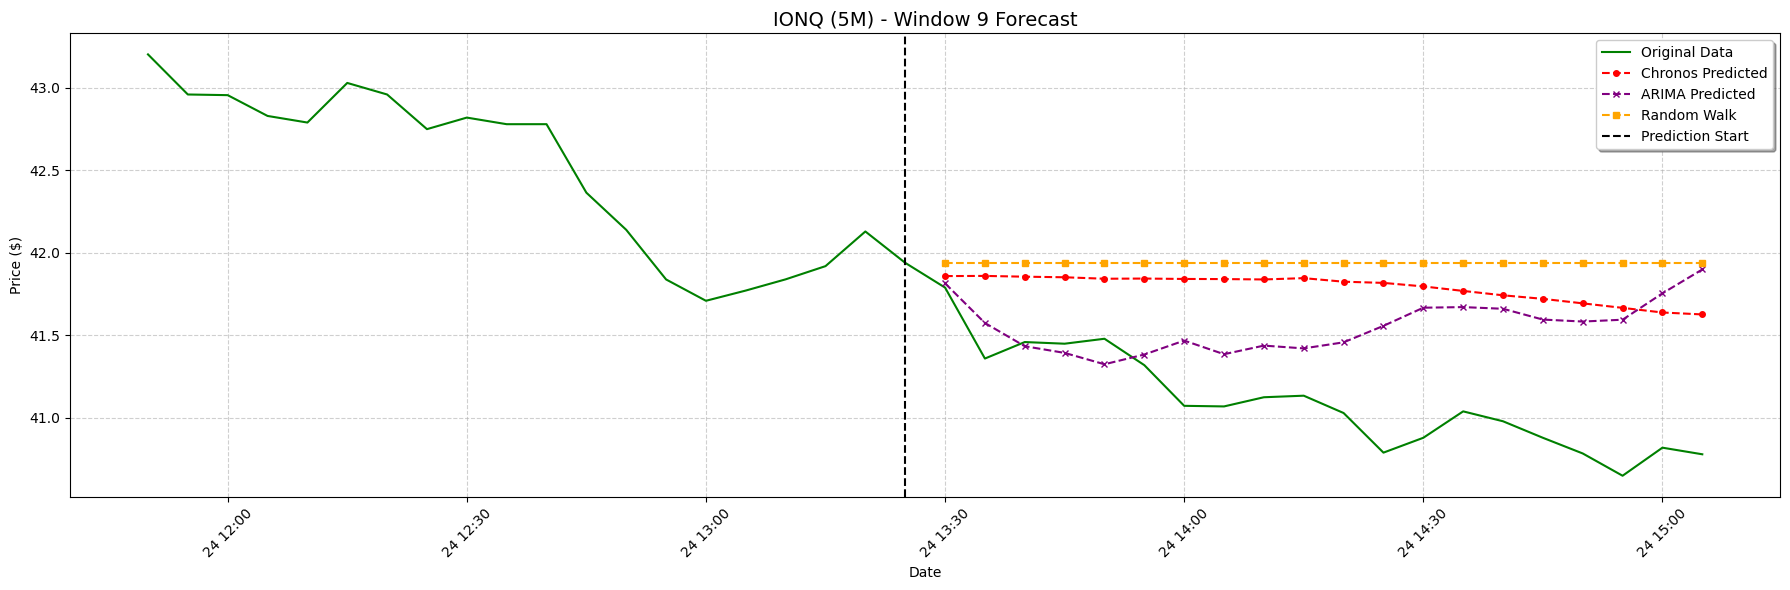

  Chronos - MAE: 0.6946, RMSE: 0.7346
  ARIMA   - MAE: 0.4833, RMSE: 0.5894
  Rand.W. - MAE: 0.8450, RMSE: 0.8936
Processing window 10/50...


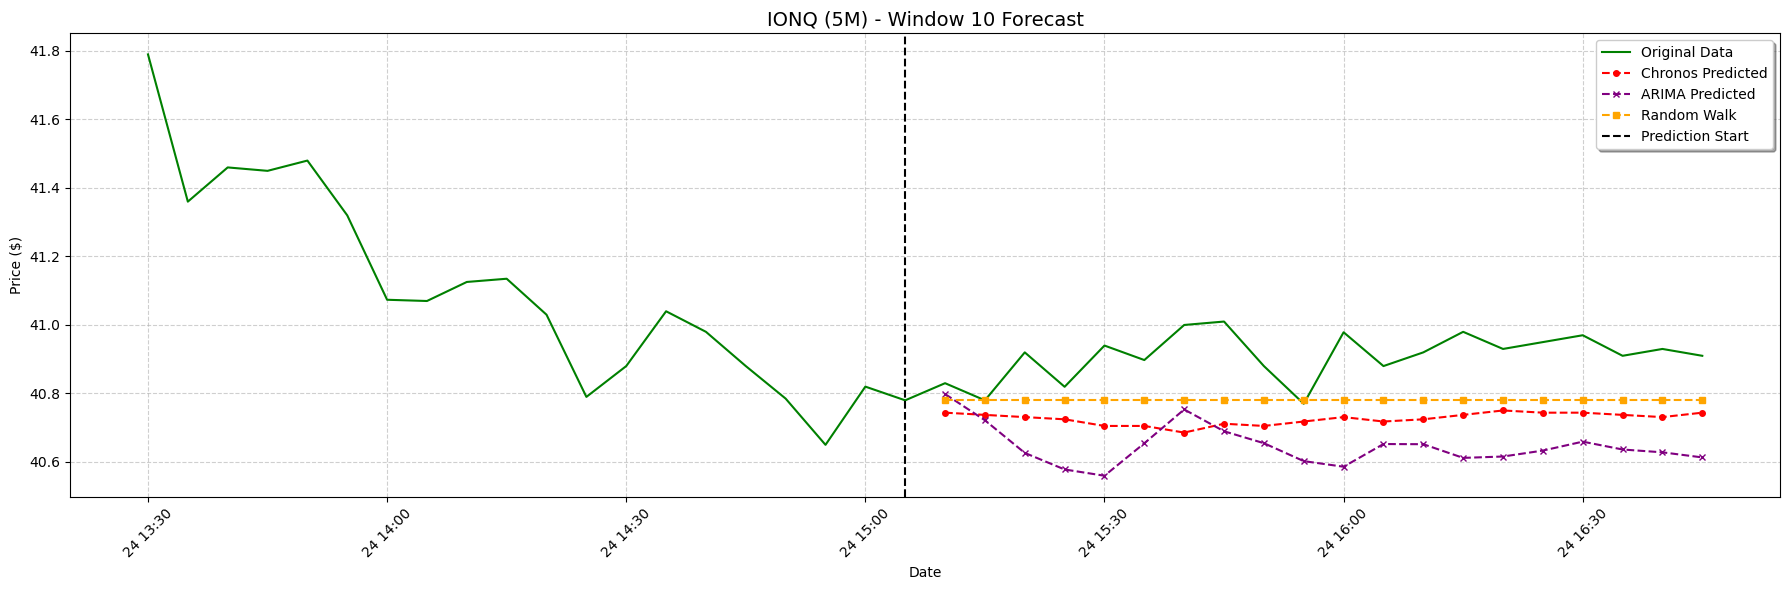

  Chronos - MAE: 0.1838, RMSE: 0.1968
  ARIMA   - MAE: 0.2639, RMSE: 0.2790
  Rand.W. - MAE: 0.1313, RMSE: 0.1462
Processing window 11/50...


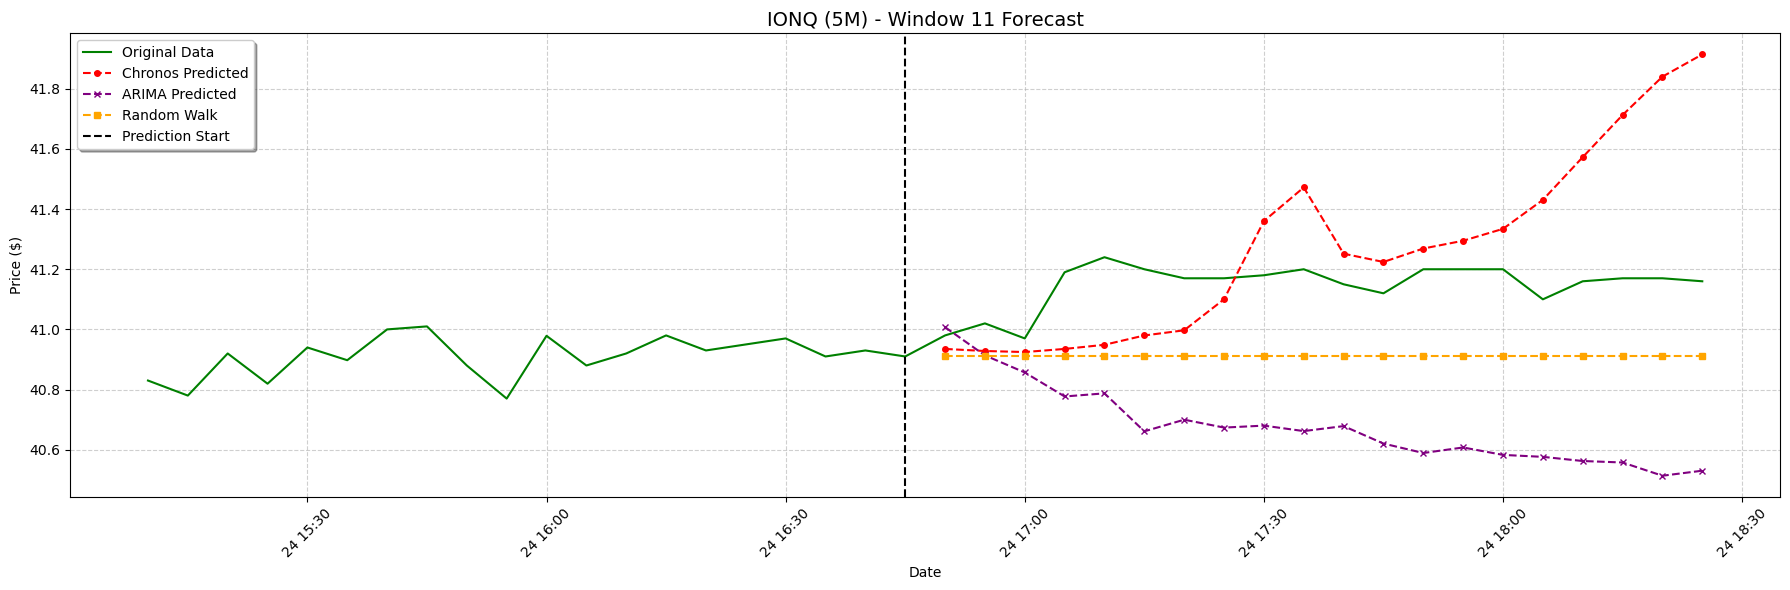

  Chronos - MAE: 0.2429, RMSE: 0.3160
  ARIMA   - MAE: 0.4734, RMSE: 0.5054
  Rand.W. - MAE: 0.2375, RMSE: 0.2484
Processing window 12/50...


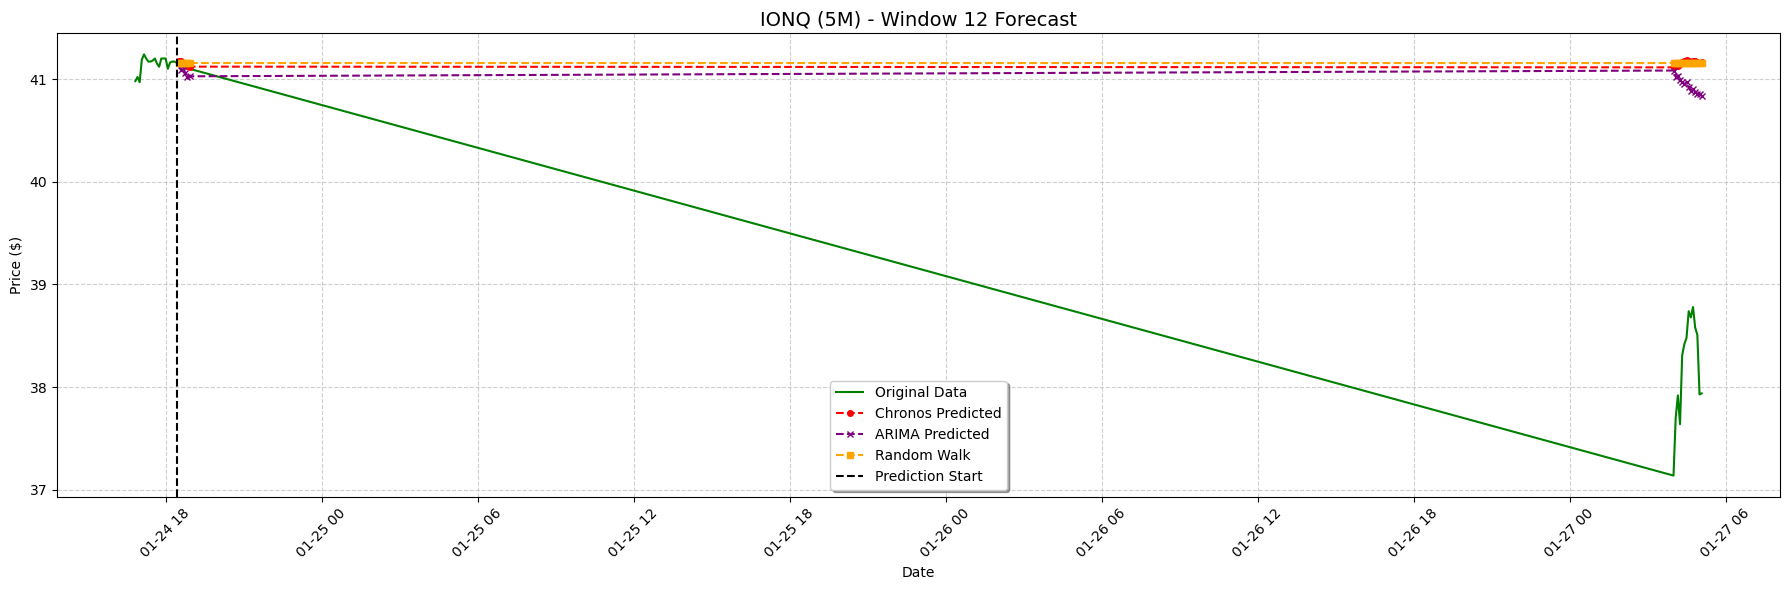

  Chronos - MAE: 2.0789, RMSE: 2.5070
  ARIMA   - MAE: 1.9407, RMSE: 2.3347
  Rand.W. - MAE: 2.0790, RMSE: 2.5099
Processing window 13/50...


KeyboardInterrupt: 

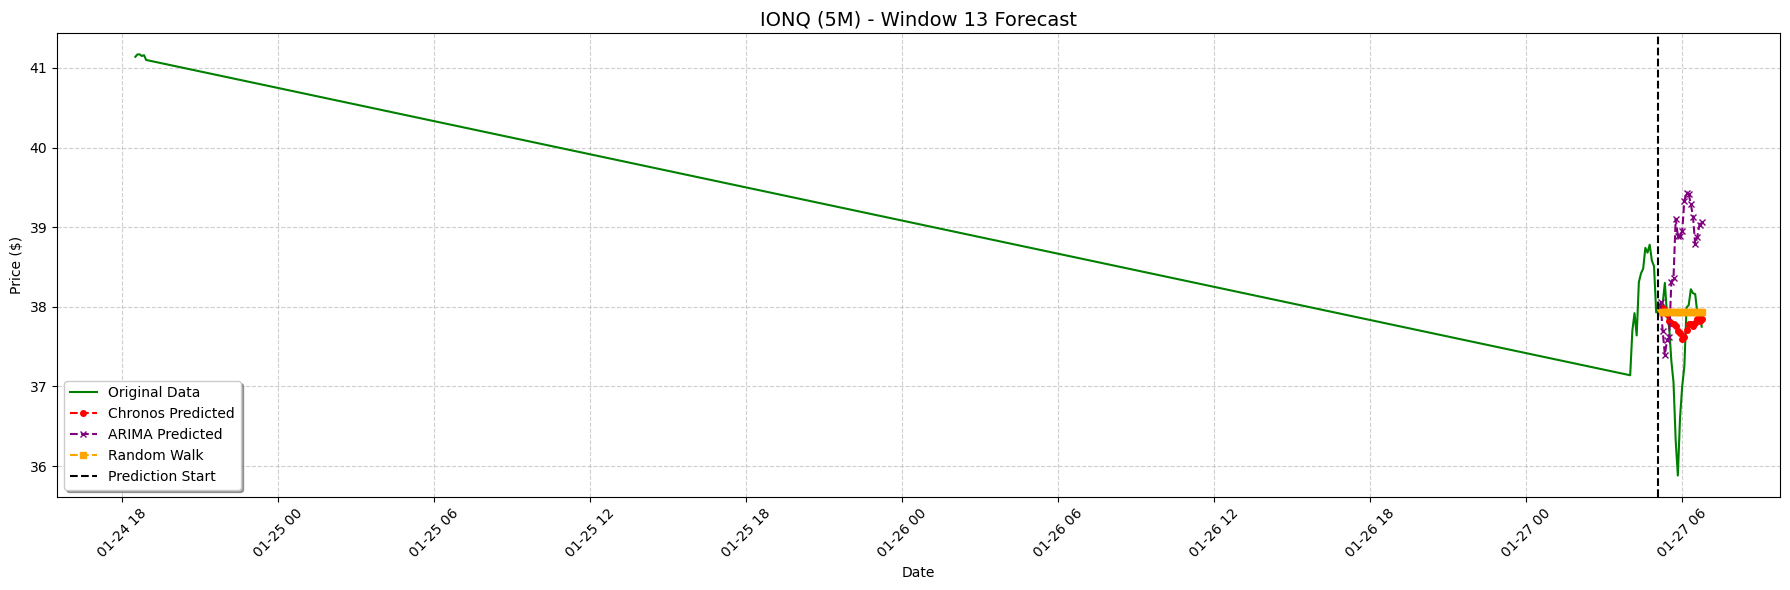

In [7]:
# Process all tickers except NVDA for both intervals
def process_all_tickers(interval_dir, interval_name):
    csv_files = [os.path.join(interval_dir, f) for f in os.listdir(interval_dir) if f.endswith('.csv')]
    for file in csv_files:
        if 'NVDA' not in file:
            print(f'\nProcessing {os.path.basename(file)}...')
            process_dataset(file, interval_name)

print('Processing 5-minute data...')
process_all_tickers(data_dir_5m, '5M')


print('\nProcessing 15-minute data...')
process_all_tickers(data_dir_15m, '15M')

print('\nProessing 1hourly data...')
process_all_tickers(data_dir_1h, '1H')

In [ ]:
# Example: Compare NVDA across different time intervals
# Note: This will only work after you've run predictions for all intervals
# compare_ticker_across_intervals('NVDA')